<a href="https://colab.research.google.com/github/semesarker/A-Dilated-Attention-U-Net-Based-Approach-on-Speech-Emotion-Recognition/blob/main/Unet_GRU_model_on_Data_Augmented_BanglaSER_using_feature_concatenation(mfcc%26mel_spectrogram).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Keras
#import tensorflow as tf
import IPython
import keras
from keras import regularizers

from keras.models import Sequential, Model, model_from_json
from keras.layers import Dense, Embedding, LSTM
from keras.layers import Input, Flatten, Dropout, Activation, BatchNormalization
from keras.layers import Conv1D,Conv2D,MaxPool2D, MaxPooling1D, AveragePooling1D
from tensorflow.keras.utils import to_categorical
from keras.callbacks import (EarlyStopping, LearningRateScheduler,
                             ModelCheckpoint, TensorBoard, ReduceLROnPlateau)
from keras import losses, models, optimizers
from keras.activations import relu, softmax
from keras.layers import (Conv2D,Conv2DTranspose, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout,
                          GlobalMaxPool2D, MaxPool2D, concatenate, Activation, Input, Dense)
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer


# from keras_preprocessing.sequence import pad_seq?uences


# sklearn
from sklearn.metrics import confusion_matrix, accuracy_score,classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler, OneHotEncoder

# Other
from tqdm import tqdm, tqdm_pandas
import scipy
from scipy.stats import skew
import librosa
import librosa.display
import json
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
import pandas as pd
import seaborn as sns
import glob
import os
import sys
import IPython.display as Audio  # To play sound in the notebook
import warnings

import numpy as np # linear algebra
import pandas as pd
from tqdm import tqdm
from glob import glob
from keras.layers import *
from keras.models import *
from keras.utils import *
import numpy as np
import os
from tensorflow.keras.optimizers import Adam

# ignore warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

In [ ]:
banglaSER_final = '/content/drive/MyDrive/THSIS/aug_banglaser/'
banglaSER_final_directory_list = os.listdir(banglaSER_final)
banglaSER_final_directory_list


['03-01-01-01-02-02-18_Clean_1217.wav',
 '03-01-01-01-02-02-18_Noisy_1217.wav',
 '03-01-01-01-02-02-18_shift_1217.wav',
 '03-01-01-01-02-02-18_stretchy_1217.wav',
 '03-01-03-02-03-02-18_Clean_1218.wav',
 '03-01-03-02-03-02-18_Noisy_1218.wav',
 '03-01-03-02-03-02-18_shift_1218.wav',
 '03-01-03-02-03-02-18_stretchy_1218.wav',
 '03-01-01-01-03-03-18_Clean_1219.wav',
 '03-01-01-01-03-03-18_Noisy_1219.wav',
 '03-01-01-01-03-03-18_shift_1219.wav',
 '03-01-01-01-03-03-18_stretchy_1219.wav',
 '03-01-03-02-03-03-18_Clean_1220.wav',
 '03-01-03-02-03-03-18_Noisy_1220.wav',
 '03-01-03-02-03-03-18_shift_1220.wav',
 '03-01-03-02-03-03-18_stretchy_1220.wav',
 '03-01-02-01-02-02-18_Clean_1221.wav',
 '03-01-02-01-02-02-18_Noisy_1221.wav',
 '03-01-02-01-02-02-18_shift_1221.wav',
 '03-01-02-01-02-02-18_stretchy_1221.wav',
 '03-01-02-01-02-01-18_Clean_1222.wav',
 '03-01-02-01-02-01-18_Noisy_1222.wav',
 '03-01-02-01-02-01-18_shift_1222.wav',
 '03-01-02-01-02-01-18_stretchy_1222.wav',
 '03-01-01-01-03-01-18

In [ ]:
a=list()
b=list()
c=list()
banglaSER_final_directory_list = os.listdir(banglaSER_final)
file_path = []
file_emotion = []
for directory in banglaSER_final_directory_list:

        part1 = directory.split('_')[0]
        # print(part1)
        part2 = part1.split('-')
        # print(part2)
        # third part in each file represents the emotion associated to that file
        file_emotion.append(int(part2[2]))
        file_path.append(banglaSER_final +  directory )

        a.append(banglaSER_final + directory )
        b.append(part1)
        c.append(part2)

In [ ]:
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])
# dataframe for path of files
path_df = pd.DataFrame(file_path, columns=['Path'])
banglaSER_final_df = pd.concat([emotion_df, path_df], axis=1)
# decode integers to actual emotions

banglaSER_final_df.Emotions.replace({1:'happy', 2:'sad', 3:'angry', 4:'surprise', 5:'neutral'}, inplace=True)
banglaSER_final_df

,Emotions,Path
0,happy,/content/drive/MyDrive/THSIS/aug_banglaser/03-...
1,happy,/content/drive/MyDrive/THSIS/aug_banglaser/03-...
2,happy,/content/drive/MyDrive/THSIS/aug_banglaser/03-...
3,happy,/content/drive/MyDrive/THSIS/aug_banglaser/03-...
4,angry,/content/drive/MyDrive/THSIS/aug_banglaser/03-...
...,...,...
5863,surprise,/content/drive/MyDrive/THSIS/aug_banglaser/03-...
5864,sad,/content/drive/MyDrive/THSIS/aug_banglaser/03-...
5865,sad,/content/drive/MyDrive/THSIS/aug_banglaser/03-...
5866,sad,/content/drive/MyDrive/THSIS/aug_banglaser/03-...


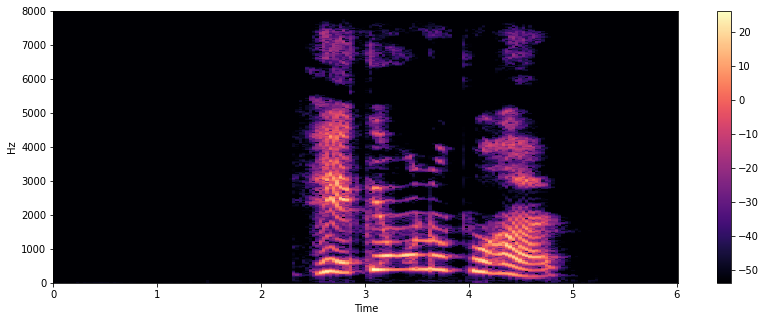

In [ ]:
emotion='angry'
path = np.array(banglaSER_final_df.Path[banglaSER_final_df.Emotions==emotion])[10]
data, sr = librosa.load(path,sr=16000, duration=3)
st_data = np.abs(librosa.stft(data,n_fft=512,hop_length=256,win_length=512))
st_db = librosa.amplitude_to_db(st_data)
plt.figure(figsize=(14, 5))
librosa.display.specshow(st_db, sr=16000, x_axis='time', y_axis='hz')
plt.colorbar()

In [ ]:
def create_mel_spectrogram(data, sr, e):
    mel_signal = librosa.feature.melspectrogram(y=data, sr=sr,n_fft=512,hop_length=256, n_mels=30)
    spectrogram = np.abs(mel_signal)
    power_to_db = librosa.amplitude_to_db(spectrogram, ref=np.max)
    plt.figure(figsize=(12, 3))
    plt.title('Mel-Spectrogram for {}'.format(e), size=15)
    librosa.display.specshow(power_to_db, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar()

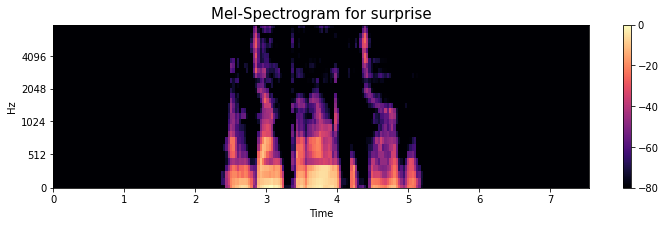

In [ ]:
emotion='surprise'
path = np.array(banglaSER_final_df.Path[banglaSER_final_df.Emotions==emotion])[0]
data, sr = librosa.load(path,sr=16000, duration=4)
mel_spectrogram=np.abs(librosa.feature.melspectrogram(data,sr=sr,n_fft=512,hop_length=256,n_mels=30))
log_mel_spectrogram=librosa.amplitude_to_db(mel_spectrogram, ref=np.max)
create_mel_spectrogram(data,sr,emotion)

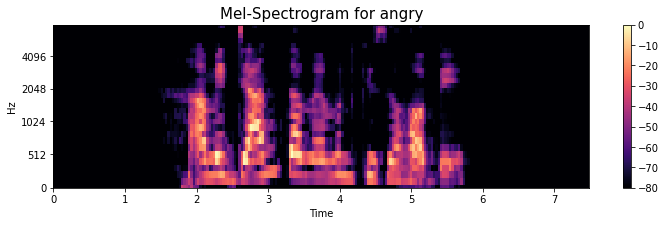

In [ ]:
emotion='angry'
path = np.array(banglaSER_final_df.Path[banglaSER_final_df.Emotions==emotion])[0]
data, sr = librosa.load(path,sr=16000, duration=4)
mel_spectrogram=np.abs(librosa.feature.melspectrogram(data,sr=sr,n_fft=512,hop_length=256,n_mels=30))
log_mel_spectrogram=librosa.amplitude_to_db(mel_spectrogram, ref=np.max)
create_mel_spectrogram(data,sr,emotion)

In [ ]:
def create_mfcc(data,sr,e):
    mfcc = librosa.feature.mfcc(y=data, sr=16000, n_mfcc=30)
    plt.figure(figsize=(12,3))
    plt.title('Mel-frequency cepstral coefficient for {}'.format(e), size=15)
    librosa.display.specshow(mfcc, x_axis='time',sr=sr)
    plt.ylabel('MFCC')
    plt.colorbar(format='%+02.0f dB')

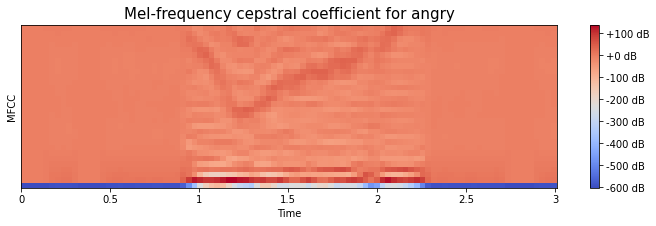

In [ ]:

emotion='angry'
path = np.array(banglaSER_final_df.Path[banglaSER_final_df.Emotions==emotion])[150]
data, sr = librosa.load(path, sr=16000, duration=3)
create_mfcc(data, sr, emotion)

In [ ]:
def match_dimension(data,input_length):

  if len(data) > input_length:
      max_offset = int(len(data) - input_length)
      data = data[0:input_length]
  else:
      max_offset =int(input_length - len(data))
      offset = np.zeros(max_offset)
      data=np.concatenate((data,offset),axis=0)

  return data

In [ ]:
sampling_rate=16000
audio_duration=3
n_mfcc = 30
n_melspec = 30
n_fft=512
def prepare_data(df, n, mfcc ,mel):
    X = np.empty(shape=(df.shape[0], n,94,1))
    input_length = sampling_rate * audio_duration

    cnt = 0
    for fname in tqdm(df.Path):
        file_path = fname
        data, sr = librosa.load(file_path, sr=sampling_rate

                               ,duration=3

                              )

        if len(data)!= input_length:

        # Random offset / Padding
            data=match_dimension(data,48000)


        if mfcc == 1 and mel== 0:
                  # MFCC extraction
              MFCC = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=n_mfcc)
              MFCC = np.expand_dims(MFCC, axis=-1)
              X[cnt,] = MFCC
              print('mfcc',MFCC.shape)

        elif mfcc==0 and mel==1 :
                  # Log-melspectogram

              melspec = librosa.feature.melspectrogram(y=data,sr=sampling_rate, n_fft=2048,hop_length=512)
              mel_spectrogram = np.abs(melspec)
              logspec = librosa.amplitude_to_db(mel_spectrogram)
              logspec = np.expand_dims(logspec, axis=-1)
              X[cnt,] = logspec

              print('mel',logspec.shape)

        elif mfcc==1 and mel== 1:
              MFCC = librosa.feature.mfcc(y=data, sr=sampling_rate, n_mfcc=n_mfcc)
              melspec = librosa.feature.melspectrogram(y=data,sr=sampling_rate,n_fft=2048,hop_length=512, n_mels = n_melspec)
              mel_spectrogram = np.abs(melspec)
              logspec = librosa.amplitude_to_db(mel_spectrogram)
              mfcc_logspec= np.concatenate((MFCC,logspec),axis=0)
              #mel_logspec= np.vstack([MFCC,logspec])
              #print(mfcc_logspec.shape)
              mfcc_logspec = np.expand_dims(mfcc_logspec, axis=-1)
              X[cnt,] = mfcc_logspec
              print('mfcc_logspec',mfcc_logspec.shape)

        cnt += 1

    return X

In [ ]:
mel_mfcc = prepare_data(banglaSER_final_df,n=60,mfcc=1,mel=1)

  0%|          | 0/5868 [00:00<?, ?it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 2/5868 [00:02<1:39:39,  1.02s/it]

mfcc_logspec (60, 94, 1)


  0%|          | 3/5868 [00:02<1:36:11,  1.02it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 4/5868 [00:03<1:34:39,  1.03it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 5/5868 [00:04<1:31:47,  1.06it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 6/5868 [00:05<1:28:44,  1.10it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 7/5868 [00:06<1:25:10,  1.15it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 8/5868 [00:07<1:23:26,  1.17it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 9/5868 [00:08<1:23:49,  1.16it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 10/5868 [00:08<1:22:09,  1.19it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 11/5868 [00:09<1:21:21,  1.20it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 12/5868 [00:10<1:27:05,  1.12it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 13/5868 [00:11<1:27:20,  1.12it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 14/5868 [00:12<1:27:45,  1.11it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 15/5868 [00:13<1:27:26,  1.12it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 16/5868 [00:14<1:28:00,  1.11it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 17/5868 [00:15<1:28:15,  1.10it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 18/5868 [00:16<1:26:50,  1.12it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 19/5868 [00:16<1:24:40,  1.15it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 20/5868 [00:17<1:22:40,  1.18it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 21/5868 [00:18<1:29:23,  1.09it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 22/5868 [00:19<1:29:16,  1.09it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 23/5868 [00:20<1:28:29,  1.10it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 24/5868 [00:21<1:25:15,  1.14it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 25/5868 [00:22<1:25:15,  1.14it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 26/5868 [00:23<1:25:22,  1.14it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 27/5868 [00:24<1:26:51,  1.12it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 28/5868 [00:25<1:29:19,  1.09it/s]

mfcc_logspec (60, 94, 1)


  0%|          | 29/5868 [00:25<1:26:35,  1.12it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 30/5868 [00:26<1:26:26,  1.13it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 31/5868 [00:27<1:27:47,  1.11it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 32/5868 [00:28<1:28:15,  1.10it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 33/5868 [00:29<1:30:21,  1.08it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 34/5868 [00:30<1:29:12,  1.09it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 35/5868 [00:31<1:28:22,  1.10it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 36/5868 [00:32<1:31:54,  1.06it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 37/5868 [00:33<1:27:46,  1.11it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 38/5868 [00:34<1:26:05,  1.13it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 39/5868 [00:34<1:22:52,  1.17it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 40/5868 [00:35<1:21:18,  1.19it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 41/5868 [00:36<1:23:28,  1.16it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 42/5868 [00:37<1:24:49,  1.14it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 43/5868 [00:38<1:27:20,  1.11it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 44/5868 [00:39<1:27:55,  1.10it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 45/5868 [00:40<1:27:03,  1.11it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 46/5868 [00:41<1:28:13,  1.10it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 47/5868 [00:42<1:28:22,  1.10it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 48/5868 [00:43<1:28:21,  1.10it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 49/5868 [00:43<1:27:57,  1.10it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 50/5868 [00:44<1:27:57,  1.10it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 51/5868 [00:45<1:28:53,  1.09it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 52/5868 [00:46<1:27:43,  1.10it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 53/5868 [00:47<1:27:40,  1.11it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 54/5868 [00:48<1:28:15,  1.10it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 55/5868 [00:49<1:26:59,  1.11it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 56/5868 [00:50<1:25:57,  1.13it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 57/5868 [00:51<1:27:20,  1.11it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 58/5868 [00:52<1:28:13,  1.10it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 59/5868 [00:53<1:29:19,  1.08it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 60/5868 [00:53<1:27:26,  1.11it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 61/5868 [00:54<1:27:56,  1.10it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 62/5868 [00:55<1:26:14,  1.12it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 63/5868 [00:56<1:29:50,  1.08it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 64/5868 [00:57<1:29:52,  1.08it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 65/5868 [00:58<1:26:12,  1.12it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 66/5868 [00:59<1:24:50,  1.14it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 67/5868 [01:00<1:25:44,  1.13it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 68/5868 [01:00<1:22:33,  1.17it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 69/5868 [01:01<1:21:27,  1.19it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 70/5868 [01:02<1:28:28,  1.09it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 71/5868 [01:03<1:27:38,  1.10it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 72/5868 [01:04<1:24:11,  1.15it/s]

mfcc_logspec (60, 94, 1)


  1%|          | 73/5868 [01:05<1:24:36,  1.14it/s]

mfcc_logspec (60, 94, 1)


  1%|▏         | 74/5868 [01:06<1:22:16,  1.17it/s]

mfcc_logspec (60, 94, 1)


  1%|▏         | 75/5868 [01:07<1:21:04,  1.19it/s]

mfcc_logspec (60, 94, 1)


  1%|▏         | 76/5868 [01:07<1:23:42,  1.15it/s]

mfcc_logspec (60, 94, 1)


  1%|▏         | 77/5868 [01:08<1:23:18,  1.16it/s]

mfcc_logspec (60, 94, 1)


  1%|▏         | 78/5868 [01:09<1:20:29,  1.20it/s]

mfcc_logspec (60, 94, 1)


  1%|▏         | 79/5868 [01:10<1:23:42,  1.15it/s]

mfcc_logspec (60, 94, 1)


  1%|▏         | 80/5868 [01:11<1:23:09,  1.16it/s]

mfcc_logspec (60, 94, 1)


  1%|▏         | 81/5868 [01:12<1:21:28,  1.18it/s]

mfcc_logspec (60, 94, 1)


  1%|▏         | 82/5868 [01:12<1:20:46,  1.19it/s]

mfcc_logspec (60, 94, 1)


  1%|▏         | 83/5868 [01:13<1:21:22,  1.18it/s]

mfcc_logspec (60, 94, 1)


  1%|▏         | 84/5868 [01:14<1:22:33,  1.17it/s]

mfcc_logspec (60, 94, 1)


  1%|▏         | 85/5868 [01:15<1:21:49,  1.18it/s]

mfcc_logspec (60, 94, 1)


  1%|▏         | 86/5868 [01:16<1:20:50,  1.19it/s]

mfcc_logspec (60, 94, 1)


  1%|▏         | 87/5868 [01:17<1:22:44,  1.16it/s]

mfcc_logspec (60, 94, 1)


  1%|▏         | 88/5868 [01:18<1:22:43,  1.16it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 89/5868 [01:19<1:23:08,  1.16it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 90/5868 [01:19<1:23:24,  1.15it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 91/5868 [01:20<1:23:18,  1.16it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 92/5868 [01:21<1:24:36,  1.14it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 93/5868 [01:22<1:25:13,  1.13it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 94/5868 [01:23<1:22:59,  1.16it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 95/5868 [01:24<1:21:44,  1.18it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 96/5868 [01:24<1:20:28,  1.20it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 97/5868 [01:25<1:19:16,  1.21it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 98/5868 [01:26<1:18:23,  1.23it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 99/5868 [01:27<1:21:16,  1.18it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 100/5868 [01:28<1:20:19,  1.20it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 101/5868 [01:29<1:20:16,  1.20it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 102/5868 [01:29<1:19:01,  1.22it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 103/5868 [01:30<1:18:12,  1.23it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 104/5868 [01:31<1:19:56,  1.20it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 105/5868 [01:32<1:21:03,  1.18it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 106/5868 [01:33<1:20:59,  1.19it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 107/5868 [01:34<1:19:40,  1.21it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 108/5868 [01:34<1:18:33,  1.22it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 109/5868 [01:35<1:19:31,  1.21it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 110/5868 [01:36<1:20:21,  1.19it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 111/5868 [01:37<1:20:20,  1.19it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 112/5868 [01:38<1:19:43,  1.20it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 113/5868 [01:39<1:18:32,  1.22it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 114/5868 [01:39<1:20:04,  1.20it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 115/5868 [01:40<1:18:09,  1.23it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 116/5868 [01:41<1:17:14,  1.24it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 117/5868 [01:42<1:17:21,  1.24it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 118/5868 [01:43<1:17:02,  1.24it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 119/5868 [01:43<1:16:32,  1.25it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 120/5868 [01:44<1:15:50,  1.26it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 121/5868 [01:45<1:17:22,  1.24it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 122/5868 [01:46<1:18:33,  1.22it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 123/5868 [01:47<1:21:42,  1.17it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 124/5868 [01:48<1:20:46,  1.19it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 125/5868 [01:48<1:19:42,  1.20it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 126/5868 [01:49<1:22:17,  1.16it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 127/5868 [01:50<1:21:25,  1.18it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 128/5868 [01:51<1:21:41,  1.17it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 129/5868 [01:52<1:20:32,  1.19it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 130/5868 [01:53<1:18:48,  1.21it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 131/5868 [01:53<1:17:49,  1.23it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 132/5868 [01:54<1:18:21,  1.22it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 133/5868 [01:55<1:22:54,  1.15it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 134/5868 [01:56<1:21:20,  1.17it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 135/5868 [01:57<1:20:53,  1.18it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 136/5868 [01:58<1:23:01,  1.15it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 137/5868 [01:59<1:23:23,  1.15it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 138/5868 [02:00<1:24:16,  1.13it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 139/5868 [02:00<1:24:53,  1.12it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 140/5868 [02:01<1:22:50,  1.15it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 141/5868 [02:02<1:23:14,  1.15it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 142/5868 [02:03<1:21:56,  1.16it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 143/5868 [02:04<1:24:39,  1.13it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 144/5868 [02:05<1:25:37,  1.11it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 145/5868 [02:06<1:23:39,  1.14it/s]

mfcc_logspec (60, 94, 1)


  2%|▏         | 146/5868 [02:07<1:32:49,  1.03it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 147/5868 [02:08<1:29:52,  1.06it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 148/5868 [02:09<1:27:55,  1.08it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 149/5868 [02:10<1:26:46,  1.10it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 150/5868 [02:10<1:26:09,  1.11it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 151/5868 [02:11<1:23:21,  1.14it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 152/5868 [02:12<1:23:35,  1.14it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 153/5868 [02:13<1:23:11,  1.14it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 154/5868 [02:14<1:20:16,  1.19it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 155/5868 [02:15<1:21:13,  1.17it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 156/5868 [02:15<1:19:25,  1.20it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 157/5868 [02:16<1:21:36,  1.17it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 158/5868 [02:17<1:21:14,  1.17it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 159/5868 [02:18<1:24:12,  1.13it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 160/5868 [02:19<1:24:46,  1.12it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 161/5868 [02:20<1:22:47,  1.15it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 162/5868 [02:21<1:21:09,  1.17it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 163/5868 [02:22<1:22:29,  1.15it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 164/5868 [02:22<1:20:15,  1.18it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 165/5868 [02:23<1:19:59,  1.19it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 166/5868 [02:24<1:20:54,  1.17it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 167/5868 [02:25<1:23:34,  1.14it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 168/5868 [02:26<1:24:58,  1.12it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 169/5868 [02:27<1:25:09,  1.12it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 170/5868 [02:28<1:24:34,  1.12it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 171/5868 [02:29<1:25:27,  1.11it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 172/5868 [02:30<1:24:03,  1.13it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 173/5868 [02:30<1:23:59,  1.13it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 174/5868 [02:31<1:23:21,  1.14it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 175/5868 [02:32<1:21:51,  1.16it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 176/5868 [02:33<1:22:55,  1.14it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 177/5868 [02:34<1:23:29,  1.14it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 178/5868 [02:35<1:22:52,  1.14it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 179/5868 [02:36<1:24:49,  1.12it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 180/5868 [02:37<1:25:02,  1.11it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 181/5868 [02:37<1:24:48,  1.12it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 182/5868 [02:38<1:23:01,  1.14it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 183/5868 [02:39<1:24:08,  1.13it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 184/5868 [02:40<1:25:57,  1.10it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 185/5868 [02:41<1:26:24,  1.10it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 186/5868 [02:42<1:23:41,  1.13it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 187/5868 [02:43<1:24:07,  1.13it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 188/5868 [02:44<1:25:30,  1.11it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 189/5868 [02:45<1:22:58,  1.14it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 190/5868 [02:45<1:23:58,  1.13it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 191/5868 [02:46<1:21:58,  1.15it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 192/5868 [02:47<1:19:08,  1.20it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 193/5868 [02:48<1:21:19,  1.16it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 194/5868 [02:49<1:20:17,  1.18it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 195/5868 [02:50<1:22:15,  1.15it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 196/5868 [02:51<1:23:59,  1.13it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 197/5868 [02:52<1:25:00,  1.11it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 198/5868 [02:52<1:24:26,  1.12it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 199/5868 [02:53<1:24:19,  1.12it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 200/5868 [02:54<1:24:20,  1.12it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 201/5868 [02:55<1:25:23,  1.11it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 202/5868 [02:56<1:26:04,  1.10it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 203/5868 [02:57<1:26:01,  1.10it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 204/5868 [02:58<1:26:59,  1.09it/s]

mfcc_logspec (60, 94, 1)


  3%|▎         | 205/5868 [02:59<1:26:37,  1.09it/s]

mfcc_logspec (60, 94, 1)


  4%|▎         | 206/5868 [03:00<1:25:51,  1.10it/s]

mfcc_logspec (60, 94, 1)


  4%|▎         | 207/5868 [03:01<1:24:48,  1.11it/s]

mfcc_logspec (60, 94, 1)


  4%|▎         | 208/5868 [03:02<1:25:28,  1.10it/s]

mfcc_logspec (60, 94, 1)


  4%|▎         | 209/5868 [03:02<1:24:37,  1.11it/s]

mfcc_logspec (60, 94, 1)


  4%|▎         | 210/5868 [03:03<1:27:33,  1.08it/s]

mfcc_logspec (60, 94, 1)


  4%|▎         | 211/5868 [03:04<1:27:15,  1.08it/s]

mfcc_logspec (60, 94, 1)


  4%|▎         | 212/5868 [03:05<1:26:10,  1.09it/s]

mfcc_logspec (60, 94, 1)


  4%|▎         | 213/5868 [03:06<1:25:36,  1.10it/s]

mfcc_logspec (60, 94, 1)


  4%|▎         | 214/5868 [03:07<1:24:06,  1.12it/s]

mfcc_logspec (60, 94, 1)


  4%|▎         | 215/5868 [03:08<1:23:02,  1.13it/s]

mfcc_logspec (60, 94, 1)


  4%|▎         | 216/5868 [03:09<1:22:44,  1.14it/s]

mfcc_logspec (60, 94, 1)


  4%|▎         | 217/5868 [03:10<1:22:09,  1.15it/s]

mfcc_logspec (60, 94, 1)


  4%|▎         | 218/5868 [03:10<1:20:13,  1.17it/s]

mfcc_logspec (60, 94, 1)


  4%|▎         | 219/5868 [03:11<1:21:27,  1.16it/s]

mfcc_logspec (60, 94, 1)


  4%|▎         | 220/5868 [03:12<1:21:35,  1.15it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 221/5868 [03:13<1:21:14,  1.16it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 222/5868 [03:14<1:21:29,  1.15it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 223/5868 [03:15<1:30:40,  1.04it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 224/5868 [03:16<1:28:28,  1.06it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 225/5868 [03:17<1:26:40,  1.09it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 226/5868 [03:18<1:26:39,  1.09it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 227/5868 [03:19<1:23:47,  1.12it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 228/5868 [03:19<1:21:48,  1.15it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 229/5868 [03:20<1:21:34,  1.15it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 230/5868 [03:21<1:19:22,  1.18it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 231/5868 [03:22<1:18:05,  1.20it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 232/5868 [03:23<1:20:00,  1.17it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 233/5868 [03:24<1:18:13,  1.20it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 234/5868 [03:24<1:17:20,  1.21it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 235/5868 [03:25<1:18:35,  1.19it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 236/5868 [03:26<1:18:29,  1.20it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 237/5868 [03:27<1:16:58,  1.22it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 238/5868 [03:28<1:15:52,  1.24it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 239/5868 [03:28<1:16:33,  1.23it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 240/5868 [03:29<1:17:59,  1.20it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 241/5868 [03:30<1:17:56,  1.20it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 242/5868 [03:31<1:22:20,  1.14it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 243/5868 [03:32<1:21:18,  1.15it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 244/5868 [03:33<1:21:53,  1.14it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 245/5868 [03:34<1:20:20,  1.17it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 246/5868 [03:35<1:21:29,  1.15it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 247/5868 [03:35<1:20:45,  1.16it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 248/5868 [03:36<1:20:38,  1.16it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 249/5868 [03:37<1:22:01,  1.14it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 250/5868 [03:38<1:20:24,  1.16it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 251/5868 [03:39<1:19:29,  1.18it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 252/5868 [03:40<1:19:54,  1.17it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 253/5868 [03:41<1:20:14,  1.17it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 254/5868 [03:41<1:19:16,  1.18it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 255/5868 [03:42<1:18:44,  1.19it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 256/5868 [03:43<1:21:19,  1.15it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 257/5868 [03:44<1:20:35,  1.16it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 258/5868 [03:45<1:21:46,  1.14it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 259/5868 [03:46<1:21:46,  1.14it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 260/5868 [03:47<1:21:46,  1.14it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 261/5868 [03:48<1:21:31,  1.15it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 262/5868 [03:48<1:21:05,  1.15it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 263/5868 [03:49<1:21:07,  1.15it/s]

mfcc_logspec (60, 94, 1)


  4%|▍         | 264/5868 [03:50<1:22:41,  1.13it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 265/5868 [03:51<1:21:13,  1.15it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 266/5868 [03:52<1:19:18,  1.18it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 267/5868 [03:53<1:20:12,  1.16it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 268/5868 [03:54<1:20:27,  1.16it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 269/5868 [03:54<1:21:12,  1.15it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 270/5868 [03:55<1:18:39,  1.19it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 271/5868 [03:56<1:19:35,  1.17it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 272/5868 [03:57<1:20:15,  1.16it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 273/5868 [03:58<1:19:44,  1.17it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 274/5868 [03:59<1:21:47,  1.14it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 275/5868 [04:00<1:21:11,  1.15it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 276/5868 [04:00<1:20:03,  1.16it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 277/5868 [04:01<1:18:27,  1.19it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 278/5868 [04:02<1:19:53,  1.17it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 279/5868 [04:03<1:18:13,  1.19it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 280/5868 [04:04<1:17:40,  1.20it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 281/5868 [04:05<1:18:40,  1.18it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 282/5868 [04:05<1:17:52,  1.20it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 283/5868 [04:06<1:20:02,  1.16it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 284/5868 [04:07<1:21:12,  1.15it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 285/5868 [04:08<1:18:42,  1.18it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 286/5868 [04:09<1:20:17,  1.16it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 287/5868 [04:10<1:19:23,  1.17it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 288/5868 [04:11<1:18:04,  1.19it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 289/5868 [04:11<1:20:13,  1.16it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 290/5868 [04:12<1:21:51,  1.14it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 291/5868 [04:13<1:23:19,  1.12it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 292/5868 [04:14<1:22:55,  1.12it/s]

mfcc_logspec (60, 94, 1)


  5%|▍         | 293/5868 [04:15<1:21:59,  1.13it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 294/5868 [04:16<1:23:02,  1.12it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 295/5868 [04:17<1:23:15,  1.12it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 296/5868 [04:18<1:22:35,  1.12it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 297/5868 [04:19<1:21:50,  1.13it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 298/5868 [04:20<1:21:04,  1.15it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 299/5868 [04:20<1:20:08,  1.16it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 300/5868 [04:21<1:18:09,  1.19it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 301/5868 [04:22<1:19:46,  1.16it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 302/5868 [04:23<1:21:39,  1.14it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 303/5868 [04:24<1:24:27,  1.10it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 304/5868 [04:25<1:23:27,  1.11it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 305/5868 [04:26<1:22:37,  1.12it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 306/5868 [04:27<1:22:25,  1.12it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 307/5868 [04:28<1:23:58,  1.10it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 308/5868 [04:28<1:22:58,  1.12it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 309/5868 [04:29<1:21:38,  1.13it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 310/5868 [04:30<1:19:30,  1.17it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 311/5868 [04:31<1:19:50,  1.16it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 312/5868 [04:32<1:20:54,  1.14it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 313/5868 [04:33<1:22:22,  1.12it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 314/5868 [04:34<1:19:39,  1.16it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 315/5868 [04:34<1:20:22,  1.15it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 316/5868 [04:35<1:21:03,  1.14it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 317/5868 [04:36<1:21:38,  1.13it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 318/5868 [04:37<1:21:39,  1.13it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 319/5868 [04:38<1:20:07,  1.15it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 320/5868 [04:39<1:20:58,  1.14it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 321/5868 [04:40<1:19:57,  1.16it/s]

mfcc_logspec (60, 94, 1)


  5%|▌         | 322/5868 [04:41<1:21:28,  1.13it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 323/5868 [04:41<1:21:43,  1.13it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 324/5868 [04:42<1:21:18,  1.14it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 325/5868 [04:43<1:24:30,  1.09it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 326/5868 [04:44<1:23:47,  1.10it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 327/5868 [04:45<1:21:54,  1.13it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 328/5868 [04:46<1:19:56,  1.15it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 329/5868 [04:47<1:20:37,  1.14it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 330/5868 [04:48<1:21:30,  1.13it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 331/5868 [04:49<1:21:01,  1.14it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 332/5868 [04:50<1:23:13,  1.11it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 333/5868 [04:50<1:24:33,  1.09it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 334/5868 [04:51<1:21:41,  1.13it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 335/5868 [04:52<1:22:18,  1.12it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 336/5868 [04:53<1:21:29,  1.13it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 337/5868 [04:54<1:22:00,  1.12it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 338/5868 [04:55<1:19:01,  1.17it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 339/5868 [04:56<1:20:07,  1.15it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 340/5868 [04:56<1:17:57,  1.18it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 341/5868 [04:57<1:17:08,  1.19it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 342/5868 [04:58<1:18:27,  1.17it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 343/5868 [04:59<1:16:10,  1.21it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 344/5868 [05:00<1:15:24,  1.22it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 345/5868 [05:01<1:17:34,  1.19it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 346/5868 [05:02<1:29:02,  1.03it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 347/5868 [05:03<1:27:34,  1.05it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 348/5868 [05:04<1:27:40,  1.05it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 349/5868 [05:05<1:24:16,  1.09it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 350/5868 [05:05<1:23:28,  1.10it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 351/5868 [05:06<1:22:46,  1.11it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 352/5868 [05:07<1:22:10,  1.12it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 353/5868 [05:08<1:19:37,  1.15it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 354/5868 [05:09<1:21:12,  1.13it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 355/5868 [05:10<1:18:20,  1.17it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 356/5868 [05:11<1:20:50,  1.14it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 357/5868 [05:12<1:21:39,  1.12it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 358/5868 [05:12<1:22:10,  1.12it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 359/5868 [05:13<1:22:17,  1.12it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 360/5868 [05:14<1:22:22,  1.11it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 361/5868 [05:15<1:21:25,  1.13it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 362/5868 [05:16<1:20:15,  1.14it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 363/5868 [05:17<1:18:30,  1.17it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 364/5868 [05:18<1:17:45,  1.18it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 365/5868 [05:18<1:17:38,  1.18it/s]

mfcc_logspec (60, 94, 1)


  6%|▌         | 366/5868 [05:19<1:16:59,  1.19it/s]

mfcc_logspec (60, 94, 1)


  6%|▋         | 367/5868 [05:20<1:15:18,  1.22it/s]

mfcc_logspec (60, 94, 1)


  6%|▋         | 368/5868 [05:21<1:15:03,  1.22it/s]

mfcc_logspec (60, 94, 1)


  6%|▋         | 369/5868 [05:22<1:14:39,  1.23it/s]

mfcc_logspec (60, 94, 1)


  6%|▋         | 370/5868 [05:22<1:14:24,  1.23it/s]

mfcc_logspec (60, 94, 1)


  6%|▋         | 371/5868 [05:23<1:14:06,  1.24it/s]

mfcc_logspec (60, 94, 1)


  6%|▋         | 372/5868 [05:24<1:13:19,  1.25it/s]

mfcc_logspec (60, 94, 1)


  6%|▋         | 373/5868 [05:25<1:13:41,  1.24it/s]

mfcc_logspec (60, 94, 1)


  6%|▋         | 374/5868 [05:26<1:13:31,  1.25it/s]

mfcc_logspec (60, 94, 1)


  6%|▋         | 375/5868 [05:26<1:12:36,  1.26it/s]

mfcc_logspec (60, 94, 1)


  6%|▋         | 376/5868 [05:27<1:13:57,  1.24it/s]

mfcc_logspec (60, 94, 1)


  6%|▋         | 377/5868 [05:28<1:13:00,  1.25it/s]

mfcc_logspec (60, 94, 1)


  6%|▋         | 378/5868 [05:29<1:16:48,  1.19it/s]

mfcc_logspec (60, 94, 1)


  6%|▋         | 379/5868 [05:30<1:18:33,  1.16it/s]

mfcc_logspec (60, 94, 1)


  6%|▋         | 380/5868 [05:31<1:19:48,  1.15it/s]

mfcc_logspec (60, 94, 1)


  6%|▋         | 381/5868 [05:32<1:19:02,  1.16it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 382/5868 [05:33<1:20:01,  1.14it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 383/5868 [05:34<1:22:56,  1.10it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 384/5868 [05:34<1:23:19,  1.10it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 385/5868 [05:35<1:21:51,  1.12it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 386/5868 [05:36<1:22:04,  1.11it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 387/5868 [05:37<1:21:47,  1.12it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 388/5868 [05:38<1:21:16,  1.12it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 389/5868 [05:39<1:19:48,  1.14it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 390/5868 [05:40<1:18:21,  1.17it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 391/5868 [05:41<1:18:46,  1.16it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 392/5868 [05:41<1:21:43,  1.12it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 393/5868 [05:42<1:22:13,  1.11it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 394/5868 [05:43<1:21:39,  1.12it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 395/5868 [05:44<1:20:01,  1.14it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 396/5868 [05:45<1:17:52,  1.17it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 397/5868 [05:46<1:16:57,  1.18it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 398/5868 [05:47<1:18:59,  1.15it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 399/5868 [05:47<1:16:54,  1.19it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 400/5868 [05:48<1:15:31,  1.21it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 401/5868 [05:49<1:17:29,  1.18it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 402/5868 [05:50<1:18:46,  1.16it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 403/5868 [05:51<1:19:24,  1.15it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 404/5868 [05:52<1:20:34,  1.13it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 405/5868 [05:53<1:20:55,  1.13it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 406/5868 [05:54<1:20:02,  1.14it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 407/5868 [05:54<1:18:12,  1.16it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 408/5868 [05:55<1:16:16,  1.19it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 409/5868 [05:56<1:13:59,  1.23it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 410/5868 [05:57<1:14:39,  1.22it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 411/5868 [05:58<1:16:50,  1.18it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 412/5868 [05:59<1:16:07,  1.19it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 413/5868 [05:59<1:16:54,  1.18it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 414/5868 [06:00<1:16:11,  1.19it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 415/5868 [06:01<1:16:28,  1.19it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 416/5868 [06:02<1:18:14,  1.16it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 417/5868 [06:03<1:16:25,  1.19it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 418/5868 [06:04<1:15:13,  1.21it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 419/5868 [06:04<1:13:40,  1.23it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 420/5868 [06:05<1:13:58,  1.23it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 421/5868 [06:06<1:16:32,  1.19it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 422/5868 [06:07<1:16:03,  1.19it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 423/5868 [06:08<1:18:37,  1.15it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 424/5868 [06:09<1:17:59,  1.16it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 425/5868 [06:09<1:15:55,  1.19it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 426/5868 [06:10<1:17:54,  1.16it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 427/5868 [06:11<1:18:28,  1.16it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 428/5868 [06:12<1:16:58,  1.18it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 429/5868 [06:13<1:15:44,  1.20it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 430/5868 [06:14<1:17:04,  1.18it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 431/5868 [06:15<1:15:52,  1.19it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 432/5868 [06:15<1:14:42,  1.21it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 433/5868 [06:16<1:16:29,  1.18it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 434/5868 [06:17<1:17:37,  1.17it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 435/5868 [06:18<1:15:26,  1.20it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 436/5868 [06:19<1:15:32,  1.20it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 437/5868 [06:20<1:15:14,  1.20it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 438/5868 [06:20<1:14:56,  1.21it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 439/5868 [06:21<1:16:24,  1.18it/s]

mfcc_logspec (60, 94, 1)


  7%|▋         | 440/5868 [06:22<1:16:15,  1.19it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 441/5868 [06:23<1:16:09,  1.19it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 442/5868 [06:24<1:15:32,  1.20it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 443/5868 [06:25<1:15:41,  1.19it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 444/5868 [06:25<1:17:10,  1.17it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 445/5868 [06:26<1:15:03,  1.20it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 446/5868 [06:27<1:14:22,  1.22it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 447/5868 [06:28<1:14:12,  1.22it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 448/5868 [06:29<1:14:26,  1.21it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 449/5868 [06:30<1:14:32,  1.21it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 450/5868 [06:30<1:15:04,  1.20it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 451/5868 [06:31<1:15:47,  1.19it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 452/5868 [06:32<1:15:54,  1.19it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 453/5868 [06:33<1:14:34,  1.21it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 454/5868 [06:34<1:16:38,  1.18it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 455/5868 [06:35<1:18:29,  1.15it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 456/5868 [06:36<1:16:27,  1.18it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 457/5868 [06:36<1:18:10,  1.15it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 458/5868 [06:37<1:17:56,  1.16it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 459/5868 [06:38<1:16:42,  1.18it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 460/5868 [06:39<1:16:37,  1.18it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 461/5868 [06:40<1:17:21,  1.16it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 462/5868 [06:41<1:14:57,  1.20it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 463/5868 [06:41<1:15:23,  1.19it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 464/5868 [06:43<1:22:29,  1.09it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 465/5868 [06:43<1:20:48,  1.11it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 466/5868 [06:44<1:20:50,  1.11it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 467/5868 [06:45<1:21:13,  1.11it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 468/5868 [06:46<1:20:04,  1.12it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 469/5868 [06:47<1:20:26,  1.12it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 470/5868 [06:48<1:18:49,  1.14it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 471/5868 [06:49<1:17:06,  1.17it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 472/5868 [06:50<1:17:58,  1.15it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 473/5868 [06:50<1:18:13,  1.15it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 474/5868 [06:51<1:17:36,  1.16it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 475/5868 [06:52<1:18:23,  1.15it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 476/5868 [06:53<1:16:02,  1.18it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 477/5868 [06:54<1:16:34,  1.17it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 478/5868 [06:55<1:16:35,  1.17it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 479/5868 [06:56<1:17:28,  1.16it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 480/5868 [06:56<1:16:01,  1.18it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 481/5868 [06:57<1:16:44,  1.17it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 482/5868 [06:58<1:17:22,  1.16it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 483/5868 [06:59<1:18:05,  1.15it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 484/5868 [07:00<1:23:08,  1.08it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 485/5868 [07:01<1:21:13,  1.10it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 486/5868 [07:02<1:22:56,  1.08it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 487/5868 [07:03<1:19:15,  1.13it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 488/5868 [07:04<1:20:25,  1.11it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 489/5868 [07:04<1:18:57,  1.14it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 490/5868 [07:05<1:19:39,  1.13it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 491/5868 [07:06<1:17:10,  1.16it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 492/5868 [07:07<1:15:36,  1.18it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 493/5868 [07:08<1:13:56,  1.21it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 494/5868 [07:09<1:13:38,  1.22it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 495/5868 [07:09<1:12:05,  1.24it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 496/5868 [07:10<1:14:42,  1.20it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 497/5868 [07:11<1:15:46,  1.18it/s]

mfcc_logspec (60, 94, 1)


  8%|▊         | 498/5868 [07:12<1:16:01,  1.18it/s]

mfcc_logspec (60, 94, 1)


  9%|▊         | 499/5868 [07:13<1:18:38,  1.14it/s]

mfcc_logspec (60, 94, 1)


  9%|▊         | 500/5868 [07:14<1:18:40,  1.14it/s]

mfcc_logspec (60, 94, 1)


  9%|▊         | 501/5868 [07:15<1:20:59,  1.10it/s]

mfcc_logspec (60, 94, 1)


  9%|▊         | 502/5868 [07:16<1:20:20,  1.11it/s]

mfcc_logspec (60, 94, 1)


  9%|▊         | 503/5868 [07:17<1:20:51,  1.11it/s]

mfcc_logspec (60, 94, 1)


  9%|▊         | 504/5868 [07:17<1:18:08,  1.14it/s]

mfcc_logspec (60, 94, 1)


  9%|▊         | 505/5868 [07:18<1:16:10,  1.17it/s]

mfcc_logspec (60, 94, 1)


  9%|▊         | 506/5868 [07:19<1:18:21,  1.14it/s]

mfcc_logspec (60, 94, 1)


  9%|▊         | 507/5868 [07:20<1:17:50,  1.15it/s]

mfcc_logspec (60, 94, 1)


  9%|▊         | 508/5868 [07:21<1:19:54,  1.12it/s]

mfcc_logspec (60, 94, 1)


  9%|▊         | 509/5868 [07:22<1:18:58,  1.13it/s]

mfcc_logspec (60, 94, 1)


  9%|▊         | 510/5868 [07:23<1:20:02,  1.12it/s]

mfcc_logspec (60, 94, 1)


  9%|▊         | 511/5868 [07:24<1:27:38,  1.02it/s]

mfcc_logspec (60, 94, 1)


  9%|▊         | 512/5868 [07:25<1:25:36,  1.04it/s]

mfcc_logspec (60, 94, 1)


  9%|▊         | 513/5868 [07:26<1:23:18,  1.07it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 514/5868 [07:27<1:22:33,  1.08it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 515/5868 [07:27<1:21:26,  1.10it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 516/5868 [07:28<1:20:39,  1.11it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 517/5868 [07:29<1:19:42,  1.12it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 518/5868 [07:30<1:19:40,  1.12it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 519/5868 [07:31<1:19:12,  1.13it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 520/5868 [07:32<1:16:51,  1.16it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 521/5868 [07:33<1:19:06,  1.13it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 522/5868 [07:34<1:19:11,  1.13it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 523/5868 [07:34<1:19:20,  1.12it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 524/5868 [07:35<1:18:43,  1.13it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 525/5868 [07:36<1:18:41,  1.13it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 526/5868 [07:37<1:17:25,  1.15it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 527/5868 [07:38<1:17:45,  1.14it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 528/5868 [07:39<1:16:52,  1.16it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 529/5868 [07:40<1:14:50,  1.19it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 530/5868 [07:40<1:14:04,  1.20it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 531/5868 [07:41<1:13:05,  1.22it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 532/5868 [07:42<1:14:02,  1.20it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 533/5868 [07:43<1:14:22,  1.20it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 534/5868 [07:44<1:13:16,  1.21it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 535/5868 [07:44<1:13:29,  1.21it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 536/5868 [07:45<1:12:40,  1.22it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 537/5868 [07:46<1:11:55,  1.24it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 538/5868 [07:47<1:11:28,  1.24it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 539/5868 [07:48<1:10:56,  1.25it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 540/5868 [07:48<1:11:11,  1.25it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 541/5868 [07:49<1:11:03,  1.25it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 542/5868 [07:50<1:14:13,  1.20it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 543/5868 [07:51<1:25:11,  1.04it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 544/5868 [07:52<1:24:06,  1.06it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 545/5868 [07:53<1:20:24,  1.10it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 546/5868 [07:54<1:20:38,  1.10it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 547/5868 [07:55<1:17:34,  1.14it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 548/5868 [07:56<1:17:36,  1.14it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 549/5868 [07:57<1:18:37,  1.13it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 550/5868 [07:58<1:17:31,  1.14it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 551/5868 [07:58<1:17:29,  1.14it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 552/5868 [07:59<1:17:35,  1.14it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 553/5868 [08:00<1:16:47,  1.15it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 554/5868 [08:01<1:16:55,  1.15it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 555/5868 [08:02<1:15:05,  1.18it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 556/5868 [08:03<1:16:58,  1.15it/s]

mfcc_logspec (60, 94, 1)


  9%|▉         | 557/5868 [08:04<1:16:10,  1.16it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 558/5868 [08:04<1:17:33,  1.14it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 559/5868 [08:05<1:18:07,  1.13it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 560/5868 [08:06<1:19:25,  1.11it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 561/5868 [08:07<1:18:48,  1.12it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 562/5868 [08:08<1:19:05,  1.12it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 563/5868 [08:09<1:17:09,  1.15it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 564/5868 [08:10<1:17:29,  1.14it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 565/5868 [08:11<1:14:40,  1.18it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 566/5868 [08:11<1:16:45,  1.15it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 567/5868 [08:12<1:17:19,  1.14it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 568/5868 [08:13<1:16:04,  1.16it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 569/5868 [08:14<1:16:29,  1.15it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 570/5868 [08:15<1:17:30,  1.14it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 571/5868 [08:16<1:17:43,  1.14it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 572/5868 [08:17<1:18:16,  1.13it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 573/5868 [08:18<1:18:52,  1.12it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 574/5868 [08:18<1:16:32,  1.15it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 575/5868 [08:19<1:17:05,  1.14it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 576/5868 [08:20<1:15:41,  1.17it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 577/5868 [08:21<1:17:01,  1.14it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 578/5868 [08:22<1:15:21,  1.17it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 579/5868 [08:23<1:15:52,  1.16it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 580/5868 [08:24<1:14:35,  1.18it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 581/5868 [08:24<1:13:45,  1.19it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 582/5868 [08:25<1:14:48,  1.18it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 583/5868 [08:26<1:13:23,  1.20it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 584/5868 [08:27<1:13:17,  1.20it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 585/5868 [08:28<1:11:14,  1.24it/s]

mfcc_logspec (60, 94, 1)


 10%|▉         | 586/5868 [08:28<1:11:29,  1.23it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 587/5868 [08:29<1:12:08,  1.22it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 588/5868 [08:30<1:13:51,  1.19it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 589/5868 [08:31<1:12:37,  1.21it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 590/5868 [08:32<1:11:22,  1.23it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 591/5868 [08:33<1:14:00,  1.19it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 592/5868 [08:34<1:15:43,  1.16it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 593/5868 [08:34<1:14:28,  1.18it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 594/5868 [08:35<1:14:04,  1.19it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 595/5868 [08:36<1:13:08,  1.20it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 596/5868 [08:37<1:13:27,  1.20it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 597/5868 [08:38<1:14:49,  1.17it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 598/5868 [08:39<1:15:50,  1.16it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 599/5868 [08:40<1:17:59,  1.13it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 600/5868 [08:40<1:17:18,  1.14it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 601/5868 [08:41<1:16:37,  1.15it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 602/5868 [08:42<1:15:55,  1.16it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 603/5868 [08:43<1:16:03,  1.15it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 604/5868 [08:44<1:15:53,  1.16it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 605/5868 [08:45<1:14:17,  1.18it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 606/5868 [08:46<1:14:42,  1.17it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 607/5868 [08:46<1:12:44,  1.21it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 608/5868 [08:47<1:14:41,  1.17it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 609/5868 [08:48<1:13:54,  1.19it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 610/5868 [08:49<1:12:30,  1.21it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 611/5868 [08:50<1:12:20,  1.21it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 612/5868 [08:51<1:12:01,  1.22it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 613/5868 [08:51<1:11:05,  1.23it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 614/5868 [08:52<1:11:37,  1.22it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 615/5868 [08:53<1:10:32,  1.24it/s]

mfcc_logspec (60, 94, 1)


 10%|█         | 616/5868 [08:54<1:13:33,  1.19it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 617/5868 [08:55<1:14:24,  1.18it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 618/5868 [08:56<1:14:38,  1.17it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 619/5868 [08:56<1:15:11,  1.16it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 620/5868 [08:57<1:14:11,  1.18it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 621/5868 [08:58<1:13:47,  1.19it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 622/5868 [08:59<1:13:49,  1.18it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 623/5868 [09:00<1:15:05,  1.16it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 624/5868 [09:01<1:16:29,  1.14it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 625/5868 [09:02<1:17:08,  1.13it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 626/5868 [09:03<1:18:17,  1.12it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 627/5868 [09:03<1:16:02,  1.15it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 628/5868 [09:04<1:16:29,  1.14it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 629/5868 [09:05<1:14:40,  1.17it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 630/5868 [09:06<1:13:16,  1.19it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 631/5868 [09:07<1:13:29,  1.19it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 632/5868 [09:08<1:12:25,  1.21it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 633/5868 [09:08<1:12:47,  1.20it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 634/5868 [09:09<1:13:34,  1.19it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 635/5868 [09:10<1:12:31,  1.20it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 636/5868 [09:11<1:12:18,  1.21it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 637/5868 [09:12<1:11:26,  1.22it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 638/5868 [09:13<1:13:31,  1.19it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 639/5868 [09:13<1:14:03,  1.18it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 640/5868 [09:14<1:15:08,  1.16it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 641/5868 [09:15<1:13:36,  1.18it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 642/5868 [09:16<1:14:14,  1.17it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 643/5868 [09:17<1:13:03,  1.19it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 644/5868 [09:18<1:11:39,  1.21it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 645/5868 [09:18<1:11:40,  1.21it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 646/5868 [09:19<1:15:49,  1.15it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 647/5868 [09:20<1:16:33,  1.14it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 648/5868 [09:21<1:14:43,  1.16it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 649/5868 [09:22<1:20:17,  1.08it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 650/5868 [09:23<1:22:12,  1.06it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 651/5868 [09:24<1:21:55,  1.06it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 652/5868 [09:25<1:21:12,  1.07it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 653/5868 [09:26<1:21:16,  1.07it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 654/5868 [09:27<1:18:28,  1.11it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 655/5868 [09:28<1:16:33,  1.13it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 656/5868 [09:29<1:17:14,  1.12it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 657/5868 [09:29<1:16:18,  1.14it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 658/5868 [09:30<1:13:56,  1.17it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 659/5868 [09:31<1:14:34,  1.16it/s]

mfcc_logspec (60, 94, 1)


 11%|█         | 660/5868 [09:32<1:12:36,  1.20it/s]

mfcc_logspec (60, 94, 1)


 11%|█▏        | 661/5868 [09:33<1:14:53,  1.16it/s]

mfcc_logspec (60, 94, 1)


 11%|█▏        | 662/5868 [09:34<1:18:24,  1.11it/s]

mfcc_logspec (60, 94, 1)


 11%|█▏        | 663/5868 [09:35<1:16:34,  1.13it/s]

mfcc_logspec (60, 94, 1)


 11%|█▏        | 664/5868 [09:36<1:18:52,  1.10it/s]

mfcc_logspec (60, 94, 1)


 11%|█▏        | 665/5868 [09:36<1:16:44,  1.13it/s]

mfcc_logspec (60, 94, 1)


 11%|█▏        | 666/5868 [09:37<1:15:06,  1.15it/s]

mfcc_logspec (60, 94, 1)


 11%|█▏        | 667/5868 [09:38<1:20:59,  1.07it/s]

mfcc_logspec (60, 94, 1)


 11%|█▏        | 668/5868 [09:39<1:21:19,  1.07it/s]

mfcc_logspec (60, 94, 1)


 11%|█▏        | 669/5868 [09:40<1:23:13,  1.04it/s]

mfcc_logspec (60, 94, 1)


 11%|█▏        | 670/5868 [09:41<1:22:41,  1.05it/s]

mfcc_logspec (60, 94, 1)


 11%|█▏        | 671/5868 [09:42<1:21:49,  1.06it/s]

mfcc_logspec (60, 94, 1)


 11%|█▏        | 672/5868 [09:43<1:22:07,  1.05it/s]

mfcc_logspec (60, 94, 1)


 11%|█▏        | 673/5868 [09:44<1:20:46,  1.07it/s]

mfcc_logspec (60, 94, 1)


 11%|█▏        | 674/5868 [09:45<1:18:36,  1.10it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 675/5868 [09:46<1:18:16,  1.11it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 676/5868 [09:47<1:17:57,  1.11it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 677/5868 [09:47<1:16:25,  1.13it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 678/5868 [09:48<1:15:46,  1.14it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 679/5868 [09:49<1:16:23,  1.13it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 680/5868 [09:50<1:16:39,  1.13it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 681/5868 [09:51<1:15:44,  1.14it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 682/5868 [09:52<1:17:44,  1.11it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 683/5868 [09:53<1:17:15,  1.12it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 684/5868 [09:54<1:17:32,  1.11it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 685/5868 [09:55<1:16:39,  1.13it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 686/5868 [09:55<1:16:45,  1.13it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 687/5868 [09:56<1:15:03,  1.15it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 688/5868 [09:57<1:14:13,  1.16it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 689/5868 [09:58<1:13:41,  1.17it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 690/5868 [09:59<1:14:38,  1.16it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 691/5868 [10:00<1:15:40,  1.14it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 692/5868 [10:01<1:17:14,  1.12it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 693/5868 [10:02<1:18:42,  1.10it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 694/5868 [10:03<1:18:56,  1.09it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 695/5868 [10:04<1:19:27,  1.08it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 696/5868 [10:04<1:17:40,  1.11it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 697/5868 [10:05<1:14:58,  1.15it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 698/5868 [10:06<1:15:24,  1.14it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 699/5868 [10:07<1:16:16,  1.13it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 700/5868 [10:08<1:14:41,  1.15it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 701/5868 [10:09<1:14:50,  1.15it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 702/5868 [10:10<1:15:58,  1.13it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 703/5868 [10:11<1:18:23,  1.10it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 704/5868 [10:11<1:17:42,  1.11it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 705/5868 [10:12<1:15:31,  1.14it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 706/5868 [10:14<1:25:29,  1.01it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 707/5868 [10:14<1:23:15,  1.03it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 708/5868 [10:15<1:22:09,  1.05it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 709/5868 [10:16<1:18:51,  1.09it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 710/5868 [10:17<1:17:51,  1.10it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 711/5868 [10:18<1:17:51,  1.10it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 712/5868 [10:19<1:15:08,  1.14it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 713/5868 [10:20<1:15:31,  1.14it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 714/5868 [10:21<1:16:47,  1.12it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 715/5868 [10:21<1:13:57,  1.16it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 716/5868 [10:22<1:14:27,  1.15it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 717/5868 [10:23<1:15:43,  1.13it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 718/5868 [10:24<1:16:35,  1.12it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 719/5868 [10:25<1:15:14,  1.14it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 720/5868 [10:26<1:15:17,  1.14it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 721/5868 [10:27<1:14:13,  1.16it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 722/5868 [10:28<1:15:57,  1.13it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 723/5868 [10:28<1:14:10,  1.16it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 724/5868 [10:29<1:19:45,  1.07it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 725/5868 [10:30<1:17:08,  1.11it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 726/5868 [10:31<1:16:56,  1.11it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 727/5868 [10:32<1:15:31,  1.13it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 728/5868 [10:33<1:13:14,  1.17it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 729/5868 [10:34<1:14:05,  1.16it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 730/5868 [10:35<1:17:08,  1.11it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 731/5868 [10:36<1:16:24,  1.12it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 732/5868 [10:36<1:14:57,  1.14it/s]

mfcc_logspec (60, 94, 1)


 12%|█▏        | 733/5868 [10:37<1:16:38,  1.12it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 734/5868 [10:38<1:16:26,  1.12it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 735/5868 [10:39<1:14:23,  1.15it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 736/5868 [10:40<1:14:16,  1.15it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 737/5868 [10:41<1:14:03,  1.15it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 738/5868 [10:42<1:16:19,  1.12it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 739/5868 [10:43<1:16:40,  1.11it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 740/5868 [10:43<1:14:29,  1.15it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 741/5868 [10:44<1:15:47,  1.13it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 742/5868 [10:45<1:17:54,  1.10it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 743/5868 [10:46<1:16:39,  1.11it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 744/5868 [10:47<1:14:11,  1.15it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 745/5868 [10:48<1:12:09,  1.18it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 746/5868 [10:49<1:14:26,  1.15it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 747/5868 [10:50<1:12:24,  1.18it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 748/5868 [10:50<1:13:31,  1.16it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 749/5868 [10:51<1:11:56,  1.19it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 750/5868 [10:52<1:10:28,  1.21it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 751/5868 [10:53<1:13:27,  1.16it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 752/5868 [10:54<1:13:22,  1.16it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 753/5868 [10:55<1:14:33,  1.14it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 754/5868 [10:56<1:13:37,  1.16it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 755/5868 [10:56<1:14:53,  1.14it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 756/5868 [10:57<1:15:02,  1.14it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 757/5868 [10:58<1:13:39,  1.16it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 758/5868 [10:59<1:16:54,  1.11it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 759/5868 [11:00<1:16:57,  1.11it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 760/5868 [11:01<1:14:25,  1.14it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 761/5868 [11:02<1:14:32,  1.14it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 762/5868 [11:03<1:14:19,  1.14it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 763/5868 [11:03<1:12:25,  1.17it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 764/5868 [11:04<1:13:02,  1.16it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 765/5868 [11:05<1:11:42,  1.19it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 766/5868 [11:06<1:13:33,  1.16it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 767/5868 [11:07<1:14:57,  1.13it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 768/5868 [11:08<1:16:59,  1.10it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 769/5868 [11:09<1:15:45,  1.12it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 770/5868 [11:10<1:14:25,  1.14it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 771/5868 [11:10<1:14:27,  1.14it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 772/5868 [11:11<1:15:05,  1.13it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 773/5868 [11:12<1:14:50,  1.13it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 774/5868 [11:13<1:15:29,  1.12it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 775/5868 [11:14<1:13:09,  1.16it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 776/5868 [11:15<1:11:45,  1.18it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 777/5868 [11:16<1:10:47,  1.20it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 778/5868 [11:16<1:10:05,  1.21it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 779/5868 [11:17<1:09:18,  1.22it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 780/5868 [11:18<1:11:40,  1.18it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 781/5868 [11:19<1:10:58,  1.19it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 782/5868 [11:20<1:09:12,  1.22it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 783/5868 [11:21<1:10:24,  1.20it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 784/5868 [11:21<1:09:39,  1.22it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 785/5868 [11:22<1:09:26,  1.22it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 786/5868 [11:23<1:08:33,  1.24it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 787/5868 [11:24<1:09:55,  1.21it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 788/5868 [11:25<1:09:35,  1.22it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 789/5868 [11:25<1:09:02,  1.23it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 790/5868 [11:26<1:09:39,  1.21it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 791/5868 [11:27<1:08:46,  1.23it/s]

mfcc_logspec (60, 94, 1)


 13%|█▎        | 792/5868 [11:28<1:09:52,  1.21it/s]

mfcc_logspec (60, 94, 1)


 14%|█▎        | 793/5868 [11:29<1:09:14,  1.22it/s]

mfcc_logspec (60, 94, 1)


 14%|█▎        | 794/5868 [11:30<1:08:19,  1.24it/s]

mfcc_logspec (60, 94, 1)


 14%|█▎        | 795/5868 [11:30<1:08:50,  1.23it/s]

mfcc_logspec (60, 94, 1)


 14%|█▎        | 796/5868 [11:31<1:10:27,  1.20it/s]

mfcc_logspec (60, 94, 1)


 14%|█▎        | 797/5868 [11:32<1:10:48,  1.19it/s]

mfcc_logspec (60, 94, 1)


 14%|█▎        | 798/5868 [11:33<1:11:16,  1.19it/s]

mfcc_logspec (60, 94, 1)


 14%|█▎        | 799/5868 [11:34<1:15:52,  1.11it/s]

mfcc_logspec (60, 94, 1)


 14%|█▎        | 800/5868 [11:35<1:15:05,  1.12it/s]

mfcc_logspec (60, 94, 1)


 14%|█▎        | 801/5868 [11:36<1:13:03,  1.16it/s]

mfcc_logspec (60, 94, 1)


 14%|█▎        | 802/5868 [11:36<1:12:08,  1.17it/s]

mfcc_logspec (60, 94, 1)


 14%|█▎        | 803/5868 [11:37<1:10:09,  1.20it/s]

mfcc_logspec (60, 94, 1)


 14%|█▎        | 804/5868 [11:38<1:11:28,  1.18it/s]

mfcc_logspec (60, 94, 1)


 14%|█▎        | 805/5868 [11:39<1:10:40,  1.19it/s]

mfcc_logspec (60, 94, 1)


 14%|█▎        | 806/5868 [11:40<1:09:35,  1.21it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 807/5868 [11:41<1:09:00,  1.22it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 808/5868 [11:41<1:08:19,  1.23it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 809/5868 [11:42<1:07:51,  1.24it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 810/5868 [11:43<1:10:11,  1.20it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 811/5868 [11:44<1:11:50,  1.17it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 812/5868 [11:45<1:13:06,  1.15it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 813/5868 [11:46<1:13:41,  1.14it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 814/5868 [11:47<1:14:47,  1.13it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 815/5868 [11:47<1:14:04,  1.14it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 816/5868 [11:48<1:15:10,  1.12it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 817/5868 [11:49<1:12:40,  1.16it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 818/5868 [11:50<1:12:02,  1.17it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 819/5868 [11:51<1:11:02,  1.18it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 820/5868 [11:52<1:10:54,  1.19it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 821/5868 [11:52<1:09:48,  1.20it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 822/5868 [11:53<1:10:04,  1.20it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 823/5868 [11:54<1:08:47,  1.22it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 824/5868 [11:55<1:07:47,  1.24it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 825/5868 [11:56<1:07:26,  1.25it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 826/5868 [11:57<1:10:24,  1.19it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 827/5868 [11:58<1:13:45,  1.14it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 828/5868 [11:58<1:13:24,  1.14it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 829/5868 [11:59<1:12:04,  1.17it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 830/5868 [12:00<1:13:13,  1.15it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 831/5868 [12:01<1:11:03,  1.18it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 832/5868 [12:02<1:11:38,  1.17it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 833/5868 [12:03<1:12:56,  1.15it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 834/5868 [12:04<1:13:27,  1.14it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 835/5868 [12:04<1:13:33,  1.14it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 836/5868 [12:05<1:12:57,  1.15it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 837/5868 [12:06<1:13:06,  1.15it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 838/5868 [12:07<1:12:35,  1.15it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 839/5868 [12:08<1:12:32,  1.16it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 840/5868 [12:09<1:12:42,  1.15it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 841/5868 [12:10<1:12:05,  1.16it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 842/5868 [12:11<1:13:47,  1.14it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 843/5868 [12:12<1:15:08,  1.11it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 844/5868 [12:12<1:14:52,  1.12it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 845/5868 [12:13<1:14:18,  1.13it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 846/5868 [12:14<1:11:54,  1.16it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 847/5868 [12:15<1:14:46,  1.12it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 848/5868 [12:16<1:13:01,  1.15it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 849/5868 [12:17<1:12:39,  1.15it/s]

mfcc_logspec (60, 94, 1)


 14%|█▍        | 850/5868 [12:18<1:12:42,  1.15it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 851/5868 [12:18<1:13:18,  1.14it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 852/5868 [12:19<1:10:59,  1.18it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 853/5868 [12:20<1:09:11,  1.21it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 854/5868 [12:21<1:08:19,  1.22it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 855/5868 [12:22<1:07:13,  1.24it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 856/5868 [12:23<1:10:46,  1.18it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 857/5868 [12:23<1:11:39,  1.17it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 858/5868 [12:24<1:12:27,  1.15it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 859/5868 [12:25<1:10:53,  1.18it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 860/5868 [12:26<1:12:13,  1.16it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 861/5868 [12:27<1:11:11,  1.17it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 862/5868 [12:28<1:09:49,  1.19it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 863/5868 [12:29<1:13:02,  1.14it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 864/5868 [12:30<1:13:51,  1.13it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 865/5868 [12:30<1:11:36,  1.16it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 866/5868 [12:31<1:11:10,  1.17it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 867/5868 [12:32<1:10:00,  1.19it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 868/5868 [12:33<1:11:44,  1.16it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 869/5868 [12:34<1:10:21,  1.18it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 870/5868 [12:35<1:10:31,  1.18it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 871/5868 [12:35<1:11:56,  1.16it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 872/5868 [12:36<1:12:25,  1.15it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 873/5868 [12:37<1:11:19,  1.17it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 874/5868 [12:38<1:14:15,  1.12it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 875/5868 [12:39<1:15:08,  1.11it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 876/5868 [12:40<1:14:11,  1.12it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 877/5868 [12:41<1:14:00,  1.12it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 878/5868 [12:42<1:16:38,  1.09it/s]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 879/5868 [12:43<1:24:13,  1.01s/it]

mfcc_logspec (60, 94, 1)


 15%|█▍        | 880/5868 [12:44<1:20:32,  1.03it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 881/5868 [12:45<1:17:51,  1.07it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 882/5868 [12:46<1:17:37,  1.07it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 883/5868 [12:47<1:16:28,  1.09it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 884/5868 [12:47<1:15:17,  1.10it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 885/5868 [12:48<1:13:43,  1.13it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 886/5868 [12:49<1:14:40,  1.11it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 887/5868 [12:50<1:15:07,  1.11it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 888/5868 [12:51<1:14:55,  1.11it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 889/5868 [12:52<1:13:14,  1.13it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 890/5868 [12:53<1:11:26,  1.16it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 891/5868 [12:54<1:13:01,  1.14it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 892/5868 [12:55<1:14:03,  1.12it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 893/5868 [12:55<1:15:12,  1.10it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 894/5868 [12:56<1:14:58,  1.11it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 895/5868 [12:57<1:13:02,  1.13it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 896/5868 [12:58<1:12:04,  1.15it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 897/5868 [12:59<1:10:44,  1.17it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 898/5868 [13:00<1:11:30,  1.16it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 899/5868 [13:01<1:13:59,  1.12it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 900/5868 [13:02<1:14:18,  1.11it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 901/5868 [13:03<1:13:24,  1.13it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 902/5868 [13:03<1:13:09,  1.13it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 903/5868 [13:04<1:14:17,  1.11it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 904/5868 [13:05<1:14:08,  1.12it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 905/5868 [13:06<1:11:45,  1.15it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 906/5868 [13:07<1:13:38,  1.12it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 907/5868 [13:08<1:12:20,  1.14it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 908/5868 [13:09<1:12:23,  1.14it/s]

mfcc_logspec (60, 94, 1)


 15%|█▌        | 909/5868 [13:10<1:12:51,  1.13it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 910/5868 [13:10<1:12:26,  1.14it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 911/5868 [13:11<1:12:35,  1.14it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 912/5868 [13:12<1:13:26,  1.12it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 913/5868 [13:13<1:13:47,  1.12it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 914/5868 [13:14<1:13:47,  1.12it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 915/5868 [13:15<1:14:23,  1.11it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 916/5868 [13:16<1:12:03,  1.15it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 917/5868 [13:17<1:09:20,  1.19it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 918/5868 [13:17<1:11:25,  1.16it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 919/5868 [13:18<1:12:15,  1.14it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 920/5868 [13:19<1:12:36,  1.14it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 921/5868 [13:20<1:12:02,  1.14it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 922/5868 [13:21<1:09:42,  1.18it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 923/5868 [13:22<1:09:40,  1.18it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 924/5868 [13:23<1:08:58,  1.19it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 925/5868 [13:23<1:08:29,  1.20it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 926/5868 [13:24<1:09:03,  1.19it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 927/5868 [13:25<1:14:53,  1.10it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 928/5868 [13:26<1:11:55,  1.14it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 929/5868 [13:27<1:12:13,  1.14it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 930/5868 [13:28<1:10:31,  1.17it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 931/5868 [13:29<1:12:51,  1.13it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 932/5868 [13:30<1:11:54,  1.14it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 933/5868 [13:30<1:10:28,  1.17it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 934/5868 [13:31<1:12:11,  1.14it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 935/5868 [13:32<1:10:42,  1.16it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 936/5868 [13:33<1:12:37,  1.13it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 937/5868 [13:34<1:12:01,  1.14it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 938/5868 [13:35<1:12:41,  1.13it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 939/5868 [13:36<1:12:19,  1.14it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 940/5868 [13:37<1:12:11,  1.14it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 941/5868 [13:37<1:09:57,  1.17it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 942/5868 [13:38<1:11:01,  1.16it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 943/5868 [13:39<1:12:22,  1.13it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 944/5868 [13:40<1:12:42,  1.13it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 945/5868 [13:41<1:12:09,  1.14it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 946/5868 [13:42<1:10:52,  1.16it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 947/5868 [13:43<1:10:33,  1.16it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 948/5868 [13:44<1:11:27,  1.15it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 949/5868 [13:44<1:11:27,  1.15it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 950/5868 [13:45<1:12:02,  1.14it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 951/5868 [13:46<1:13:26,  1.12it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 952/5868 [13:47<1:10:59,  1.15it/s]

mfcc_logspec (60, 94, 1)


 16%|█▌        | 953/5868 [13:48<1:11:16,  1.15it/s]

mfcc_logspec (60, 94, 1)


 16%|█▋        | 954/5868 [13:49<1:09:18,  1.18it/s]

mfcc_logspec (60, 94, 1)


 16%|█▋        | 955/5868 [13:50<1:09:54,  1.17it/s]

mfcc_logspec (60, 94, 1)


 16%|█▋        | 956/5868 [13:50<1:09:16,  1.18it/s]

mfcc_logspec (60, 94, 1)


 16%|█▋        | 957/5868 [13:51<1:10:21,  1.16it/s]

mfcc_logspec (60, 94, 1)


 16%|█▋        | 958/5868 [13:52<1:13:19,  1.12it/s]

mfcc_logspec (60, 94, 1)


 16%|█▋        | 959/5868 [13:53<1:16:24,  1.07it/s]

mfcc_logspec (60, 94, 1)


 16%|█▋        | 960/5868 [13:54<1:13:17,  1.12it/s]

mfcc_logspec (60, 94, 1)


 16%|█▋        | 961/5868 [13:55<1:11:31,  1.14it/s]

mfcc_logspec (60, 94, 1)


 16%|█▋        | 962/5868 [13:56<1:09:54,  1.17it/s]

mfcc_logspec (60, 94, 1)


 16%|█▋        | 963/5868 [13:57<1:10:39,  1.16it/s]

mfcc_logspec (60, 94, 1)


 16%|█▋        | 964/5868 [13:58<1:11:32,  1.14it/s]

mfcc_logspec (60, 94, 1)


 16%|█▋        | 965/5868 [13:58<1:10:44,  1.16it/s]

mfcc_logspec (60, 94, 1)


 16%|█▋        | 966/5868 [13:59<1:10:59,  1.15it/s]

mfcc_logspec (60, 94, 1)


 16%|█▋        | 967/5868 [14:00<1:09:26,  1.18it/s]

mfcc_logspec (60, 94, 1)


 16%|█▋        | 968/5868 [14:01<1:08:43,  1.19it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 969/5868 [14:02<1:09:00,  1.18it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 970/5868 [14:03<1:09:02,  1.18it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 971/5868 [14:03<1:09:47,  1.17it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 972/5868 [14:04<1:09:10,  1.18it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 973/5868 [14:05<1:08:54,  1.18it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 974/5868 [14:06<1:07:44,  1.20it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 975/5868 [14:07<1:06:43,  1.22it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 976/5868 [14:08<1:07:16,  1.21it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 977/5868 [14:08<1:07:08,  1.21it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 978/5868 [14:09<1:07:26,  1.21it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 979/5868 [14:10<1:07:13,  1.21it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 980/5868 [14:11<1:06:58,  1.22it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 981/5868 [14:12<1:08:27,  1.19it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 982/5868 [14:13<1:07:41,  1.20it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 983/5868 [14:13<1:07:43,  1.20it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 984/5868 [14:14<1:07:19,  1.21it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 985/5868 [14:15<1:06:35,  1.22it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 986/5868 [14:16<1:06:17,  1.23it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 987/5868 [14:17<1:06:07,  1.23it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 988/5868 [14:17<1:06:28,  1.22it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 989/5868 [14:18<1:06:01,  1.23it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 990/5868 [14:19<1:05:42,  1.24it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 991/5868 [14:20<1:09:15,  1.17it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 992/5868 [14:21<1:10:13,  1.16it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 993/5868 [14:22<1:11:07,  1.14it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 994/5868 [14:23<1:09:54,  1.16it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 995/5868 [14:23<1:11:19,  1.14it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 996/5868 [14:24<1:10:28,  1.15it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 997/5868 [14:25<1:09:51,  1.16it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 998/5868 [14:26<1:09:57,  1.16it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 999/5868 [14:27<1:10:40,  1.15it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1000/5868 [14:28<1:09:01,  1.18it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1001/5868 [14:29<1:10:31,  1.15it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1002/5868 [14:30<1:12:57,  1.11it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1003/5868 [14:31<1:12:50,  1.11it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1004/5868 [14:31<1:13:00,  1.11it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1005/5868 [14:32<1:12:15,  1.12it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1006/5868 [14:33<1:10:43,  1.15it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1007/5868 [14:34<1:11:28,  1.13it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1008/5868 [14:35<1:12:26,  1.12it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1009/5868 [14:36<1:13:28,  1.10it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1010/5868 [14:37<1:12:10,  1.12it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1011/5868 [14:38<1:13:09,  1.11it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1012/5868 [14:39<1:13:17,  1.10it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1013/5868 [14:39<1:13:27,  1.10it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1014/5868 [14:40<1:12:17,  1.12it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1015/5868 [14:41<1:11:53,  1.12it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1016/5868 [14:42<1:13:01,  1.11it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1017/5868 [14:43<1:12:11,  1.12it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1018/5868 [14:44<1:09:33,  1.16it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1019/5868 [14:45<1:07:50,  1.19it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1020/5868 [14:45<1:06:45,  1.21it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1021/5868 [14:46<1:08:02,  1.19it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1022/5868 [14:47<1:09:00,  1.17it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1023/5868 [14:48<1:09:34,  1.16it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1024/5868 [14:49<1:09:51,  1.16it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1025/5868 [14:50<1:10:27,  1.15it/s]

mfcc_logspec (60, 94, 1)


 17%|█▋        | 1026/5868 [14:51<1:11:15,  1.13it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1027/5868 [14:52<1:10:44,  1.14it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1028/5868 [14:52<1:09:43,  1.16it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1029/5868 [14:53<1:02:23,  1.29it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1030/5868 [14:54<1:02:44,  1.29it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1031/5868 [14:55<1:04:12,  1.26it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1032/5868 [14:55<58:42,  1.37it/s]  

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1033/5868 [14:56<1:04:04,  1.26it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1034/5868 [14:57<1:04:25,  1.25it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1035/5868 [14:58<1:04:57,  1.24it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1036/5868 [14:59<1:05:29,  1.23it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1037/5868 [14:59<1:05:17,  1.23it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1038/5868 [15:00<1:05:10,  1.24it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1039/5868 [15:01<1:05:11,  1.23it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1040/5868 [15:02<1:05:19,  1.23it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1041/5868 [15:03<1:06:13,  1.21it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1042/5868 [15:04<1:06:50,  1.20it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1043/5868 [15:04<1:06:04,  1.22it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1044/5868 [15:05<1:06:30,  1.21it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1045/5868 [15:06<1:06:53,  1.20it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1046/5868 [15:07<1:06:07,  1.22it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1047/5868 [15:08<1:04:41,  1.24it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1048/5868 [15:08<1:06:06,  1.22it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1049/5868 [15:09<1:06:18,  1.21it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1050/5868 [15:10<1:07:53,  1.18it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1051/5868 [15:11<1:07:21,  1.19it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1052/5868 [15:12<1:06:11,  1.21it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1053/5868 [15:13<1:06:03,  1.21it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1054/5868 [15:13<1:05:15,  1.23it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1055/5868 [15:14<1:07:05,  1.20it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1056/5868 [15:15<1:08:14,  1.18it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1057/5868 [15:16<1:10:24,  1.14it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1058/5868 [15:17<1:11:16,  1.12it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1059/5868 [15:18<1:10:40,  1.13it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1060/5868 [15:19<1:11:23,  1.12it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1061/5868 [15:20<1:10:13,  1.14it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1062/5868 [15:20<1:08:15,  1.17it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1063/5868 [15:21<1:09:09,  1.16it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1064/5868 [15:22<1:07:25,  1.19it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1065/5868 [15:23<1:07:15,  1.19it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1066/5868 [15:24<1:09:27,  1.15it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1067/5868 [15:25<1:08:06,  1.17it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1068/5868 [15:26<1:07:23,  1.19it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1069/5868 [15:26<1:08:12,  1.17it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1070/5868 [15:27<1:06:26,  1.20it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1071/5868 [15:28<1:07:48,  1.18it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1072/5868 [15:29<1:08:03,  1.17it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1073/5868 [15:30<1:08:56,  1.16it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1074/5868 [15:31<1:08:01,  1.17it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1075/5868 [15:32<1:09:23,  1.15it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1076/5868 [15:33<1:11:57,  1.11it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1077/5868 [15:33<1:13:16,  1.09it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1078/5868 [15:34<1:13:56,  1.08it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1079/5868 [15:35<1:11:13,  1.12it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1080/5868 [15:36<1:10:27,  1.13it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1081/5868 [15:37<1:10:39,  1.13it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1082/5868 [15:38<1:10:06,  1.14it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1083/5868 [15:39<1:09:02,  1.16it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1084/5868 [15:40<1:07:54,  1.17it/s]

mfcc_logspec (60, 94, 1)


 18%|█▊        | 1085/5868 [15:40<1:08:35,  1.16it/s]

mfcc_logspec (60, 94, 1)


 19%|█▊        | 1086/5868 [15:41<1:10:19,  1.13it/s]

mfcc_logspec (60, 94, 1)


 19%|█▊        | 1087/5868 [15:42<1:09:16,  1.15it/s]

mfcc_logspec (60, 94, 1)


 19%|█▊        | 1088/5868 [15:43<1:11:14,  1.12it/s]

mfcc_logspec (60, 94, 1)


 19%|█▊        | 1089/5868 [15:44<1:09:53,  1.14it/s]

mfcc_logspec (60, 94, 1)


 19%|█▊        | 1090/5868 [15:45<1:11:23,  1.12it/s]

mfcc_logspec (60, 94, 1)


 19%|█▊        | 1091/5868 [15:46<1:11:24,  1.11it/s]

mfcc_logspec (60, 94, 1)


 19%|█▊        | 1092/5868 [15:47<1:13:29,  1.08it/s]

mfcc_logspec (60, 94, 1)


 19%|█▊        | 1093/5868 [15:48<1:13:04,  1.09it/s]

mfcc_logspec (60, 94, 1)


 19%|█▊        | 1094/5868 [15:48<1:10:31,  1.13it/s]

mfcc_logspec (60, 94, 1)


 19%|█▊        | 1095/5868 [15:49<1:09:51,  1.14it/s]

mfcc_logspec (60, 94, 1)


 19%|█▊        | 1096/5868 [15:50<1:10:49,  1.12it/s]

mfcc_logspec (60, 94, 1)


 19%|█▊        | 1097/5868 [15:51<1:11:17,  1.12it/s]

mfcc_logspec (60, 94, 1)


 19%|█▊        | 1098/5868 [15:52<1:11:39,  1.11it/s]

mfcc_logspec (60, 94, 1)


 19%|█▊        | 1099/5868 [15:53<1:12:36,  1.09it/s]

mfcc_logspec (60, 94, 1)


 19%|█▊        | 1100/5868 [15:54<1:10:02,  1.13it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1101/5868 [15:55<1:09:58,  1.14it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1102/5868 [15:56<1:08:53,  1.15it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1103/5868 [15:56<1:08:14,  1.16it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1104/5868 [15:57<1:07:15,  1.18it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1105/5868 [15:58<1:07:25,  1.18it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1106/5868 [15:59<1:06:52,  1.19it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1107/5868 [16:00<1:08:18,  1.16it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1108/5868 [16:01<1:06:05,  1.20it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1109/5868 [16:01<1:07:37,  1.17it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1110/5868 [16:02<1:06:27,  1.19it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1111/5868 [16:03<1:07:40,  1.17it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1112/5868 [16:04<1:08:38,  1.15it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1113/5868 [16:05<1:07:08,  1.18it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1114/5868 [16:06<1:06:23,  1.19it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1115/5868 [16:06<1:05:34,  1.21it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1116/5868 [16:07<1:05:52,  1.20it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1117/5868 [16:08<1:05:43,  1.20it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1118/5868 [16:09<1:05:23,  1.21it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1119/5868 [16:10<1:05:27,  1.21it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1120/5868 [16:11<1:06:37,  1.19it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1121/5868 [16:12<1:08:00,  1.16it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1122/5868 [16:12<1:07:30,  1.17it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1123/5868 [16:13<1:09:06,  1.14it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1124/5868 [16:14<1:07:01,  1.18it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1125/5868 [16:15<1:06:07,  1.20it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1126/5868 [16:16<1:06:03,  1.20it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1127/5868 [16:17<1:06:59,  1.18it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1128/5868 [16:17<1:05:10,  1.21it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1129/5868 [16:18<1:06:17,  1.19it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1130/5868 [16:19<1:07:08,  1.18it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1131/5868 [16:20<1:07:51,  1.16it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1132/5868 [16:21<1:07:46,  1.16it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1133/5868 [16:22<1:05:58,  1.20it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1134/5868 [16:23<1:07:37,  1.17it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1135/5868 [16:23<1:07:46,  1.16it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1136/5868 [16:24<1:06:46,  1.18it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1137/5868 [16:25<1:05:37,  1.20it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1138/5868 [16:26<1:04:29,  1.22it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1139/5868 [16:27<1:05:54,  1.20it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1140/5868 [16:28<1:07:18,  1.17it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1141/5868 [16:28<1:05:57,  1.19it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1142/5868 [16:29<1:06:46,  1.18it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1143/5868 [16:30<1:05:59,  1.19it/s]

mfcc_logspec (60, 94, 1)


 19%|█▉        | 1144/5868 [16:31<1:04:46,  1.22it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1145/5868 [16:32<1:04:31,  1.22it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1146/5868 [16:33<1:07:39,  1.16it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1147/5868 [16:33<1:06:03,  1.19it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1148/5868 [16:34<1:05:38,  1.20it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1149/5868 [16:35<1:05:55,  1.19it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1150/5868 [16:36<1:04:59,  1.21it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1151/5868 [16:37<1:07:31,  1.16it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1152/5868 [16:38<1:08:25,  1.15it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1153/5868 [16:39<1:08:50,  1.14it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1154/5868 [16:40<1:10:35,  1.11it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1155/5868 [16:41<1:10:46,  1.11it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1156/5868 [16:41<1:09:18,  1.13it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1157/5868 [16:42<1:07:29,  1.16it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1158/5868 [16:43<1:06:16,  1.18it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1159/5868 [16:44<1:06:59,  1.17it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1160/5868 [16:45<1:07:52,  1.16it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1161/5868 [16:46<1:09:49,  1.12it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1162/5868 [16:47<1:10:21,  1.11it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1163/5868 [16:47<1:08:40,  1.14it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1164/5868 [16:48<1:06:13,  1.18it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1165/5868 [16:49<1:07:18,  1.16it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1166/5868 [16:50<1:06:38,  1.18it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1167/5868 [16:51<1:06:42,  1.17it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1168/5868 [16:52<1:05:17,  1.20it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1169/5868 [16:52<1:06:35,  1.18it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1170/5868 [16:53<1:07:20,  1.16it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1171/5868 [16:54<1:06:16,  1.18it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1172/5868 [16:55<1:07:20,  1.16it/s]

mfcc_logspec (60, 94, 1)


 20%|█▉        | 1173/5868 [16:56<1:05:56,  1.19it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1174/5868 [16:57<1:06:10,  1.18it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1175/5868 [16:58<1:07:39,  1.16it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1176/5868 [16:58<1:06:55,  1.17it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1177/5868 [16:59<1:05:44,  1.19it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1178/5868 [17:00<1:07:47,  1.15it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1179/5868 [17:01<1:05:53,  1.19it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1180/5868 [17:02<1:05:14,  1.20it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1181/5868 [17:03<1:05:42,  1.19it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1182/5868 [17:03<1:05:35,  1.19it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1183/5868 [17:04<1:06:46,  1.17it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1184/5868 [17:05<1:05:32,  1.19it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1185/5868 [17:06<1:06:42,  1.17it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1186/5868 [17:07<1:05:02,  1.20it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1187/5868 [17:08<1:04:08,  1.22it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1188/5868 [17:09<1:05:58,  1.18it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1189/5868 [17:09<1:07:50,  1.15it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1190/5868 [17:10<1:05:53,  1.18it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1191/5868 [17:11<1:06:35,  1.17it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1192/5868 [17:12<1:05:56,  1.18it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1193/5868 [17:13<1:04:54,  1.20it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1194/5868 [17:14<1:05:15,  1.19it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1195/5868 [17:14<1:05:04,  1.20it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1196/5868 [17:15<1:06:35,  1.17it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1197/5868 [17:16<1:05:03,  1.20it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1198/5868 [17:17<1:04:04,  1.21it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1199/5868 [17:18<1:03:57,  1.22it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1200/5868 [17:19<1:04:02,  1.21it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1201/5868 [17:19<1:03:20,  1.23it/s]

mfcc_logspec (60, 94, 1)


 20%|██        | 1202/5868 [17:20<1:05:11,  1.19it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1203/5868 [17:21<1:04:52,  1.20it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1204/5868 [17:22<1:04:23,  1.21it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1205/5868 [17:23<1:03:01,  1.23it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1206/5868 [17:24<1:04:01,  1.21it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1207/5868 [17:24<1:03:50,  1.22it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1208/5868 [17:25<1:04:23,  1.21it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1209/5868 [17:26<1:08:46,  1.13it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1210/5868 [17:27<1:06:21,  1.17it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1211/5868 [17:28<1:04:38,  1.20it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1212/5868 [17:29<1:06:01,  1.18it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1213/5868 [17:29<1:05:03,  1.19it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1214/5868 [17:30<1:04:52,  1.20it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1215/5868 [17:31<1:03:39,  1.22it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1216/5868 [17:32<1:04:30,  1.20it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1217/5868 [17:33<1:05:13,  1.19it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1218/5868 [17:34<1:04:38,  1.20it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1219/5868 [17:34<1:04:14,  1.21it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1220/5868 [17:35<1:03:55,  1.21it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1221/5868 [17:36<1:03:59,  1.21it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1222/5868 [17:37<1:03:38,  1.22it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1223/5868 [17:38<1:04:01,  1.21it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1224/5868 [17:39<1:06:11,  1.17it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1225/5868 [17:39<1:05:46,  1.18it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1226/5868 [17:40<1:06:12,  1.17it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1227/5868 [17:41<1:05:02,  1.19it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1228/5868 [17:42<1:05:04,  1.19it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1229/5868 [17:43<1:04:40,  1.20it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1230/5868 [17:44<1:03:25,  1.22it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1231/5868 [17:44<1:02:27,  1.24it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1232/5868 [17:45<1:02:58,  1.23it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1233/5868 [17:46<1:02:38,  1.23it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1234/5868 [17:47<1:02:29,  1.24it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1235/5868 [17:48<1:01:56,  1.25it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1236/5868 [17:49<1:03:57,  1.21it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1237/5868 [17:49<1:05:16,  1.18it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1238/5868 [17:50<1:05:02,  1.19it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1239/5868 [17:51<1:05:37,  1.18it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1240/5868 [17:52<1:05:34,  1.18it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1241/5868 [17:53<1:04:19,  1.20it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1242/5868 [17:54<1:06:09,  1.17it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1243/5868 [17:55<1:06:11,  1.16it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1244/5868 [17:55<1:06:27,  1.16it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1245/5868 [17:56<1:06:38,  1.16it/s]

mfcc_logspec (60, 94, 1)


 21%|██        | 1246/5868 [17:57<1:06:54,  1.15it/s]

mfcc_logspec (60, 94, 1)


 21%|██▏       | 1247/5868 [17:58<1:08:12,  1.13it/s]

mfcc_logspec (60, 94, 1)


 21%|██▏       | 1248/5868 [17:59<1:07:39,  1.14it/s]

mfcc_logspec (60, 94, 1)


 21%|██▏       | 1249/5868 [18:00<1:08:03,  1.13it/s]

mfcc_logspec (60, 94, 1)


 21%|██▏       | 1250/5868 [18:01<1:06:36,  1.16it/s]

mfcc_logspec (60, 94, 1)


 21%|██▏       | 1251/5868 [18:02<1:06:38,  1.15it/s]

mfcc_logspec (60, 94, 1)


 21%|██▏       | 1252/5868 [18:02<1:05:06,  1.18it/s]

mfcc_logspec (60, 94, 1)


 21%|██▏       | 1253/5868 [18:03<1:06:26,  1.16it/s]

mfcc_logspec (60, 94, 1)


 21%|██▏       | 1254/5868 [18:04<1:05:29,  1.17it/s]

mfcc_logspec (60, 94, 1)


 21%|██▏       | 1255/5868 [18:05<1:06:18,  1.16it/s]

mfcc_logspec (60, 94, 1)


 21%|██▏       | 1256/5868 [18:06<1:07:39,  1.14it/s]

mfcc_logspec (60, 94, 1)


 21%|██▏       | 1257/5868 [18:07<1:05:39,  1.17it/s]

mfcc_logspec (60, 94, 1)


 21%|██▏       | 1258/5868 [18:07<1:04:35,  1.19it/s]

mfcc_logspec (60, 94, 1)


 21%|██▏       | 1259/5868 [18:08<1:03:36,  1.21it/s]

mfcc_logspec (60, 94, 1)


 21%|██▏       | 1260/5868 [18:09<1:04:59,  1.18it/s]

mfcc_logspec (60, 94, 1)


 21%|██▏       | 1261/5868 [18:10<1:04:04,  1.20it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1262/5868 [18:11<1:04:52,  1.18it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1263/5868 [18:12<1:07:49,  1.13it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1264/5868 [18:13<1:07:07,  1.14it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1265/5868 [18:13<1:05:51,  1.16it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1266/5868 [18:14<1:04:31,  1.19it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1267/5868 [18:15<1:03:49,  1.20it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1268/5868 [18:16<1:04:22,  1.19it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1269/5868 [18:17<1:05:39,  1.17it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1270/5868 [18:18<1:05:27,  1.17it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1271/5868 [18:19<1:05:47,  1.16it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1272/5868 [18:19<1:06:41,  1.15it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1273/5868 [18:20<1:06:43,  1.15it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1274/5868 [18:21<1:06:13,  1.16it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1275/5868 [18:22<1:04:56,  1.18it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1276/5868 [18:23<1:04:05,  1.19it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1277/5868 [18:24<1:03:33,  1.20it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1278/5868 [18:24<1:04:41,  1.18it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1279/5868 [18:25<1:08:08,  1.12it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1280/5868 [18:26<1:06:34,  1.15it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1281/5868 [18:27<1:06:48,  1.14it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1282/5868 [18:28<1:05:51,  1.16it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1283/5868 [18:29<1:07:46,  1.13it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1284/5868 [18:30<1:05:37,  1.16it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1285/5868 [18:31<1:04:47,  1.18it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1286/5868 [18:31<1:05:41,  1.16it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1287/5868 [18:32<1:04:30,  1.18it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1288/5868 [18:33<1:05:12,  1.17it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1289/5868 [18:34<1:05:49,  1.16it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1290/5868 [18:35<1:04:38,  1.18it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1291/5868 [18:36<1:03:44,  1.20it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1292/5868 [18:36<1:02:33,  1.22it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1293/5868 [18:37<1:01:37,  1.24it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1294/5868 [18:38<1:04:06,  1.19it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1295/5868 [18:39<1:03:04,  1.21it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1296/5868 [18:40<1:04:01,  1.19it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1297/5868 [18:41<1:05:50,  1.16it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1298/5868 [18:42<1:06:28,  1.15it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1299/5868 [18:42<1:04:50,  1.17it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1300/5868 [18:43<1:06:03,  1.15it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1301/5868 [18:44<1:04:35,  1.18it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1302/5868 [18:45<1:03:55,  1.19it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1303/5868 [18:46<1:03:34,  1.20it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1304/5868 [18:47<1:05:18,  1.16it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1305/5868 [18:47<1:04:06,  1.19it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1306/5868 [18:48<1:03:23,  1.20it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1307/5868 [18:49<1:05:25,  1.16it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1308/5868 [18:50<1:06:13,  1.15it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1309/5868 [18:51<1:04:06,  1.19it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1310/5868 [18:52<1:04:50,  1.17it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1311/5868 [18:53<1:04:25,  1.18it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1312/5868 [18:53<1:03:20,  1.20it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1313/5868 [18:54<1:01:56,  1.23it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1314/5868 [18:55<1:03:14,  1.20it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1315/5868 [18:56<1:02:44,  1.21it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1316/5868 [18:57<1:02:48,  1.21it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1317/5868 [18:58<1:04:29,  1.18it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1318/5868 [18:58<1:03:40,  1.19it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1319/5868 [18:59<1:04:10,  1.18it/s]

mfcc_logspec (60, 94, 1)


 22%|██▏       | 1320/5868 [19:00<1:03:46,  1.19it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1321/5868 [19:01<1:04:21,  1.18it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1322/5868 [19:02<1:04:01,  1.18it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1323/5868 [19:03<1:02:43,  1.21it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1324/5868 [19:04<1:05:12,  1.16it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1325/5868 [19:04<1:04:29,  1.17it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1326/5868 [19:05<1:03:20,  1.19it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1327/5868 [19:06<1:03:14,  1.20it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1328/5868 [19:07<1:03:17,  1.20it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1329/5868 [19:08<1:02:54,  1.20it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1330/5868 [19:09<1:03:26,  1.19it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1331/5868 [19:09<1:03:30,  1.19it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1332/5868 [19:10<1:03:07,  1.20it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1333/5868 [19:11<1:03:47,  1.18it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1334/5868 [19:12<1:05:09,  1.16it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1335/5868 [19:13<1:03:42,  1.19it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1336/5868 [19:14<1:03:16,  1.19it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1337/5868 [19:14<1:02:00,  1.22it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1338/5868 [19:15<1:03:20,  1.19it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1339/5868 [19:16<1:02:38,  1.21it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1340/5868 [19:17<1:04:06,  1.18it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1341/5868 [19:18<1:02:54,  1.20it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1342/5868 [19:19<1:02:48,  1.20it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1343/5868 [19:19<1:02:41,  1.20it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1344/5868 [19:20<1:02:55,  1.20it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1345/5868 [19:21<1:04:19,  1.17it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1346/5868 [19:22<1:03:09,  1.19it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1347/5868 [19:23<1:04:33,  1.17it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1348/5868 [19:24<1:04:04,  1.18it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1349/5868 [19:24<1:02:30,  1.20it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1350/5868 [19:25<1:01:31,  1.22it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1351/5868 [19:26<1:01:42,  1.22it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1352/5868 [19:27<1:01:30,  1.22it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1353/5868 [19:28<1:00:44,  1.24it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1354/5868 [19:28<1:00:01,  1.25it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1355/5868 [19:29<1:00:00,  1.25it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1356/5868 [19:30<1:02:11,  1.21it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1357/5868 [19:31<1:03:40,  1.18it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1358/5868 [19:32<1:03:29,  1.18it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1359/5868 [19:33<1:11:17,  1.05it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1360/5868 [19:34<1:08:13,  1.10it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1361/5868 [19:35<1:05:15,  1.15it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1362/5868 [19:35<1:03:48,  1.18it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1363/5868 [19:36<1:02:51,  1.19it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1364/5868 [19:37<1:03:45,  1.18it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1365/5868 [19:38<1:04:27,  1.16it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1366/5868 [19:39<1:03:25,  1.18it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1367/5868 [19:40<1:04:41,  1.16it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1368/5868 [19:41<1:05:58,  1.14it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1369/5868 [19:41<1:04:34,  1.16it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1370/5868 [19:42<1:05:10,  1.15it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1371/5868 [19:43<1:03:38,  1.18it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1372/5868 [19:44<1:04:49,  1.16it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1373/5868 [19:45<1:05:13,  1.15it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1374/5868 [19:46<1:06:08,  1.13it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1375/5868 [19:47<1:07:59,  1.10it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1376/5868 [19:48<1:08:32,  1.09it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1377/5868 [19:49<1:06:14,  1.13it/s]

mfcc_logspec (60, 94, 1)


 23%|██▎       | 1378/5868 [19:49<1:04:30,  1.16it/s]

mfcc_logspec (60, 94, 1)


 24%|██▎       | 1379/5868 [19:50<1:06:22,  1.13it/s]

mfcc_logspec (60, 94, 1)


 24%|██▎       | 1380/5868 [19:51<1:06:39,  1.12it/s]

mfcc_logspec (60, 94, 1)


 24%|██▎       | 1381/5868 [19:52<1:05:59,  1.13it/s]

mfcc_logspec (60, 94, 1)


 24%|██▎       | 1382/5868 [19:53<1:08:59,  1.08it/s]

mfcc_logspec (60, 94, 1)


 24%|██▎       | 1383/5868 [19:54<1:07:43,  1.10it/s]

mfcc_logspec (60, 94, 1)


 24%|██▎       | 1384/5868 [19:55<1:05:43,  1.14it/s]

mfcc_logspec (60, 94, 1)


 24%|██▎       | 1385/5868 [19:56<1:05:53,  1.13it/s]

mfcc_logspec (60, 94, 1)


 24%|██▎       | 1386/5868 [19:57<1:06:01,  1.13it/s]

mfcc_logspec (60, 94, 1)


 24%|██▎       | 1387/5868 [19:57<1:05:21,  1.14it/s]

mfcc_logspec (60, 94, 1)


 24%|██▎       | 1388/5868 [19:58<1:06:01,  1.13it/s]

mfcc_logspec (60, 94, 1)


 24%|██▎       | 1389/5868 [19:59<1:06:17,  1.13it/s]

mfcc_logspec (60, 94, 1)


 24%|██▎       | 1390/5868 [20:00<1:05:41,  1.14it/s]

mfcc_logspec (60, 94, 1)


 24%|██▎       | 1391/5868 [20:01<1:05:29,  1.14it/s]

mfcc_logspec (60, 94, 1)


 24%|██▎       | 1392/5868 [20:02<1:05:25,  1.14it/s]

mfcc_logspec (60, 94, 1)


 24%|██▎       | 1393/5868 [20:03<1:03:18,  1.18it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1394/5868 [20:04<1:04:33,  1.16it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1395/5868 [20:04<1:05:24,  1.14it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1396/5868 [20:05<1:04:00,  1.16it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1397/5868 [20:06<1:05:30,  1.14it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1398/5868 [20:07<1:04:15,  1.16it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1399/5868 [20:08<1:03:18,  1.18it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1400/5868 [20:09<1:02:25,  1.19it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1401/5868 [20:09<1:02:47,  1.19it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1402/5868 [20:10<1:02:10,  1.20it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1403/5868 [20:11<1:00:45,  1.22it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1404/5868 [20:12<1:00:28,  1.23it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1405/5868 [20:13<1:00:29,  1.23it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1406/5868 [20:14<1:02:37,  1.19it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1407/5868 [20:14<1:02:41,  1.19it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1408/5868 [20:15<1:02:36,  1.19it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1409/5868 [20:16<1:03:51,  1.16it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1410/5868 [20:17<1:03:37,  1.17it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1411/5868 [20:18<1:04:15,  1.16it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1412/5868 [20:19<1:03:05,  1.18it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1413/5868 [20:20<1:02:02,  1.20it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1414/5868 [20:20<1:01:53,  1.20it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1415/5868 [20:21<1:01:45,  1.20it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1416/5868 [20:22<1:01:52,  1.20it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1417/5868 [20:23<1:03:03,  1.18it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1418/5868 [20:24<1:02:04,  1.19it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1419/5868 [20:25<1:01:04,  1.21it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1420/5868 [20:25<1:01:12,  1.21it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1421/5868 [20:26<1:00:27,  1.23it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1422/5868 [20:27<1:01:04,  1.21it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1423/5868 [20:28<1:01:00,  1.21it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1424/5868 [20:29<1:00:08,  1.23it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1425/5868 [20:29<1:00:23,  1.23it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1426/5868 [20:30<1:00:11,  1.23it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1427/5868 [20:31<1:00:18,  1.23it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1428/5868 [20:32<1:02:18,  1.19it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1429/5868 [20:33<1:01:20,  1.21it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1430/5868 [20:34<1:01:23,  1.20it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1431/5868 [20:34<1:02:48,  1.18it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1432/5868 [20:35<1:01:17,  1.21it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1433/5868 [20:36<1:01:47,  1.20it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1434/5868 [20:37<1:03:14,  1.17it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1435/5868 [20:38<1:01:47,  1.20it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1436/5868 [20:39<1:03:48,  1.16it/s]

mfcc_logspec (60, 94, 1)


 24%|██▍       | 1437/5868 [20:40<1:01:57,  1.19it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1438/5868 [20:40<1:02:13,  1.19it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1439/5868 [20:41<1:03:40,  1.16it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1440/5868 [20:42<1:02:12,  1.19it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1441/5868 [20:43<1:03:23,  1.16it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1442/5868 [20:44<1:03:24,  1.16it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1443/5868 [20:45<1:02:15,  1.18it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1444/5868 [20:46<1:03:47,  1.16it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1445/5868 [20:46<1:02:03,  1.19it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1446/5868 [20:47<1:06:41,  1.11it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1447/5868 [20:48<1:05:35,  1.12it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1448/5868 [20:49<1:03:42,  1.16it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1449/5868 [20:50<1:02:34,  1.18it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1450/5868 [20:51<1:01:40,  1.19it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1451/5868 [20:51<1:00:54,  1.21it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1452/5868 [20:52<1:02:30,  1.18it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1453/5868 [20:53<1:01:21,  1.20it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1454/5868 [20:54<1:01:57,  1.19it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1455/5868 [20:55<1:01:01,  1.21it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1456/5868 [20:56<1:00:12,  1.22it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1457/5868 [20:56<1:00:27,  1.22it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1458/5868 [20:57<1:00:46,  1.21it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1459/5868 [20:58<1:00:20,  1.22it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1460/5868 [20:59<1:00:00,  1.22it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1461/5868 [21:00<59:42,  1.23it/s]  

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1462/5868 [21:01<1:00:06,  1.22it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1463/5868 [21:01<1:01:34,  1.19it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1464/5868 [21:02<1:03:43,  1.15it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1465/5868 [21:03<1:04:10,  1.14it/s]

mfcc_logspec (60, 94, 1)


 25%|██▍       | 1466/5868 [21:04<1:04:19,  1.14it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1467/5868 [21:05<1:05:00,  1.13it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1468/5868 [21:06<1:06:18,  1.11it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1469/5868 [21:07<1:06:02,  1.11it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1470/5868 [21:08<1:06:14,  1.11it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1471/5868 [21:09<1:03:46,  1.15it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1472/5868 [21:09<1:04:09,  1.14it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1473/5868 [21:10<1:05:04,  1.13it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1474/5868 [21:11<1:04:22,  1.14it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1475/5868 [21:12<1:03:48,  1.15it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1476/5868 [21:13<1:03:17,  1.16it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1477/5868 [21:14<1:02:35,  1.17it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1478/5868 [21:15<1:00:59,  1.20it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1479/5868 [21:15<1:00:06,  1.22it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1480/5868 [21:16<59:32,  1.23it/s]  

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1481/5868 [21:17<1:01:34,  1.19it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1482/5868 [21:18<1:03:04,  1.16it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1483/5868 [21:19<1:04:11,  1.14it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1484/5868 [21:20<1:02:37,  1.17it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1485/5868 [21:21<1:03:43,  1.15it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1486/5868 [21:22<1:04:41,  1.13it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1487/5868 [21:22<1:04:45,  1.13it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1488/5868 [21:23<1:05:15,  1.12it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1489/5868 [21:24<1:02:52,  1.16it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1490/5868 [21:25<1:02:02,  1.18it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1491/5868 [21:26<1:01:43,  1.18it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1492/5868 [21:27<1:03:37,  1.15it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1493/5868 [21:28<1:03:42,  1.14it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1494/5868 [21:29<1:05:09,  1.12it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1495/5868 [21:29<1:04:59,  1.12it/s]

mfcc_logspec (60, 94, 1)


 25%|██▌       | 1496/5868 [21:30<1:04:42,  1.13it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1497/5868 [21:31<1:05:28,  1.11it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1498/5868 [21:32<1:04:54,  1.12it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1499/5868 [21:33<1:04:52,  1.12it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1500/5868 [21:34<1:04:26,  1.13it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1501/5868 [21:35<1:03:04,  1.15it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1502/5868 [21:36<1:02:04,  1.17it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1503/5868 [21:36<1:01:42,  1.18it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1504/5868 [21:37<1:02:41,  1.16it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1505/5868 [21:38<1:05:36,  1.11it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1506/5868 [21:39<1:05:18,  1.11it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1507/5868 [21:40<1:06:02,  1.10it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1508/5868 [21:41<1:04:55,  1.12it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1509/5868 [21:42<1:05:06,  1.12it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1510/5868 [21:43<1:04:54,  1.12it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1511/5868 [21:44<1:04:47,  1.12it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1512/5868 [21:44<1:04:32,  1.12it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1513/5868 [21:45<1:03:10,  1.15it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1514/5868 [21:46<1:03:11,  1.15it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1515/5868 [21:47<1:04:09,  1.13it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1516/5868 [21:48<1:02:45,  1.16it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1517/5868 [21:49<1:03:00,  1.15it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1518/5868 [21:50<1:03:22,  1.14it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1519/5868 [21:51<1:03:49,  1.14it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1520/5868 [21:51<1:03:55,  1.13it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1521/5868 [21:52<1:03:58,  1.13it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1522/5868 [21:53<1:01:41,  1.17it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1523/5868 [21:54<1:01:37,  1.18it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1524/5868 [21:55<1:00:37,  1.19it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1525/5868 [21:56<59:40,  1.21it/s]  

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1526/5868 [21:56<59:53,  1.21it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1527/5868 [21:57<59:26,  1.22it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1528/5868 [21:58<1:00:41,  1.19it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1529/5868 [21:59<59:53,  1.21it/s]  

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1530/5868 [22:00<1:00:46,  1.19it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1531/5868 [22:01<1:01:37,  1.17it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1532/5868 [22:02<1:02:16,  1.16it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1533/5868 [22:02<1:02:16,  1.16it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1534/5868 [22:03<1:00:47,  1.19it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1535/5868 [22:04<1:01:16,  1.18it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1536/5868 [22:05<1:01:11,  1.18it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1537/5868 [22:06<1:01:50,  1.17it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1538/5868 [22:07<1:01:39,  1.17it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1539/5868 [22:07<1:02:10,  1.16it/s]

mfcc_logspec (60, 94, 1)


 26%|██▌       | 1540/5868 [22:08<1:02:05,  1.16it/s]

mfcc_logspec (60, 94, 1)


 26%|██▋       | 1541/5868 [22:09<1:02:32,  1.15it/s]

mfcc_logspec (60, 94, 1)


 26%|██▋       | 1542/5868 [22:10<1:00:58,  1.18it/s]

mfcc_logspec (60, 94, 1)


 26%|██▋       | 1543/5868 [22:11<1:00:58,  1.18it/s]

mfcc_logspec (60, 94, 1)


 26%|██▋       | 1544/5868 [22:12<1:00:39,  1.19it/s]

mfcc_logspec (60, 94, 1)


 26%|██▋       | 1545/5868 [22:13<1:00:51,  1.18it/s]

mfcc_logspec (60, 94, 1)


 26%|██▋       | 1546/5868 [22:13<1:01:25,  1.17it/s]

mfcc_logspec (60, 94, 1)


 26%|██▋       | 1547/5868 [22:14<1:00:32,  1.19it/s]

mfcc_logspec (60, 94, 1)


 26%|██▋       | 1548/5868 [22:15<59:51,  1.20it/s]  

mfcc_logspec (60, 94, 1)


 26%|██▋       | 1549/5868 [22:16<59:29,  1.21it/s]

mfcc_logspec (60, 94, 1)


 26%|██▋       | 1550/5868 [22:17<59:34,  1.21it/s]

mfcc_logspec (60, 94, 1)


 26%|██▋       | 1551/5868 [22:18<1:00:03,  1.20it/s]

mfcc_logspec (60, 94, 1)


 26%|██▋       | 1552/5868 [22:18<1:01:30,  1.17it/s]

mfcc_logspec (60, 94, 1)


 26%|██▋       | 1553/5868 [22:19<1:01:50,  1.16it/s]

mfcc_logspec (60, 94, 1)


 26%|██▋       | 1554/5868 [22:20<1:00:58,  1.18it/s]

mfcc_logspec (60, 94, 1)


 26%|██▋       | 1555/5868 [22:21<1:02:09,  1.16it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1556/5868 [22:22<1:00:54,  1.18it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1557/5868 [22:23<1:02:30,  1.15it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1558/5868 [22:24<1:02:01,  1.16it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1559/5868 [22:24<1:01:33,  1.17it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1560/5868 [22:25<1:00:53,  1.18it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1561/5868 [22:26<1:00:19,  1.19it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1562/5868 [22:27<59:45,  1.20it/s]  

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1563/5868 [22:28<1:01:01,  1.18it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1564/5868 [22:29<1:00:50,  1.18it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1565/5868 [22:29<59:58,  1.20it/s]  

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1566/5868 [22:30<1:01:27,  1.17it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1567/5868 [22:31<1:01:29,  1.17it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1568/5868 [22:32<1:02:47,  1.14it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1569/5868 [22:33<1:05:27,  1.09it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1570/5868 [22:34<1:04:46,  1.11it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1571/5868 [22:35<1:02:34,  1.14it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1572/5868 [22:36<1:04:04,  1.12it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1573/5868 [22:37<1:03:45,  1.12it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1574/5868 [22:37<1:02:08,  1.15it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1575/5868 [22:38<1:02:45,  1.14it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1576/5868 [22:39<1:00:46,  1.18it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1577/5868 [22:40<1:05:47,  1.09it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1578/5868 [22:41<1:05:05,  1.10it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1579/5868 [22:42<1:04:29,  1.11it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1580/5868 [22:43<1:03:22,  1.13it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1581/5868 [22:44<1:02:37,  1.14it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1582/5868 [22:45<1:01:03,  1.17it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1583/5868 [22:45<1:00:26,  1.18it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1584/5868 [22:46<59:50,  1.19it/s]  

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1585/5868 [22:47<1:01:51,  1.15it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1586/5868 [22:48<1:00:46,  1.17it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1587/5868 [22:49<1:00:14,  1.18it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1588/5868 [22:50<1:01:08,  1.17it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1589/5868 [22:50<59:41,  1.19it/s]  

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1590/5868 [22:51<59:16,  1.20it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1591/5868 [22:52<1:01:04,  1.17it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1592/5868 [22:53<59:16,  1.20it/s]  

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1593/5868 [22:54<59:54,  1.19it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1594/5868 [22:55<59:04,  1.21it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1595/5868 [22:55<59:53,  1.19it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1596/5868 [22:56<1:02:11,  1.14it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1597/5868 [22:57<1:00:49,  1.17it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1598/5868 [22:58<1:00:07,  1.18it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1599/5868 [22:59<1:01:30,  1.16it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1600/5868 [23:00<1:00:14,  1.18it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1601/5868 [23:01<1:05:25,  1.09it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1602/5868 [23:02<1:04:45,  1.10it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1603/5868 [23:03<1:04:26,  1.10it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1604/5868 [23:03<1:02:26,  1.14it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1605/5868 [23:04<1:03:21,  1.12it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1606/5868 [23:05<1:01:04,  1.16it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1607/5868 [23:06<59:43,  1.19it/s]  

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1608/5868 [23:07<1:00:42,  1.17it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1609/5868 [23:08<1:00:40,  1.17it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1610/5868 [23:09<1:02:13,  1.14it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1611/5868 [23:10<1:03:10,  1.12it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1612/5868 [23:11<1:04:37,  1.10it/s]

mfcc_logspec (60, 94, 1)


 27%|██▋       | 1613/5868 [23:11<1:04:29,  1.10it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1614/5868 [23:12<1:03:44,  1.11it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1615/5868 [23:13<1:04:31,  1.10it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1616/5868 [23:14<1:02:37,  1.13it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1617/5868 [23:15<1:02:35,  1.13it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1618/5868 [23:16<1:03:03,  1.12it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1619/5868 [23:17<1:02:30,  1.13it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1620/5868 [23:18<1:03:26,  1.12it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1621/5868 [23:19<1:03:28,  1.12it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1622/5868 [23:19<1:01:24,  1.15it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1623/5868 [23:20<1:03:46,  1.11it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1624/5868 [23:21<1:01:29,  1.15it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1625/5868 [23:22<1:02:49,  1.13it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1626/5868 [23:23<1:04:01,  1.10it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1627/5868 [23:24<1:03:30,  1.11it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1628/5868 [23:25<1:02:29,  1.13it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1629/5868 [23:26<1:02:23,  1.13it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1630/5868 [23:26<1:01:42,  1.14it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1631/5868 [23:27<1:01:46,  1.14it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1632/5868 [23:28<1:01:02,  1.16it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1633/5868 [23:29<1:01:07,  1.15it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1634/5868 [23:30<1:01:41,  1.14it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1635/5868 [23:31<1:00:46,  1.16it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1636/5868 [23:32<1:01:21,  1.15it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1637/5868 [23:33<1:01:56,  1.14it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1638/5868 [23:33<1:03:13,  1.12it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1639/5868 [23:34<1:02:47,  1.12it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1640/5868 [23:35<1:02:30,  1.13it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1641/5868 [23:36<1:00:53,  1.16it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1642/5868 [23:37<59:57,  1.17it/s]  

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1643/5868 [23:38<59:44,  1.18it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1644/5868 [23:39<1:01:10,  1.15it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1645/5868 [23:40<1:02:56,  1.12it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1646/5868 [23:40<1:01:16,  1.15it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1647/5868 [23:41<59:51,  1.18it/s]  

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1648/5868 [23:42<58:59,  1.19it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1649/5868 [23:43<59:39,  1.18it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1650/5868 [23:44<1:00:48,  1.16it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1651/5868 [23:45<59:19,  1.18it/s]  

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1652/5868 [23:45<58:06,  1.21it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1653/5868 [23:46<57:34,  1.22it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1654/5868 [23:47<1:00:13,  1.17it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1655/5868 [23:48<59:22,  1.18it/s]  

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1656/5868 [23:49<1:00:49,  1.15it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1657/5868 [23:50<59:59,  1.17it/s]  

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1658/5868 [23:51<1:01:29,  1.14it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1659/5868 [23:52<1:02:25,  1.12it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1660/5868 [23:52<1:00:28,  1.16it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1661/5868 [23:53<1:00:51,  1.15it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1662/5868 [23:54<1:01:00,  1.15it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1663/5868 [23:55<1:01:05,  1.15it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1664/5868 [23:56<1:01:26,  1.14it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1665/5868 [23:57<59:30,  1.18it/s]  

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1666/5868 [23:58<1:00:25,  1.16it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1667/5868 [23:58<1:01:28,  1.14it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1668/5868 [23:59<1:01:30,  1.14it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1669/5868 [24:00<1:01:22,  1.14it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1670/5868 [24:01<1:02:05,  1.13it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1671/5868 [24:02<1:02:41,  1.12it/s]

mfcc_logspec (60, 94, 1)


 28%|██▊       | 1672/5868 [24:03<1:00:48,  1.15it/s]

mfcc_logspec (60, 94, 1)


 29%|██▊       | 1673/5868 [24:04<1:02:35,  1.12it/s]

mfcc_logspec (60, 94, 1)


 29%|██▊       | 1674/5868 [24:05<1:02:21,  1.12it/s]

mfcc_logspec (60, 94, 1)


 29%|██▊       | 1675/5868 [24:06<1:01:59,  1.13it/s]

mfcc_logspec (60, 94, 1)


 29%|██▊       | 1676/5868 [24:06<1:01:54,  1.13it/s]

mfcc_logspec (60, 94, 1)


 29%|██▊       | 1677/5868 [24:07<1:02:25,  1.12it/s]

mfcc_logspec (60, 94, 1)


 29%|██▊       | 1678/5868 [24:08<1:02:34,  1.12it/s]

mfcc_logspec (60, 94, 1)


 29%|██▊       | 1679/5868 [24:09<1:00:34,  1.15it/s]

mfcc_logspec (60, 94, 1)


 29%|██▊       | 1680/5868 [24:10<1:01:00,  1.14it/s]

mfcc_logspec (60, 94, 1)


 29%|██▊       | 1681/5868 [24:11<59:23,  1.17it/s]  

mfcc_logspec (60, 94, 1)


 29%|██▊       | 1682/5868 [24:12<58:17,  1.20it/s]

mfcc_logspec (60, 94, 1)


 29%|██▊       | 1683/5868 [24:12<58:28,  1.19it/s]

mfcc_logspec (60, 94, 1)


 29%|██▊       | 1684/5868 [24:13<59:29,  1.17it/s]

mfcc_logspec (60, 94, 1)


 29%|██▊       | 1685/5868 [24:14<59:56,  1.16it/s]

mfcc_logspec (60, 94, 1)


 29%|██▊       | 1686/5868 [24:15<1:00:50,  1.15it/s]

mfcc_logspec (60, 94, 1)


 29%|██▊       | 1687/5868 [24:16<59:22,  1.17it/s]  

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1688/5868 [24:17<58:21,  1.19it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1689/5868 [24:18<58:49,  1.18it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1690/5868 [24:18<57:50,  1.20it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1691/5868 [24:19<57:05,  1.22it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1692/5868 [24:20<58:28,  1.19it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1693/5868 [24:21<59:49,  1.16it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1694/5868 [24:22<58:31,  1.19it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1695/5868 [24:22<57:19,  1.21it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1696/5868 [24:23<56:35,  1.23it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1697/5868 [24:24<57:24,  1.21it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1698/5868 [24:25<58:36,  1.19it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1699/5868 [24:26<58:31,  1.19it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1700/5868 [24:27<58:41,  1.18it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1701/5868 [24:28<57:56,  1.20it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1702/5868 [24:28<58:00,  1.20it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1703/5868 [24:29<1:00:41,  1.14it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1704/5868 [24:30<1:01:06,  1.14it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1705/5868 [24:31<59:04,  1.17it/s]  

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1706/5868 [24:32<58:21,  1.19it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1707/5868 [24:33<1:00:45,  1.14it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1708/5868 [24:34<1:02:02,  1.12it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1709/5868 [24:35<1:02:48,  1.10it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1710/5868 [24:36<1:04:04,  1.08it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1711/5868 [24:36<1:01:28,  1.13it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1712/5868 [24:37<1:00:26,  1.15it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1713/5868 [24:38<1:01:07,  1.13it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1714/5868 [24:39<59:52,  1.16it/s]  

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1715/5868 [24:40<59:02,  1.17it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1716/5868 [24:41<58:16,  1.19it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1717/5868 [24:41<58:10,  1.19it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1718/5868 [24:42<57:59,  1.19it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1719/5868 [24:43<57:19,  1.21it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1720/5868 [24:44<57:39,  1.20it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1721/5868 [24:45<57:05,  1.21it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1722/5868 [24:46<57:07,  1.21it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1723/5868 [24:46<57:01,  1.21it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1724/5868 [24:47<56:25,  1.22it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1725/5868 [24:48<55:46,  1.24it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1726/5868 [24:49<58:02,  1.19it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1727/5868 [24:50<59:05,  1.17it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1728/5868 [24:51<58:45,  1.17it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1729/5868 [24:51<58:07,  1.19it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1730/5868 [24:52<57:57,  1.19it/s]

mfcc_logspec (60, 94, 1)


 29%|██▉       | 1731/5868 [24:53<1:00:04,  1.15it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1732/5868 [24:54<1:00:30,  1.14it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1733/5868 [24:55<1:01:09,  1.13it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1734/5868 [24:56<1:00:40,  1.14it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1735/5868 [24:57<59:27,  1.16it/s]  

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1736/5868 [24:58<1:00:20,  1.14it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1737/5868 [24:59<1:01:46,  1.11it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1738/5868 [24:59<1:00:59,  1.13it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1739/5868 [25:00<59:37,  1.15it/s]  

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1740/5868 [25:01<58:35,  1.17it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1741/5868 [25:02<59:42,  1.15it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1742/5868 [25:03<59:01,  1.17it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1743/5868 [25:04<57:47,  1.19it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1744/5868 [25:04<58:24,  1.18it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1745/5868 [25:05<56:55,  1.21it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1746/5868 [25:06<57:39,  1.19it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1747/5868 [25:07<59:00,  1.16it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1748/5868 [25:08<58:45,  1.17it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1749/5868 [25:09<59:39,  1.15it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1750/5868 [25:10<1:00:26,  1.14it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1751/5868 [25:11<59:43,  1.15it/s]  

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1752/5868 [25:11<1:00:10,  1.14it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1753/5868 [25:12<59:00,  1.16it/s]  

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1754/5868 [25:13<59:29,  1.15it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1755/5868 [25:14<1:01:23,  1.12it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1756/5868 [25:15<1:00:27,  1.13it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1757/5868 [25:16<59:14,  1.16it/s]  

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1758/5868 [25:17<1:00:48,  1.13it/s]

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1759/5868 [25:18<58:47,  1.16it/s]  

mfcc_logspec (60, 94, 1)


 30%|██▉       | 1760/5868 [25:18<59:48,  1.14it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1761/5868 [25:19<1:00:17,  1.14it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1762/5868 [25:20<59:13,  1.16it/s]  

mfcc_logspec (60, 94, 1)


 30%|███       | 1763/5868 [25:21<57:50,  1.18it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1764/5868 [25:22<1:00:28,  1.13it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1765/5868 [25:23<59:04,  1.16it/s]  

mfcc_logspec (60, 94, 1)


 30%|███       | 1766/5868 [25:24<59:55,  1.14it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1767/5868 [25:24<58:50,  1.16it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1768/5868 [25:26<1:04:39,  1.06it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1769/5868 [25:27<1:03:33,  1.07it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1770/5868 [25:27<1:01:51,  1.10it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1771/5868 [25:28<1:02:02,  1.10it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1772/5868 [25:29<1:03:06,  1.08it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1773/5868 [25:30<1:00:40,  1.12it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1774/5868 [25:31<1:00:01,  1.14it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1775/5868 [25:32<1:01:50,  1.10it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1776/5868 [25:33<1:01:51,  1.10it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1777/5868 [25:34<1:00:49,  1.12it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1778/5868 [25:34<59:38,  1.14it/s]  

mfcc_logspec (60, 94, 1)


 30%|███       | 1779/5868 [25:35<59:36,  1.14it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1780/5868 [25:36<59:01,  1.15it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1781/5868 [25:37<59:41,  1.14it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1782/5868 [25:38<57:36,  1.18it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1783/5868 [25:39<57:20,  1.19it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1784/5868 [25:40<57:34,  1.18it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1785/5868 [25:40<57:32,  1.18it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1786/5868 [25:41<56:59,  1.19it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1787/5868 [25:42<56:18,  1.21it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1788/5868 [25:43<55:28,  1.23it/s]

mfcc_logspec (60, 94, 1)


 30%|███       | 1789/5868 [25:44<54:58,  1.24it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1790/5868 [25:44<54:36,  1.24it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1791/5868 [25:45<57:36,  1.18it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1792/5868 [25:46<59:01,  1.15it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1793/5868 [25:47<57:47,  1.18it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1794/5868 [25:48<57:52,  1.17it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1795/5868 [25:49<58:42,  1.16it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1796/5868 [25:50<59:44,  1.14it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1797/5868 [25:51<59:17,  1.14it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1798/5868 [25:51<57:31,  1.18it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1799/5868 [25:52<57:18,  1.18it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1800/5868 [25:53<58:36,  1.16it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1801/5868 [25:54<59:10,  1.15it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1802/5868 [25:55<58:05,  1.17it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1803/5868 [25:56<56:44,  1.19it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1804/5868 [25:56<56:05,  1.21it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1805/5868 [25:57<55:43,  1.22it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1806/5868 [25:58<56:29,  1.20it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1807/5868 [25:59<56:42,  1.19it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1808/5868 [26:00<56:56,  1.19it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1809/5868 [26:01<58:19,  1.16it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1810/5868 [26:02<59:39,  1.13it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1811/5868 [26:02<58:33,  1.15it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1812/5868 [26:03<58:18,  1.16it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1813/5868 [26:04<58:05,  1.16it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1814/5868 [26:05<57:09,  1.18it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1815/5868 [26:06<56:22,  1.20it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1816/5868 [26:07<55:29,  1.22it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1817/5868 [26:07<55:09,  1.22it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1818/5868 [26:08<54:38,  1.24it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1819/5868 [26:09<56:50,  1.19it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1820/5868 [26:10<58:13,  1.16it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1821/5868 [26:11<1:00:34,  1.11it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1822/5868 [26:12<1:00:39,  1.11it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1823/5868 [26:13<1:00:02,  1.12it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1824/5868 [26:14<58:17,  1.16it/s]  

mfcc_logspec (60, 94, 1)


 31%|███       | 1825/5868 [26:15<1:00:24,  1.12it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1826/5868 [26:15<59:18,  1.14it/s]  

mfcc_logspec (60, 94, 1)


 31%|███       | 1827/5868 [26:16<59:13,  1.14it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1828/5868 [26:17<59:33,  1.13it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1829/5868 [26:18<57:16,  1.18it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1830/5868 [26:19<57:54,  1.16it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1831/5868 [26:20<57:57,  1.16it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1832/5868 [26:20<56:34,  1.19it/s]

mfcc_logspec (60, 94, 1)


 31%|███       | 1833/5868 [26:21<57:01,  1.18it/s]

mfcc_logspec (60, 94, 1)


 31%|███▏      | 1834/5868 [26:22<57:16,  1.17it/s]

mfcc_logspec (60, 94, 1)


 31%|███▏      | 1835/5868 [26:23<59:03,  1.14it/s]

mfcc_logspec (60, 94, 1)


 31%|███▏      | 1836/5868 [26:24<57:56,  1.16it/s]

mfcc_logspec (60, 94, 1)


 31%|███▏      | 1837/5868 [26:25<57:52,  1.16it/s]

mfcc_logspec (60, 94, 1)


 31%|███▏      | 1838/5868 [26:26<57:30,  1.17it/s]

mfcc_logspec (60, 94, 1)


 31%|███▏      | 1839/5868 [26:26<56:29,  1.19it/s]

mfcc_logspec (60, 94, 1)


 31%|███▏      | 1840/5868 [26:27<55:18,  1.21it/s]

mfcc_logspec (60, 94, 1)


 31%|███▏      | 1841/5868 [26:28<55:51,  1.20it/s]

mfcc_logspec (60, 94, 1)


 31%|███▏      | 1842/5868 [26:29<56:51,  1.18it/s]

mfcc_logspec (60, 94, 1)


 31%|███▏      | 1843/5868 [26:30<56:09,  1.19it/s]

mfcc_logspec (60, 94, 1)


 31%|███▏      | 1844/5868 [26:31<55:35,  1.21it/s]

mfcc_logspec (60, 94, 1)


 31%|███▏      | 1845/5868 [26:31<54:48,  1.22it/s]

mfcc_logspec (60, 94, 1)


 31%|███▏      | 1846/5868 [26:32<56:06,  1.19it/s]

mfcc_logspec (60, 94, 1)


 31%|███▏      | 1847/5868 [26:33<56:37,  1.18it/s]

mfcc_logspec (60, 94, 1)


 31%|███▏      | 1848/5868 [26:34<57:13,  1.17it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1849/5868 [26:35<56:16,  1.19it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1850/5868 [26:36<55:00,  1.22it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1851/5868 [26:37<56:39,  1.18it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1852/5868 [26:37<58:48,  1.14it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1853/5868 [26:38<59:29,  1.12it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1854/5868 [26:39<59:48,  1.12it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1855/5868 [26:40<1:00:05,  1.11it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1856/5868 [26:41<1:00:07,  1.11it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1857/5868 [26:42<1:00:13,  1.11it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1858/5868 [26:43<58:28,  1.14it/s]  

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1859/5868 [26:44<58:41,  1.14it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1860/5868 [26:45<58:23,  1.14it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1861/5868 [26:45<57:53,  1.15it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1862/5868 [26:46<57:38,  1.16it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1863/5868 [26:47<56:44,  1.18it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1864/5868 [26:48<57:42,  1.16it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1865/5868 [26:49<58:09,  1.15it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1866/5868 [26:50<57:09,  1.17it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1867/5868 [26:51<59:24,  1.12it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1868/5868 [26:52<59:35,  1.12it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1869/5868 [26:52<58:05,  1.15it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1870/5868 [26:53<56:40,  1.18it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1871/5868 [26:54<57:44,  1.15it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1872/5868 [26:55<56:31,  1.18it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1873/5868 [26:56<55:30,  1.20it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1874/5868 [26:57<55:03,  1.21it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1875/5868 [26:57<54:19,  1.23it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1876/5868 [26:58<54:39,  1.22it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1877/5868 [26:59<55:10,  1.21it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1878/5868 [27:00<54:58,  1.21it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1879/5868 [27:01<54:52,  1.21it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1880/5868 [27:01<54:17,  1.22it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1881/5868 [27:02<56:08,  1.18it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1882/5868 [27:03<56:01,  1.19it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1883/5868 [27:04<54:52,  1.21it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1884/5868 [27:05<57:10,  1.16it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1885/5868 [27:06<57:13,  1.16it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1886/5868 [27:07<57:19,  1.16it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1887/5868 [27:08<58:25,  1.14it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1888/5868 [27:08<58:23,  1.14it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1889/5868 [27:09<58:07,  1.14it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1890/5868 [27:10<57:34,  1.15it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1891/5868 [27:11<57:31,  1.15it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1892/5868 [27:12<58:31,  1.13it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1893/5868 [27:13<56:38,  1.17it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1894/5868 [27:14<56:28,  1.17it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1895/5868 [27:14<56:37,  1.17it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1896/5868 [27:15<56:32,  1.17it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1897/5868 [27:16<58:40,  1.13it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1898/5868 [27:17<57:17,  1.15it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1899/5868 [27:18<57:53,  1.14it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1900/5868 [27:19<57:41,  1.15it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1901/5868 [27:20<57:30,  1.15it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1902/5868 [27:21<57:43,  1.15it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1903/5868 [27:21<57:51,  1.14it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1904/5868 [27:22<57:34,  1.15it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1905/5868 [27:23<55:45,  1.18it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1906/5868 [27:24<56:26,  1.17it/s]

mfcc_logspec (60, 94, 1)


 32%|███▏      | 1907/5868 [27:25<56:27,  1.17it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1908/5868 [27:26<56:02,  1.18it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1909/5868 [27:27<56:47,  1.16it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1910/5868 [27:27<58:16,  1.13it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1911/5868 [27:28<57:55,  1.14it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1912/5868 [27:29<57:14,  1.15it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1913/5868 [27:30<57:13,  1.15it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1914/5868 [27:31<55:55,  1.18it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1915/5868 [27:32<55:24,  1.19it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1916/5868 [27:33<55:13,  1.19it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1917/5868 [27:33<54:27,  1.21it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1918/5868 [27:34<55:27,  1.19it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1919/5868 [27:35<54:31,  1.21it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1920/5868 [27:36<56:27,  1.17it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1921/5868 [27:37<55:19,  1.19it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1922/5868 [27:38<54:28,  1.21it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1923/5868 [27:38<54:52,  1.20it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1924/5868 [27:39<54:10,  1.21it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1925/5868 [27:40<53:35,  1.23it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1926/5868 [27:41<53:36,  1.23it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1927/5868 [27:42<56:57,  1.15it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1928/5868 [27:43<56:43,  1.16it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1929/5868 [27:44<57:26,  1.14it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1930/5868 [27:45<1:01:58,  1.06it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1931/5868 [27:46<1:03:31,  1.03it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1932/5868 [27:47<1:03:15,  1.04it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1933/5868 [27:47<1:00:10,  1.09it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1934/5868 [27:48<59:37,  1.10it/s]  

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1935/5868 [27:49<59:35,  1.10it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1936/5868 [27:50<1:02:23,  1.05it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1937/5868 [27:51<59:59,  1.09it/s]  

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1938/5868 [27:52<57:53,  1.13it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1939/5868 [27:53<58:23,  1.12it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1940/5868 [27:54<57:04,  1.15it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1941/5868 [27:55<57:19,  1.14it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1942/5868 [27:55<58:19,  1.12it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1943/5868 [27:56<58:23,  1.12it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1944/5868 [27:57<58:07,  1.13it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1945/5868 [27:58<56:06,  1.17it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1946/5868 [27:59<56:41,  1.15it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1947/5868 [28:00<56:52,  1.15it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1948/5868 [28:01<58:18,  1.12it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1949/5868 [28:02<58:42,  1.11it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1950/5868 [28:02<56:40,  1.15it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1951/5868 [28:03<58:21,  1.12it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1952/5868 [28:04<56:25,  1.16it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1953/5868 [28:05<55:43,  1.17it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1954/5868 [28:06<56:47,  1.15it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1955/5868 [28:07<57:32,  1.13it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1956/5868 [28:08<57:25,  1.14it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1957/5868 [28:09<57:59,  1.12it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1958/5868 [28:10<57:56,  1.12it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1959/5868 [28:10<56:51,  1.15it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1960/5868 [28:11<56:25,  1.15it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1961/5868 [28:12<58:11,  1.12it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1962/5868 [28:13<57:40,  1.13it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1963/5868 [28:14<55:50,  1.17it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1964/5868 [28:15<56:30,  1.15it/s]

mfcc_logspec (60, 94, 1)


 33%|███▎      | 1965/5868 [28:16<56:42,  1.15it/s]

mfcc_logspec (60, 94, 1)


 34%|███▎      | 1966/5868 [28:17<57:13,  1.14it/s]

mfcc_logspec (60, 94, 1)


 34%|███▎      | 1967/5868 [28:17<55:57,  1.16it/s]

mfcc_logspec (60, 94, 1)


 34%|███▎      | 1968/5868 [28:18<55:15,  1.18it/s]

mfcc_logspec (60, 94, 1)


 34%|███▎      | 1969/5868 [28:19<56:00,  1.16it/s]

mfcc_logspec (60, 94, 1)


 34%|███▎      | 1970/5868 [28:20<56:31,  1.15it/s]

mfcc_logspec (60, 94, 1)


 34%|███▎      | 1971/5868 [28:21<55:12,  1.18it/s]

mfcc_logspec (60, 94, 1)


 34%|███▎      | 1972/5868 [28:22<56:51,  1.14it/s]

mfcc_logspec (60, 94, 1)


 34%|███▎      | 1973/5868 [28:23<57:54,  1.12it/s]

mfcc_logspec (60, 94, 1)


 34%|███▎      | 1974/5868 [28:23<58:04,  1.12it/s]

mfcc_logspec (60, 94, 1)


 34%|███▎      | 1975/5868 [28:24<57:47,  1.12it/s]

mfcc_logspec (60, 94, 1)


 34%|███▎      | 1976/5868 [28:25<57:55,  1.12it/s]

mfcc_logspec (60, 94, 1)


 34%|███▎      | 1977/5868 [28:26<55:52,  1.16it/s]

mfcc_logspec (60, 94, 1)


 34%|███▎      | 1978/5868 [28:27<55:23,  1.17it/s]

mfcc_logspec (60, 94, 1)


 34%|███▎      | 1979/5868 [28:28<55:54,  1.16it/s]

mfcc_logspec (60, 94, 1)


 34%|███▎      | 1980/5868 [28:29<55:40,  1.16it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 1981/5868 [28:29<55:37,  1.16it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 1982/5868 [28:30<55:54,  1.16it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 1983/5868 [28:31<54:50,  1.18it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 1984/5868 [28:32<53:37,  1.21it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 1985/5868 [28:33<52:34,  1.23it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 1986/5868 [28:34<53:51,  1.20it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 1987/5868 [28:34<54:10,  1.19it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 1988/5868 [28:35<54:49,  1.18it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 1989/5868 [28:36<53:53,  1.20it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 1990/5868 [28:37<54:11,  1.19it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 1991/5868 [28:38<53:39,  1.20it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 1992/5868 [28:39<54:35,  1.18it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 1993/5868 [28:40<54:25,  1.19it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 1994/5868 [28:40<54:59,  1.17it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 1995/5868 [28:41<55:07,  1.17it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 1996/5868 [28:42<54:39,  1.18it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 1997/5868 [28:43<54:53,  1.18it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 1998/5868 [28:44<53:27,  1.21it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 1999/5868 [28:45<52:56,  1.22it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 2000/5868 [28:45<54:27,  1.18it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 2001/5868 [28:46<56:57,  1.13it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 2002/5868 [28:47<56:57,  1.13it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 2003/5868 [28:48<56:46,  1.13it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 2004/5868 [28:49<55:27,  1.16it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 2005/5868 [28:50<54:57,  1.17it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 2006/5868 [28:51<56:10,  1.15it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 2007/5868 [28:52<56:20,  1.14it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 2008/5868 [28:52<56:07,  1.15it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 2009/5868 [28:53<57:27,  1.12it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 2010/5868 [28:54<58:12,  1.10it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 2011/5868 [28:55<57:51,  1.11it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 2012/5868 [28:56<55:43,  1.15it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 2013/5868 [28:57<55:50,  1.15it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 2014/5868 [28:58<56:20,  1.14it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 2015/5868 [28:59<56:24,  1.14it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 2016/5868 [29:00<55:52,  1.15it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 2017/5868 [29:00<56:54,  1.13it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 2018/5868 [29:01<57:16,  1.12it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 2019/5868 [29:02<57:17,  1.12it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 2020/5868 [29:03<56:56,  1.13it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 2021/5868 [29:04<56:47,  1.13it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 2022/5868 [29:05<56:33,  1.13it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 2023/5868 [29:06<56:05,  1.14it/s]

mfcc_logspec (60, 94, 1)


 34%|███▍      | 2024/5868 [29:07<55:10,  1.16it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2025/5868 [29:07<54:04,  1.18it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2026/5868 [29:08<52:58,  1.21it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2027/5868 [29:09<54:15,  1.18it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2028/5868 [29:10<54:44,  1.17it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2029/5868 [29:11<55:08,  1.16it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2030/5868 [29:12<54:18,  1.18it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2031/5868 [29:12<52:56,  1.21it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2032/5868 [29:14<1:01:19,  1.04it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2033/5868 [29:14<58:46,  1.09it/s]  

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2034/5868 [29:15<57:18,  1.12it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2035/5868 [29:16<55:10,  1.16it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2036/5868 [29:17<56:11,  1.14it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2037/5868 [29:18<54:52,  1.16it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2038/5868 [29:19<54:03,  1.18it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2039/5868 [29:20<54:45,  1.17it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2040/5868 [29:20<54:29,  1.17it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2041/5868 [29:21<53:11,  1.20it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2042/5868 [29:22<54:27,  1.17it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2043/5868 [29:23<54:54,  1.16it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2044/5868 [29:24<53:48,  1.18it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2045/5868 [29:25<52:55,  1.20it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2046/5868 [29:25<54:39,  1.17it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2047/5868 [29:26<54:21,  1.17it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2048/5868 [29:27<55:48,  1.14it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2049/5868 [29:28<54:50,  1.16it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2050/5868 [29:29<55:52,  1.14it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2051/5868 [29:30<56:46,  1.12it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2052/5868 [29:31<56:35,  1.12it/s]

mfcc_logspec (60, 94, 1)


 35%|███▍      | 2053/5868 [29:32<56:14,  1.13it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2054/5868 [29:33<55:00,  1.16it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2055/5868 [29:33<53:48,  1.18it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2056/5868 [29:34<55:08,  1.15it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2057/5868 [29:35<54:31,  1.16it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2058/5868 [29:36<55:26,  1.15it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2059/5868 [29:37<54:56,  1.16it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2060/5868 [29:38<55:34,  1.14it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2061/5868 [29:39<54:08,  1.17it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2062/5868 [29:39<53:29,  1.19it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2063/5868 [29:40<54:52,  1.16it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2064/5868 [29:41<53:23,  1.19it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2065/5868 [29:42<54:03,  1.17it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2066/5868 [29:43<54:02,  1.17it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2067/5868 [29:44<55:00,  1.15it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2068/5868 [29:45<55:56,  1.13it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2069/5868 [29:45<54:32,  1.16it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2070/5868 [29:46<56:31,  1.12it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2071/5868 [29:47<56:09,  1.13it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2072/5868 [29:48<55:59,  1.13it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2073/5868 [29:49<54:42,  1.16it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2074/5868 [29:50<55:06,  1.15it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2075/5868 [29:51<54:35,  1.16it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2076/5868 [29:52<54:57,  1.15it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2077/5868 [29:52<53:47,  1.17it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2078/5868 [29:53<53:25,  1.18it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2079/5868 [29:54<54:19,  1.16it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2080/5868 [29:55<53:22,  1.18it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2081/5868 [29:56<55:08,  1.14it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2082/5868 [29:57<56:02,  1.13it/s]

mfcc_logspec (60, 94, 1)


 35%|███▌      | 2083/5868 [29:58<56:01,  1.13it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2084/5868 [29:59<55:56,  1.13it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2085/5868 [29:59<55:57,  1.13it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2086/5868 [30:00<54:46,  1.15it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2087/5868 [30:01<54:49,  1.15it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2088/5868 [30:02<55:16,  1.14it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2089/5868 [30:03<59:40,  1.06it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2090/5868 [30:04<58:34,  1.08it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2091/5868 [30:05<56:12,  1.12it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2092/5868 [30:06<56:03,  1.12it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2093/5868 [30:07<55:24,  1.14it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2094/5868 [30:07<55:03,  1.14it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2095/5868 [30:08<54:10,  1.16it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2096/5868 [30:09<53:58,  1.16it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2097/5868 [30:10<53:44,  1.17it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2098/5868 [30:11<54:40,  1.15it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2099/5868 [30:12<53:45,  1.17it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2100/5868 [30:13<54:07,  1.16it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2101/5868 [30:13<53:46,  1.17it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2102/5868 [30:14<52:58,  1.18it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2103/5868 [30:15<52:31,  1.19it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2104/5868 [30:16<53:11,  1.18it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2105/5868 [30:17<53:53,  1.16it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2106/5868 [30:18<53:15,  1.18it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2107/5868 [30:18<52:16,  1.20it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2108/5868 [30:20<56:47,  1.10it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2109/5868 [30:20<55:09,  1.14it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2110/5868 [30:21<53:42,  1.17it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2111/5868 [30:22<54:07,  1.16it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2112/5868 [30:23<53:40,  1.17it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2113/5868 [30:24<54:17,  1.15it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2114/5868 [30:25<53:29,  1.17it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2115/5868 [30:25<52:24,  1.19it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2116/5868 [30:26<54:27,  1.15it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2117/5868 [30:27<53:11,  1.18it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2118/5868 [30:28<52:25,  1.19it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2119/5868 [30:29<51:58,  1.20it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2120/5868 [30:30<51:05,  1.22it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2121/5868 [30:30<52:28,  1.19it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2122/5868 [30:31<51:20,  1.22it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2123/5868 [30:32<50:41,  1.23it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2124/5868 [30:33<51:08,  1.22it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2125/5868 [30:34<50:46,  1.23it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2126/5868 [30:35<52:18,  1.19it/s]

mfcc_logspec (60, 94, 1)


 36%|███▌      | 2127/5868 [30:35<52:59,  1.18it/s]

mfcc_logspec (60, 94, 1)


 36%|███▋      | 2128/5868 [30:36<52:58,  1.18it/s]

mfcc_logspec (60, 94, 1)


 36%|███▋      | 2129/5868 [30:37<53:43,  1.16it/s]

mfcc_logspec (60, 94, 1)


 36%|███▋      | 2130/5868 [30:38<52:37,  1.18it/s]

mfcc_logspec (60, 94, 1)


 36%|███▋      | 2131/5868 [30:39<53:57,  1.15it/s]

mfcc_logspec (60, 94, 1)


 36%|███▋      | 2132/5868 [30:40<52:57,  1.18it/s]

mfcc_logspec (60, 94, 1)


 36%|███▋      | 2133/5868 [30:41<52:46,  1.18it/s]

mfcc_logspec (60, 94, 1)


 36%|███▋      | 2134/5868 [30:41<53:08,  1.17it/s]

mfcc_logspec (60, 94, 1)


 36%|███▋      | 2135/5868 [30:42<53:29,  1.16it/s]

mfcc_logspec (60, 94, 1)


 36%|███▋      | 2136/5868 [30:43<52:55,  1.18it/s]

mfcc_logspec (60, 94, 1)


 36%|███▋      | 2137/5868 [30:44<53:17,  1.17it/s]

mfcc_logspec (60, 94, 1)


 36%|███▋      | 2138/5868 [30:45<53:16,  1.17it/s]

mfcc_logspec (60, 94, 1)


 36%|███▋      | 2139/5868 [30:46<51:55,  1.20it/s]

mfcc_logspec (60, 94, 1)


 36%|███▋      | 2140/5868 [30:46<51:48,  1.20it/s]

mfcc_logspec (60, 94, 1)


 36%|███▋      | 2141/5868 [30:47<53:28,  1.16it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2142/5868 [30:48<53:38,  1.16it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2143/5868 [30:49<52:23,  1.19it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2144/5868 [30:50<52:13,  1.19it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2145/5868 [30:51<51:48,  1.20it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2146/5868 [30:52<53:18,  1.16it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2147/5868 [30:53<54:14,  1.14it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2148/5868 [30:54<56:27,  1.10it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2149/5868 [30:54<54:00,  1.15it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2150/5868 [30:55<53:02,  1.17it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2151/5868 [30:56<52:11,  1.19it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2152/5868 [30:57<52:40,  1.18it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2153/5868 [30:58<51:28,  1.20it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2154/5868 [30:58<51:09,  1.21it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2155/5868 [30:59<52:12,  1.19it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2156/5868 [31:00<54:34,  1.13it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2157/5868 [31:01<55:51,  1.11it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2158/5868 [31:02<55:15,  1.12it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2159/5868 [31:03<55:19,  1.12it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2160/5868 [31:04<53:37,  1.15it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2161/5868 [31:05<53:54,  1.15it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2162/5868 [31:06<53:40,  1.15it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2163/5868 [31:06<54:37,  1.13it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2164/5868 [31:07<55:01,  1.12it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2165/5868 [31:08<54:55,  1.12it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2166/5868 [31:09<53:03,  1.16it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2167/5868 [31:10<53:33,  1.15it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2168/5868 [31:11<53:12,  1.16it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2169/5868 [31:12<54:35,  1.13it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2170/5868 [31:13<54:49,  1.12it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2171/5868 [31:13<55:00,  1.12it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2172/5868 [31:14<54:48,  1.12it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2173/5868 [31:15<54:34,  1.13it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2174/5868 [31:16<53:06,  1.16it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2175/5868 [31:17<52:35,  1.17it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2176/5868 [31:18<52:04,  1.18it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2177/5868 [31:19<51:27,  1.20it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2178/5868 [31:19<52:15,  1.18it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2179/5868 [31:20<52:19,  1.17it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2180/5868 [31:21<51:39,  1.19it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2181/5868 [31:22<50:49,  1.21it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2182/5868 [31:23<51:57,  1.18it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2183/5868 [31:24<52:10,  1.18it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2184/5868 [31:25<54:45,  1.12it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2185/5868 [31:25<53:22,  1.15it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2186/5868 [31:26<52:41,  1.16it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2187/5868 [31:27<52:41,  1.16it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2188/5868 [31:28<52:41,  1.16it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2189/5868 [31:29<51:52,  1.18it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2190/5868 [31:30<53:30,  1.15it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2191/5868 [31:31<53:33,  1.14it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2192/5868 [31:32<54:18,  1.13it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2193/5868 [31:32<53:23,  1.15it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2194/5868 [31:33<53:56,  1.14it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2195/5868 [31:34<53:10,  1.15it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2196/5868 [31:35<53:32,  1.14it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2197/5868 [31:36<51:36,  1.19it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2198/5868 [31:37<51:30,  1.19it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2199/5868 [31:38<57:06,  1.07it/s]

mfcc_logspec (60, 94, 1)


 37%|███▋      | 2200/5868 [31:39<54:23,  1.12it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2201/5868 [31:39<52:35,  1.16it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2202/5868 [31:40<53:15,  1.15it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2203/5868 [31:41<54:25,  1.12it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2204/5868 [31:42<56:45,  1.08it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2205/5868 [31:43<54:40,  1.12it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2206/5868 [31:44<53:51,  1.13it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2207/5868 [31:45<53:53,  1.13it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2208/5868 [31:46<52:22,  1.16it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2209/5868 [31:46<51:20,  1.19it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2210/5868 [31:47<52:39,  1.16it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2211/5868 [31:48<52:02,  1.17it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2212/5868 [31:49<51:25,  1.18it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2213/5868 [31:50<52:00,  1.17it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2214/5868 [31:51<51:19,  1.19it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2215/5868 [31:52<53:19,  1.14it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2216/5868 [31:52<52:30,  1.16it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2217/5868 [31:53<52:15,  1.16it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2218/5868 [31:54<51:56,  1.17it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2219/5868 [31:55<53:17,  1.14it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2220/5868 [31:56<52:55,  1.15it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2221/5868 [31:57<52:12,  1.16it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2222/5868 [31:58<52:51,  1.15it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2223/5868 [31:58<51:31,  1.18it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2224/5868 [31:59<50:52,  1.19it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2225/5868 [32:00<50:28,  1.20it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2226/5868 [32:01<51:56,  1.17it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2227/5868 [32:02<51:09,  1.19it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2228/5868 [32:03<51:23,  1.18it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2229/5868 [32:03<52:00,  1.17it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2230/5868 [32:04<51:43,  1.17it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2231/5868 [32:05<51:47,  1.17it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2232/5868 [32:06<51:41,  1.17it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2233/5868 [32:07<50:30,  1.20it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2234/5868 [32:08<52:12,  1.16it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2235/5868 [32:09<55:34,  1.09it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2236/5868 [32:10<55:42,  1.09it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2237/5868 [32:11<53:31,  1.13it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2238/5868 [32:11<53:51,  1.12it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2239/5868 [32:12<53:44,  1.13it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2240/5868 [32:13<55:49,  1.08it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2241/5868 [32:14<54:07,  1.12it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2242/5868 [32:15<52:23,  1.15it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2243/5868 [32:16<53:03,  1.14it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2244/5868 [32:17<52:26,  1.15it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2245/5868 [32:18<52:15,  1.16it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2246/5868 [32:18<51:55,  1.16it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2247/5868 [32:19<52:16,  1.15it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2248/5868 [32:20<50:52,  1.19it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2249/5868 [32:21<50:47,  1.19it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2250/5868 [32:22<52:12,  1.16it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2251/5868 [32:23<51:31,  1.17it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2252/5868 [32:24<53:12,  1.13it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2253/5868 [32:24<51:39,  1.17it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2254/5868 [32:25<50:38,  1.19it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2255/5868 [32:26<51:38,  1.17it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2256/5868 [32:27<50:58,  1.18it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2257/5868 [32:28<50:58,  1.18it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2258/5868 [32:29<50:58,  1.18it/s]

mfcc_logspec (60, 94, 1)


 38%|███▊      | 2259/5868 [32:29<49:54,  1.21it/s]

mfcc_logspec (60, 94, 1)


 39%|███▊      | 2260/5868 [32:30<49:19,  1.22it/s]

mfcc_logspec (60, 94, 1)


 39%|███▊      | 2261/5868 [32:31<48:55,  1.23it/s]

mfcc_logspec (60, 94, 1)


 39%|███▊      | 2262/5868 [32:32<48:13,  1.25it/s]

mfcc_logspec (60, 94, 1)


 39%|███▊      | 2263/5868 [32:33<48:19,  1.24it/s]

mfcc_logspec (60, 94, 1)


 39%|███▊      | 2264/5868 [32:33<48:15,  1.24it/s]

mfcc_logspec (60, 94, 1)


 39%|███▊      | 2265/5868 [32:34<50:58,  1.18it/s]

mfcc_logspec (60, 94, 1)


 39%|███▊      | 2266/5868 [32:35<49:20,  1.22it/s]

mfcc_logspec (60, 94, 1)


 39%|███▊      | 2267/5868 [32:36<50:33,  1.19it/s]

mfcc_logspec (60, 94, 1)


 39%|███▊      | 2268/5868 [32:37<49:22,  1.22it/s]

mfcc_logspec (60, 94, 1)


 39%|███▊      | 2269/5868 [32:38<48:15,  1.24it/s]

mfcc_logspec (60, 94, 1)


 39%|███▊      | 2270/5868 [32:38<49:58,  1.20it/s]

mfcc_logspec (60, 94, 1)


 39%|███▊      | 2271/5868 [32:39<48:53,  1.23it/s]

mfcc_logspec (60, 94, 1)


 39%|███▊      | 2272/5868 [32:40<48:25,  1.24it/s]

mfcc_logspec (60, 94, 1)


 39%|███▊      | 2273/5868 [32:41<50:01,  1.20it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2274/5868 [32:42<48:41,  1.23it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2275/5868 [32:42<48:05,  1.25it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2276/5868 [32:43<48:51,  1.23it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2277/5868 [32:44<51:53,  1.15it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2278/5868 [32:45<51:47,  1.16it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2279/5868 [32:46<52:54,  1.13it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2280/5868 [32:47<52:29,  1.14it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2281/5868 [32:48<51:18,  1.17it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2282/5868 [32:49<50:39,  1.18it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2283/5868 [32:49<49:29,  1.21it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2284/5868 [32:50<49:25,  1.21it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2285/5868 [32:51<48:24,  1.23it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2286/5868 [32:52<50:46,  1.18it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2287/5868 [32:53<50:56,  1.17it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2288/5868 [32:54<50:05,  1.19it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2289/5868 [32:54<49:04,  1.22it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2290/5868 [32:55<48:50,  1.22it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2291/5868 [32:56<49:07,  1.21it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2292/5868 [32:57<49:30,  1.20it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2293/5868 [32:58<51:08,  1.17it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2294/5868 [32:59<49:55,  1.19it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2295/5868 [32:59<50:41,  1.17it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2296/5868 [33:00<50:15,  1.18it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2297/5868 [33:01<49:13,  1.21it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2298/5868 [33:02<49:31,  1.20it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2299/5868 [33:03<48:50,  1.22it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2300/5868 [33:04<48:34,  1.22it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2301/5868 [33:04<48:12,  1.23it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2302/5868 [33:05<47:58,  1.24it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2303/5868 [33:06<47:49,  1.24it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2304/5868 [33:07<49:14,  1.21it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2305/5868 [33:08<48:42,  1.22it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2306/5868 [33:08<48:48,  1.22it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2307/5868 [33:09<48:11,  1.23it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2308/5868 [33:10<48:26,  1.22it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2309/5868 [33:11<48:40,  1.22it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2310/5868 [33:12<48:27,  1.22it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2311/5868 [33:12<47:58,  1.24it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2312/5868 [33:13<49:04,  1.21it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2313/5868 [33:14<50:28,  1.17it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2314/5868 [33:15<49:16,  1.20it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2315/5868 [33:16<50:37,  1.17it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2316/5868 [33:17<49:56,  1.19it/s]

mfcc_logspec (60, 94, 1)


 39%|███▉      | 2317/5868 [33:18<50:02,  1.18it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2318/5868 [33:18<49:37,  1.19it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2319/5868 [33:19<50:10,  1.18it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2320/5868 [33:20<49:04,  1.20it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2321/5868 [33:21<50:08,  1.18it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2322/5868 [33:22<50:40,  1.17it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2323/5868 [33:23<50:38,  1.17it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2324/5868 [33:24<50:18,  1.17it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2325/5868 [33:24<50:29,  1.17it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2326/5868 [33:25<49:15,  1.20it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2327/5868 [33:26<50:01,  1.18it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2328/5868 [33:27<51:05,  1.15it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2329/5868 [33:28<49:36,  1.19it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2330/5868 [33:29<50:37,  1.16it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2331/5868 [33:30<53:55,  1.09it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2332/5868 [33:31<52:53,  1.11it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2333/5868 [33:31<51:21,  1.15it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2334/5868 [33:32<51:30,  1.14it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2335/5868 [33:33<53:10,  1.11it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2336/5868 [33:34<53:02,  1.11it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2337/5868 [33:35<52:42,  1.12it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2338/5868 [33:36<51:33,  1.14it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2339/5868 [33:37<50:47,  1.16it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2340/5868 [33:38<51:24,  1.14it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2341/5868 [33:38<50:28,  1.16it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2342/5868 [33:39<50:15,  1.17it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2343/5868 [33:40<51:04,  1.15it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2344/5868 [33:41<51:01,  1.15it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2345/5868 [33:42<50:01,  1.17it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2346/5868 [33:43<51:11,  1.15it/s]

mfcc_logspec (60, 94, 1)


 40%|███▉      | 2347/5868 [33:44<51:25,  1.14it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2348/5868 [33:44<51:22,  1.14it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2349/5868 [33:45<51:20,  1.14it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2350/5868 [33:46<50:26,  1.16it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2351/5868 [33:47<50:58,  1.15it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2352/5868 [33:48<51:23,  1.14it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2353/5868 [33:49<52:07,  1.12it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2354/5868 [33:50<51:33,  1.14it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2355/5868 [33:51<51:46,  1.13it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2356/5868 [33:51<50:31,  1.16it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2357/5868 [33:52<49:19,  1.19it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2358/5868 [33:53<48:11,  1.21it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2359/5868 [33:54<48:16,  1.21it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2360/5868 [33:55<49:32,  1.18it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2361/5868 [33:56<50:24,  1.16it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2362/5868 [33:56<49:10,  1.19it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2363/5868 [33:57<48:47,  1.20it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2364/5868 [33:58<49:11,  1.19it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2365/5868 [33:59<49:08,  1.19it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2366/5868 [34:00<50:15,  1.16it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2367/5868 [34:01<50:32,  1.15it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2368/5868 [34:02<51:33,  1.13it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2369/5868 [34:03<53:16,  1.09it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2370/5868 [34:04<53:44,  1.08it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2371/5868 [34:04<52:50,  1.10it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2372/5868 [34:05<51:56,  1.12it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2373/5868 [34:06<52:29,  1.11it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2374/5868 [34:07<51:20,  1.13it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2375/5868 [34:08<51:22,  1.13it/s]

mfcc_logspec (60, 94, 1)


 40%|████      | 2376/5868 [34:09<51:22,  1.13it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2377/5868 [34:10<52:10,  1.12it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2378/5868 [34:11<52:03,  1.12it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2379/5868 [34:12<52:19,  1.11it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2380/5868 [34:12<52:07,  1.12it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2381/5868 [34:13<51:31,  1.13it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2382/5868 [34:14<52:03,  1.12it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2383/5868 [34:15<51:57,  1.12it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2384/5868 [34:16<51:45,  1.12it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2385/5868 [34:17<50:46,  1.14it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2386/5868 [34:18<57:21,  1.01it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2387/5868 [34:19<56:09,  1.03it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2388/5868 [34:20<53:43,  1.08it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2389/5868 [34:21<52:05,  1.11it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2390/5868 [34:22<51:58,  1.12it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2391/5868 [34:22<51:50,  1.12it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2392/5868 [34:23<52:09,  1.11it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2393/5868 [34:24<52:41,  1.10it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2394/5868 [34:25<52:44,  1.10it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2395/5868 [34:26<54:50,  1.06it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2396/5868 [34:27<52:29,  1.10it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2397/5868 [34:28<51:10,  1.13it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2398/5868 [34:29<50:22,  1.15it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2399/5868 [34:30<49:12,  1.17it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2400/5868 [34:30<48:36,  1.19it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2401/5868 [34:31<48:23,  1.19it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2402/5868 [34:32<48:04,  1.20it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2403/5868 [34:33<47:21,  1.22it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2404/5868 [34:34<49:12,  1.17it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2405/5868 [34:35<48:22,  1.19it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2406/5868 [34:35<49:11,  1.17it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2407/5868 [34:36<48:34,  1.19it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2408/5868 [34:37<48:18,  1.19it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2409/5868 [34:38<47:26,  1.22it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2410/5868 [34:39<47:31,  1.21it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2411/5868 [34:40<49:15,  1.17it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2412/5868 [34:40<49:09,  1.17it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2413/5868 [34:41<49:45,  1.16it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2414/5868 [34:42<50:03,  1.15it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2415/5868 [34:43<48:52,  1.18it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2416/5868 [34:44<48:10,  1.19it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2417/5868 [34:45<48:01,  1.20it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2418/5868 [34:45<47:08,  1.22it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2419/5868 [34:46<46:58,  1.22it/s]

mfcc_logspec (60, 94, 1)


 41%|████      | 2420/5868 [34:47<50:19,  1.14it/s]

mfcc_logspec (60, 94, 1)


 41%|████▏     | 2421/5868 [34:48<49:10,  1.17it/s]

mfcc_logspec (60, 94, 1)


 41%|████▏     | 2422/5868 [34:49<49:12,  1.17it/s]

mfcc_logspec (60, 94, 1)


 41%|████▏     | 2423/5868 [34:50<48:37,  1.18it/s]

mfcc_logspec (60, 94, 1)


 41%|████▏     | 2424/5868 [34:51<48:37,  1.18it/s]

mfcc_logspec (60, 94, 1)


 41%|████▏     | 2425/5868 [34:51<48:07,  1.19it/s]

mfcc_logspec (60, 94, 1)


 41%|████▏     | 2426/5868 [34:52<47:38,  1.20it/s]

mfcc_logspec (60, 94, 1)


 41%|████▏     | 2427/5868 [34:53<47:15,  1.21it/s]

mfcc_logspec (60, 94, 1)


 41%|████▏     | 2428/5868 [34:54<48:12,  1.19it/s]

mfcc_logspec (60, 94, 1)


 41%|████▏     | 2429/5868 [34:55<49:18,  1.16it/s]

mfcc_logspec (60, 94, 1)


 41%|████▏     | 2430/5868 [34:56<50:22,  1.14it/s]

mfcc_logspec (60, 94, 1)


 41%|████▏     | 2431/5868 [34:57<50:42,  1.13it/s]

mfcc_logspec (60, 94, 1)


 41%|████▏     | 2432/5868 [34:58<51:04,  1.12it/s]

mfcc_logspec (60, 94, 1)


 41%|████▏     | 2433/5868 [34:58<49:31,  1.16it/s]

mfcc_logspec (60, 94, 1)


 41%|████▏     | 2434/5868 [34:59<49:05,  1.17it/s]

mfcc_logspec (60, 94, 1)


 41%|████▏     | 2435/5868 [35:00<48:35,  1.18it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2436/5868 [35:01<47:46,  1.20it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2437/5868 [35:02<46:59,  1.22it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2438/5868 [35:03<49:08,  1.16it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2439/5868 [35:03<47:33,  1.20it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2440/5868 [35:04<48:02,  1.19it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2441/5868 [35:05<47:58,  1.19it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2442/5868 [35:06<50:02,  1.14it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2443/5868 [35:07<49:41,  1.15it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2444/5868 [35:08<48:31,  1.18it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2445/5868 [35:09<49:19,  1.16it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2446/5868 [35:09<48:08,  1.18it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2447/5868 [35:10<48:59,  1.16it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2448/5868 [35:11<49:53,  1.14it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2449/5868 [35:12<49:44,  1.15it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2450/5868 [35:13<48:37,  1.17it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2451/5868 [35:14<47:57,  1.19it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2452/5868 [35:15<48:32,  1.17it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2453/5868 [35:15<48:37,  1.17it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2454/5868 [35:16<48:06,  1.18it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2455/5868 [35:17<49:10,  1.16it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2456/5868 [35:18<48:29,  1.17it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2457/5868 [35:19<47:23,  1.20it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2458/5868 [35:20<47:36,  1.19it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2459/5868 [35:20<46:57,  1.21it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2460/5868 [35:21<46:24,  1.22it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2461/5868 [35:22<46:11,  1.23it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2462/5868 [35:23<45:44,  1.24it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2463/5868 [35:24<45:19,  1.25it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2464/5868 [35:24<45:28,  1.25it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2465/5868 [35:25<44:55,  1.26it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2466/5868 [35:26<44:45,  1.27it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2467/5868 [35:27<46:23,  1.22it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2468/5868 [35:28<46:09,  1.23it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2469/5868 [35:29<46:57,  1.21it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2470/5868 [35:29<46:37,  1.21it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2471/5868 [35:30<48:16,  1.17it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2472/5868 [35:31<49:28,  1.14it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2473/5868 [35:32<51:17,  1.10it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2474/5868 [35:33<50:31,  1.12it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2475/5868 [35:34<50:17,  1.12it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2476/5868 [35:35<50:49,  1.11it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2477/5868 [35:36<51:01,  1.11it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2478/5868 [35:37<50:16,  1.12it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2479/5868 [35:38<50:32,  1.12it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2480/5868 [35:38<49:51,  1.13it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2481/5868 [35:39<49:44,  1.13it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2482/5868 [35:40<49:23,  1.14it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2483/5868 [35:41<48:00,  1.18it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2484/5868 [35:42<47:00,  1.20it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2485/5868 [35:43<48:10,  1.17it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2486/5868 [35:43<47:57,  1.18it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2487/5868 [35:44<48:26,  1.16it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2488/5868 [35:45<47:24,  1.19it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2489/5868 [35:46<49:14,  1.14it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2490/5868 [35:47<49:12,  1.14it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2491/5868 [35:48<51:36,  1.09it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2492/5868 [35:49<50:36,  1.11it/s]

mfcc_logspec (60, 94, 1)


 42%|████▏     | 2493/5868 [35:50<50:07,  1.12it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2494/5868 [35:51<49:02,  1.15it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2495/5868 [35:51<47:56,  1.17it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2496/5868 [35:52<46:54,  1.20it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2497/5868 [35:53<46:29,  1.21it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2498/5868 [35:54<47:51,  1.17it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2499/5868 [35:55<49:24,  1.14it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2500/5868 [35:56<49:45,  1.13it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2501/5868 [35:57<50:09,  1.12it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2502/5868 [35:57<48:13,  1.16it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2503/5868 [35:58<46:32,  1.20it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2504/5868 [35:59<48:14,  1.16it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2505/5868 [36:00<49:04,  1.14it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2506/5868 [36:01<47:13,  1.19it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2507/5868 [36:02<46:25,  1.21it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2508/5868 [36:02<46:03,  1.22it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2509/5868 [36:03<45:10,  1.24it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2510/5868 [36:04<44:24,  1.26it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2511/5868 [36:05<46:32,  1.20it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2512/5868 [36:06<45:05,  1.24it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2513/5868 [36:06<46:20,  1.21it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2514/5868 [36:07<45:41,  1.22it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2515/5868 [36:08<45:30,  1.23it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2516/5868 [36:09<45:29,  1.23it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2517/5868 [36:10<46:09,  1.21it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2518/5868 [36:11<47:49,  1.17it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2519/5868 [36:11<47:54,  1.17it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2520/5868 [36:12<49:44,  1.12it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2521/5868 [36:13<49:05,  1.14it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2522/5868 [36:14<47:33,  1.17it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2523/5868 [36:15<48:36,  1.15it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2524/5868 [36:16<47:53,  1.16it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2525/5868 [36:17<48:19,  1.15it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2526/5868 [36:18<46:59,  1.19it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2527/5868 [36:18<45:56,  1.21it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2528/5868 [36:19<45:58,  1.21it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2529/5868 [36:20<46:01,  1.21it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2530/5868 [36:21<47:16,  1.18it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2531/5868 [36:22<48:21,  1.15it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2532/5868 [36:23<49:02,  1.13it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2533/5868 [36:24<49:02,  1.13it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2534/5868 [36:24<47:45,  1.16it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2535/5868 [36:25<47:29,  1.17it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2536/5868 [36:26<48:59,  1.13it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2537/5868 [36:27<49:01,  1.13it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2538/5868 [36:28<47:32,  1.17it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2539/5868 [36:29<47:21,  1.17it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2540/5868 [36:30<48:30,  1.14it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2541/5868 [36:30<48:16,  1.15it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2542/5868 [36:31<46:43,  1.19it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2543/5868 [36:32<47:35,  1.16it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2544/5868 [36:33<47:49,  1.16it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2545/5868 [36:34<47:15,  1.17it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2546/5868 [36:35<47:45,  1.16it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2547/5868 [36:36<48:38,  1.14it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2548/5868 [36:37<48:25,  1.14it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2549/5868 [36:37<47:39,  1.16it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2550/5868 [36:38<47:53,  1.15it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2551/5868 [36:39<47:03,  1.17it/s]

mfcc_logspec (60, 94, 1)


 43%|████▎     | 2552/5868 [36:40<49:13,  1.12it/s]

mfcc_logspec (60, 94, 1)


 44%|████▎     | 2553/5868 [36:41<48:48,  1.13it/s]

mfcc_logspec (60, 94, 1)


 44%|████▎     | 2554/5868 [36:42<47:25,  1.16it/s]

mfcc_logspec (60, 94, 1)


 44%|████▎     | 2555/5868 [36:43<47:28,  1.16it/s]

mfcc_logspec (60, 94, 1)


 44%|████▎     | 2556/5868 [36:43<47:55,  1.15it/s]

mfcc_logspec (60, 94, 1)


 44%|████▎     | 2557/5868 [36:44<46:46,  1.18it/s]

mfcc_logspec (60, 94, 1)


 44%|████▎     | 2558/5868 [36:45<47:39,  1.16it/s]

mfcc_logspec (60, 94, 1)


 44%|████▎     | 2559/5868 [36:46<48:28,  1.14it/s]

mfcc_logspec (60, 94, 1)


 44%|████▎     | 2560/5868 [36:47<47:04,  1.17it/s]

mfcc_logspec (60, 94, 1)


 44%|████▎     | 2561/5868 [36:48<47:29,  1.16it/s]

mfcc_logspec (60, 94, 1)


 44%|████▎     | 2562/5868 [36:49<47:48,  1.15it/s]

mfcc_logspec (60, 94, 1)


 44%|████▎     | 2563/5868 [36:49<46:35,  1.18it/s]

mfcc_logspec (60, 94, 1)


 44%|████▎     | 2564/5868 [36:50<47:33,  1.16it/s]

mfcc_logspec (60, 94, 1)


 44%|████▎     | 2565/5868 [36:51<46:53,  1.17it/s]

mfcc_logspec (60, 94, 1)


 44%|████▎     | 2566/5868 [36:52<46:48,  1.18it/s]

mfcc_logspec (60, 94, 1)


 44%|████▎     | 2567/5868 [36:53<46:11,  1.19it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2568/5868 [36:54<46:19,  1.19it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2569/5868 [36:54<45:31,  1.21it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2570/5868 [36:55<46:38,  1.18it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2571/5868 [36:56<48:49,  1.13it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2572/5868 [36:57<47:04,  1.17it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2573/5868 [36:58<46:19,  1.19it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2574/5868 [36:59<46:08,  1.19it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2575/5868 [37:00<45:06,  1.22it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2576/5868 [37:00<45:22,  1.21it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2577/5868 [37:01<44:58,  1.22it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2578/5868 [37:02<47:23,  1.16it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2579/5868 [37:03<47:39,  1.15it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2580/5868 [37:04<46:47,  1.17it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2581/5868 [37:05<49:01,  1.12it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2582/5868 [37:06<48:47,  1.12it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2583/5868 [37:07<47:34,  1.15it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2584/5868 [37:07<47:50,  1.14it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2585/5868 [37:08<46:23,  1.18it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2586/5868 [37:09<45:18,  1.21it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2587/5868 [37:10<46:03,  1.19it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2588/5868 [37:11<45:48,  1.19it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2589/5868 [37:11<44:37,  1.22it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2590/5868 [37:12<45:59,  1.19it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2591/5868 [37:13<47:08,  1.16it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2592/5868 [37:14<48:03,  1.14it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2593/5868 [37:15<48:31,  1.12it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2594/5868 [37:16<48:24,  1.13it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2595/5868 [37:17<48:43,  1.12it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2596/5868 [37:18<47:37,  1.14it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2597/5868 [37:19<47:41,  1.14it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2598/5868 [37:19<48:00,  1.14it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2599/5868 [37:20<48:45,  1.12it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2600/5868 [37:21<47:32,  1.15it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2601/5868 [37:22<47:32,  1.15it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2602/5868 [37:23<48:26,  1.12it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2603/5868 [37:24<48:03,  1.13it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2604/5868 [37:25<48:24,  1.12it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2605/5868 [37:26<48:03,  1.13it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2606/5868 [37:27<48:38,  1.12it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2607/5868 [37:27<48:44,  1.12it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2608/5868 [37:28<48:04,  1.13it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2609/5868 [37:29<47:45,  1.14it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2610/5868 [37:30<48:12,  1.13it/s]

mfcc_logspec (60, 94, 1)


 44%|████▍     | 2611/5868 [37:31<48:32,  1.12it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2612/5868 [37:32<47:46,  1.14it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2613/5868 [37:33<46:27,  1.17it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2614/5868 [37:34<46:46,  1.16it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2615/5868 [37:34<46:37,  1.16it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2616/5868 [37:35<46:35,  1.16it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2617/5868 [37:36<47:22,  1.14it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2618/5868 [37:37<47:38,  1.14it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2619/5868 [37:38<47:50,  1.13it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2620/5868 [37:39<47:40,  1.14it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2621/5868 [37:40<47:17,  1.14it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2622/5868 [37:40<45:53,  1.18it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2623/5868 [37:41<47:08,  1.15it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2624/5868 [37:42<48:30,  1.11it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2625/5868 [37:43<47:47,  1.13it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2626/5868 [37:44<48:04,  1.12it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2627/5868 [37:45<46:39,  1.16it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2628/5868 [37:46<46:31,  1.16it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2629/5868 [37:47<46:47,  1.15it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2630/5868 [37:48<47:43,  1.13it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2631/5868 [37:48<47:13,  1.14it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2632/5868 [37:49<45:50,  1.18it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2633/5868 [37:50<46:24,  1.16it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2634/5868 [37:51<45:04,  1.20it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2635/5868 [37:52<45:47,  1.18it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2636/5868 [37:53<45:50,  1.18it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2637/5868 [37:53<44:40,  1.21it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2638/5868 [37:54<45:14,  1.19it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2639/5868 [37:55<44:41,  1.20it/s]

mfcc_logspec (60, 94, 1)


 45%|████▍     | 2640/5868 [37:56<45:18,  1.19it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2641/5868 [37:57<44:35,  1.21it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2642/5868 [37:58<45:35,  1.18it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2643/5868 [37:58<45:33,  1.18it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2644/5868 [37:59<44:45,  1.20it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2645/5868 [38:00<44:34,  1.21it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2646/5868 [38:01<45:33,  1.18it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2647/5868 [38:02<44:36,  1.20it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2648/5868 [38:03<45:17,  1.18it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2649/5868 [38:03<44:40,  1.20it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2650/5868 [38:04<46:29,  1.15it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2651/5868 [38:05<46:32,  1.15it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2652/5868 [38:06<46:37,  1.15it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2653/5868 [38:07<47:11,  1.14it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2654/5868 [38:08<46:29,  1.15it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2655/5868 [38:09<45:27,  1.18it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2656/5868 [38:10<44:23,  1.21it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2657/5868 [38:10<45:28,  1.18it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2658/5868 [38:11<45:42,  1.17it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2659/5868 [38:12<46:25,  1.15it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2660/5868 [38:13<47:02,  1.14it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2661/5868 [38:14<48:06,  1.11it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2662/5868 [38:15<48:04,  1.11it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2663/5868 [38:16<48:31,  1.10it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2664/5868 [38:17<47:57,  1.11it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2665/5868 [38:18<47:35,  1.12it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2666/5868 [38:19<47:51,  1.12it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2667/5868 [38:19<48:52,  1.09it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2668/5868 [38:20<48:27,  1.10it/s]

mfcc_logspec (60, 94, 1)


 45%|████▌     | 2669/5868 [38:21<47:07,  1.13it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2670/5868 [38:23<54:47,  1.03s/it]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2671/5868 [38:23<51:06,  1.04it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2672/5868 [38:24<48:56,  1.09it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2673/5868 [38:25<49:30,  1.08it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2674/5868 [38:26<47:48,  1.11it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2675/5868 [38:27<47:01,  1.13it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2676/5868 [38:28<45:18,  1.17it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2677/5868 [38:28<45:22,  1.17it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2678/5868 [38:29<45:08,  1.18it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2679/5868 [38:30<45:55,  1.16it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2680/5868 [38:31<44:42,  1.19it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2681/5868 [38:32<45:50,  1.16it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2682/5868 [38:33<46:45,  1.14it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2683/5868 [38:34<46:54,  1.13it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2684/5868 [38:35<47:03,  1.13it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2685/5868 [38:36<47:47,  1.11it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2686/5868 [38:37<53:48,  1.01s/it]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2687/5868 [38:38<51:51,  1.02it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2688/5868 [38:39<51:18,  1.03it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2689/5868 [38:40<50:07,  1.06it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2690/5868 [38:40<49:05,  1.08it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2691/5868 [38:41<48:53,  1.08it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2692/5868 [38:42<48:05,  1.10it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2693/5868 [38:43<47:19,  1.12it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2694/5868 [38:44<47:21,  1.12it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2695/5868 [38:45<46:33,  1.14it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2696/5868 [38:46<47:05,  1.12it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2697/5868 [38:47<46:42,  1.13it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2698/5868 [38:48<52:42,  1.00it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2699/5868 [38:49<49:34,  1.07it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2700/5868 [38:49<47:20,  1.12it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2701/5868 [38:50<47:37,  1.11it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2702/5868 [38:51<45:57,  1.15it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2703/5868 [38:52<46:13,  1.14it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2704/5868 [38:53<46:21,  1.14it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2705/5868 [38:54<45:02,  1.17it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2706/5868 [38:55<45:24,  1.16it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2707/5868 [38:55<44:48,  1.18it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2708/5868 [38:56<46:00,  1.14it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2709/5868 [38:57<45:04,  1.17it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2710/5868 [38:58<44:14,  1.19it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2711/5868 [38:59<45:34,  1.15it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2712/5868 [39:00<45:46,  1.15it/s]

mfcc_logspec (60, 94, 1)


 46%|████▌     | 2713/5868 [39:01<45:35,  1.15it/s]

mfcc_logspec (60, 94, 1)


 46%|████▋     | 2714/5868 [39:01<45:07,  1.16it/s]

mfcc_logspec (60, 94, 1)


 46%|████▋     | 2715/5868 [39:02<45:42,  1.15it/s]

mfcc_logspec (60, 94, 1)


 46%|████▋     | 2716/5868 [39:03<46:54,  1.12it/s]

mfcc_logspec (60, 94, 1)


 46%|████▋     | 2717/5868 [39:04<47:19,  1.11it/s]

mfcc_logspec (60, 94, 1)


 46%|████▋     | 2718/5868 [39:05<48:48,  1.08it/s]

mfcc_logspec (60, 94, 1)


 46%|████▋     | 2719/5868 [39:06<47:14,  1.11it/s]

mfcc_logspec (60, 94, 1)


 46%|████▋     | 2720/5868 [39:07<46:07,  1.14it/s]

mfcc_logspec (60, 94, 1)


 46%|████▋     | 2721/5868 [39:08<46:50,  1.12it/s]

mfcc_logspec (60, 94, 1)


 46%|████▋     | 2722/5868 [39:09<46:59,  1.12it/s]

mfcc_logspec (60, 94, 1)


 46%|████▋     | 2723/5868 [39:10<47:07,  1.11it/s]

mfcc_logspec (60, 94, 1)


 46%|████▋     | 2724/5868 [39:10<45:15,  1.16it/s]

mfcc_logspec (60, 94, 1)


 46%|████▋     | 2725/5868 [39:11<46:01,  1.14it/s]

mfcc_logspec (60, 94, 1)


 46%|████▋     | 2726/5868 [39:12<46:08,  1.13it/s]

mfcc_logspec (60, 94, 1)


 46%|████▋     | 2727/5868 [39:13<47:25,  1.10it/s]

mfcc_logspec (60, 94, 1)


 46%|████▋     | 2728/5868 [39:14<45:18,  1.15it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2729/5868 [39:15<44:20,  1.18it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2730/5868 [39:16<44:53,  1.17it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2731/5868 [39:17<46:06,  1.13it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2732/5868 [39:17<45:12,  1.16it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2733/5868 [39:18<44:26,  1.18it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2734/5868 [39:19<45:19,  1.15it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2735/5868 [39:20<44:10,  1.18it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2736/5868 [39:21<44:35,  1.17it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2737/5868 [39:22<43:07,  1.21it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2738/5868 [39:22<42:14,  1.23it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2739/5868 [39:23<42:49,  1.22it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2740/5868 [39:24<43:49,  1.19it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2741/5868 [39:25<44:58,  1.16it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2742/5868 [39:26<45:08,  1.15it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2743/5868 [39:27<45:15,  1.15it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2744/5868 [39:28<44:26,  1.17it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2745/5868 [39:28<45:12,  1.15it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2746/5868 [39:29<44:41,  1.16it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2747/5868 [39:30<45:09,  1.15it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2748/5868 [39:31<44:07,  1.18it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2749/5868 [39:32<45:11,  1.15it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2750/5868 [39:33<44:10,  1.18it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2751/5868 [39:34<43:23,  1.20it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2752/5868 [39:34<43:58,  1.18it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2753/5868 [39:35<44:39,  1.16it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2754/5868 [39:36<45:22,  1.14it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2755/5868 [39:37<45:17,  1.15it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2756/5868 [39:38<43:55,  1.18it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2757/5868 [39:39<43:54,  1.18it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2758/5868 [39:40<44:40,  1.16it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2759/5868 [39:40<43:34,  1.19it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2760/5868 [39:41<43:05,  1.20it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2761/5868 [39:42<42:39,  1.21it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2762/5868 [39:43<42:20,  1.22it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2763/5868 [39:44<42:24,  1.22it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2764/5868 [39:45<44:37,  1.16it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2765/5868 [39:45<44:04,  1.17it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2766/5868 [39:46<43:09,  1.20it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2767/5868 [39:47<43:26,  1.19it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2768/5868 [39:48<42:52,  1.21it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2769/5868 [39:49<44:03,  1.17it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2770/5868 [39:50<43:47,  1.18it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2771/5868 [39:50<43:35,  1.18it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2772/5868 [39:51<44:01,  1.17it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2773/5868 [39:52<44:56,  1.15it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2774/5868 [39:53<44:08,  1.17it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2775/5868 [39:54<45:31,  1.13it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2776/5868 [39:55<46:31,  1.11it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2777/5868 [39:56<46:06,  1.12it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2778/5868 [39:57<45:42,  1.13it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2779/5868 [39:58<46:28,  1.11it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2780/5868 [39:59<46:56,  1.10it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2781/5868 [39:59<46:51,  1.10it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2782/5868 [40:00<44:55,  1.14it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2783/5868 [40:01<43:31,  1.18it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2784/5868 [40:02<43:55,  1.17it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2785/5868 [40:03<44:30,  1.15it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2786/5868 [40:04<44:19,  1.16it/s]

mfcc_logspec (60, 94, 1)


 47%|████▋     | 2787/5868 [40:05<44:01,  1.17it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2788/5868 [40:05<44:20,  1.16it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2789/5868 [40:06<44:15,  1.16it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2790/5868 [40:07<43:28,  1.18it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2791/5868 [40:08<42:55,  1.19it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2792/5868 [40:09<44:20,  1.16it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2793/5868 [40:10<45:15,  1.13it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2794/5868 [40:11<45:01,  1.14it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2795/5868 [40:11<44:43,  1.15it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2796/5868 [40:12<45:11,  1.13it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2797/5868 [40:13<43:53,  1.17it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2798/5868 [40:14<43:00,  1.19it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2799/5868 [40:15<43:31,  1.18it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2800/5868 [40:16<43:30,  1.18it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2801/5868 [40:17<44:58,  1.14it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2802/5868 [40:17<44:32,  1.15it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2803/5868 [40:18<43:54,  1.16it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2804/5868 [40:19<45:08,  1.13it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2805/5868 [40:20<44:36,  1.14it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2806/5868 [40:21<45:32,  1.12it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2807/5868 [40:22<45:44,  1.12it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2808/5868 [40:23<44:09,  1.15it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2809/5868 [40:24<43:25,  1.17it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2810/5868 [40:24<42:38,  1.20it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2811/5868 [40:25<44:52,  1.14it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2812/5868 [40:26<45:40,  1.12it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2813/5868 [40:27<45:18,  1.12it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2814/5868 [40:28<45:33,  1.12it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2815/5868 [40:29<44:53,  1.13it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2816/5868 [40:30<44:34,  1.14it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2817/5868 [40:31<44:06,  1.15it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2818/5868 [40:32<46:37,  1.09it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2819/5868 [40:33<45:56,  1.11it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2820/5868 [40:33<44:26,  1.14it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2821/5868 [40:34<43:25,  1.17it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2822/5868 [40:35<42:20,  1.20it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2823/5868 [40:36<42:06,  1.21it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2824/5868 [40:37<43:51,  1.16it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2825/5868 [40:38<43:23,  1.17it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2826/5868 [40:38<42:30,  1.19it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2827/5868 [40:39<42:04,  1.20it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2828/5868 [40:40<41:14,  1.23it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2829/5868 [40:41<40:39,  1.25it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2830/5868 [40:42<40:59,  1.24it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2831/5868 [40:42<41:28,  1.22it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2832/5868 [40:43<42:41,  1.19it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2833/5868 [40:44<42:42,  1.18it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2834/5868 [40:45<42:57,  1.18it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2835/5868 [40:46<42:37,  1.19it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2836/5868 [40:47<44:02,  1.15it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2837/5868 [40:48<43:40,  1.16it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2838/5868 [40:48<44:06,  1.14it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2839/5868 [40:49<43:30,  1.16it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2840/5868 [40:50<43:22,  1.16it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2841/5868 [40:51<43:25,  1.16it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2842/5868 [40:52<42:11,  1.20it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2843/5868 [40:53<41:16,  1.22it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2844/5868 [40:53<41:38,  1.21it/s]

mfcc_logspec (60, 94, 1)


 48%|████▊     | 2845/5868 [40:54<41:14,  1.22it/s]

mfcc_logspec (60, 94, 1)


 49%|████▊     | 2846/5868 [40:55<42:34,  1.18it/s]

mfcc_logspec (60, 94, 1)


 49%|████▊     | 2847/5868 [40:56<42:19,  1.19it/s]

mfcc_logspec (60, 94, 1)


 49%|████▊     | 2848/5868 [40:57<42:35,  1.18it/s]

mfcc_logspec (60, 94, 1)


 49%|████▊     | 2849/5868 [40:58<42:29,  1.18it/s]

mfcc_logspec (60, 94, 1)


 49%|████▊     | 2850/5868 [40:59<42:47,  1.18it/s]

mfcc_logspec (60, 94, 1)


 49%|████▊     | 2851/5868 [40:59<42:34,  1.18it/s]

mfcc_logspec (60, 94, 1)


 49%|████▊     | 2852/5868 [41:00<42:47,  1.17it/s]

mfcc_logspec (60, 94, 1)


 49%|████▊     | 2853/5868 [41:01<41:46,  1.20it/s]

mfcc_logspec (60, 94, 1)


 49%|████▊     | 2854/5868 [41:02<42:52,  1.17it/s]

mfcc_logspec (60, 94, 1)


 49%|████▊     | 2855/5868 [41:03<42:01,  1.19it/s]

mfcc_logspec (60, 94, 1)


 49%|████▊     | 2856/5868 [41:04<43:11,  1.16it/s]

mfcc_logspec (60, 94, 1)


 49%|████▊     | 2857/5868 [41:05<43:33,  1.15it/s]

mfcc_logspec (60, 94, 1)


 49%|████▊     | 2858/5868 [41:05<42:40,  1.18it/s]

mfcc_logspec (60, 94, 1)


 49%|████▊     | 2859/5868 [41:06<42:26,  1.18it/s]

mfcc_logspec (60, 94, 1)


 49%|████▊     | 2860/5868 [41:07<41:38,  1.20it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2861/5868 [41:08<42:15,  1.19it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2862/5868 [41:09<42:19,  1.18it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2863/5868 [41:10<42:16,  1.18it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2864/5868 [41:10<43:21,  1.15it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2865/5868 [41:11<44:21,  1.13it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2866/5868 [41:12<44:30,  1.12it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2867/5868 [41:13<45:25,  1.10it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2868/5868 [41:14<45:17,  1.10it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2869/5868 [41:15<44:25,  1.13it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2870/5868 [41:16<44:17,  1.13it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2871/5868 [41:17<43:12,  1.16it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2872/5868 [41:17<42:21,  1.18it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2873/5868 [41:18<41:44,  1.20it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2874/5868 [41:19<43:14,  1.15it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2875/5868 [41:20<43:54,  1.14it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2876/5868 [41:21<43:33,  1.14it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2877/5868 [41:22<43:30,  1.15it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2878/5868 [41:23<42:48,  1.16it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2879/5868 [41:24<42:00,  1.19it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2880/5868 [41:24<42:01,  1.19it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2881/5868 [41:25<41:16,  1.21it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2882/5868 [41:26<40:47,  1.22it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2883/5868 [41:27<41:34,  1.20it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2884/5868 [41:28<41:24,  1.20it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2885/5868 [41:28<40:46,  1.22it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2886/5868 [41:29<42:14,  1.18it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2887/5868 [41:30<41:30,  1.20it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2888/5868 [41:31<41:34,  1.19it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2889/5868 [41:32<40:54,  1.21it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2890/5868 [41:33<40:17,  1.23it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2891/5868 [41:33<41:57,  1.18it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2892/5868 [41:34<42:55,  1.16it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2893/5868 [41:35<43:30,  1.14it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2894/5868 [41:36<44:06,  1.12it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2895/5868 [41:37<44:09,  1.12it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2896/5868 [41:38<44:40,  1.11it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2897/5868 [41:39<43:56,  1.13it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2898/5868 [41:40<43:29,  1.14it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2899/5868 [41:41<43:21,  1.14it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2900/5868 [41:41<41:43,  1.19it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2901/5868 [41:42<40:52,  1.21it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2902/5868 [41:43<42:05,  1.17it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2903/5868 [41:44<41:11,  1.20it/s]

mfcc_logspec (60, 94, 1)


 49%|████▉     | 2904/5868 [41:45<40:25,  1.22it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2905/5868 [41:46<41:20,  1.19it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2906/5868 [41:46<41:27,  1.19it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2907/5868 [41:47<40:47,  1.21it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2908/5868 [41:48<42:02,  1.17it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2909/5868 [41:49<43:00,  1.15it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2910/5868 [41:50<41:59,  1.17it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2911/5868 [41:51<42:49,  1.15it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2912/5868 [41:52<42:28,  1.16it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2913/5868 [41:52<42:04,  1.17it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2914/5868 [41:53<41:47,  1.18it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2915/5868 [41:54<42:23,  1.16it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2916/5868 [41:55<42:43,  1.15it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2917/5868 [41:56<42:14,  1.16it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2918/5868 [41:57<43:16,  1.14it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2919/5868 [41:58<43:22,  1.13it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2920/5868 [41:59<43:22,  1.13it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2921/5868 [41:59<44:00,  1.12it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2922/5868 [42:00<44:12,  1.11it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2923/5868 [42:01<43:02,  1.14it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2924/5868 [42:02<42:01,  1.17it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2925/5868 [42:03<42:12,  1.16it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2926/5868 [42:04<41:39,  1.18it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2927/5868 [42:05<40:56,  1.20it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2928/5868 [42:05<42:02,  1.17it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2929/5868 [42:06<42:29,  1.15it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2930/5868 [42:07<41:40,  1.17it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2931/5868 [42:08<41:03,  1.19it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2932/5868 [42:09<41:35,  1.18it/s]

mfcc_logspec (60, 94, 1)


 50%|████▉     | 2933/5868 [42:10<40:26,  1.21it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2934/5868 [42:11<41:50,  1.17it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2935/5868 [42:11<40:17,  1.21it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2936/5868 [42:12<40:27,  1.21it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2937/5868 [42:13<41:33,  1.18it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2938/5868 [42:14<42:09,  1.16it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2939/5868 [42:15<41:22,  1.18it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2940/5868 [42:16<41:41,  1.17it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2941/5868 [42:16<41:46,  1.17it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2942/5868 [42:17<42:28,  1.15it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2943/5868 [42:18<43:02,  1.13it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2944/5868 [42:19<43:33,  1.12it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2945/5868 [42:20<42:09,  1.16it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2946/5868 [42:21<43:34,  1.12it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2947/5868 [42:22<43:28,  1.12it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2948/5868 [42:23<42:09,  1.15it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2949/5868 [42:24<43:10,  1.13it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2950/5868 [42:24<42:09,  1.15it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2951/5868 [42:25<43:36,  1.11it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2952/5868 [42:26<46:10,  1.05it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2953/5868 [42:27<46:01,  1.06it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2954/5868 [42:29<50:41,  1.04s/it]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2955/5868 [42:30<48:17,  1.01it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2956/5868 [42:30<46:44,  1.04it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2957/5868 [42:31<47:50,  1.01it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2958/5868 [42:32<46:32,  1.04it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2959/5868 [42:33<45:35,  1.06it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2960/5868 [42:34<46:08,  1.05it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2961/5868 [42:35<44:34,  1.09it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2962/5868 [42:36<43:51,  1.10it/s]

mfcc_logspec (60, 94, 1)


 50%|█████     | 2963/5868 [42:37<43:33,  1.11it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2964/5868 [42:38<43:08,  1.12it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2965/5868 [42:39<43:06,  1.12it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2966/5868 [42:40<44:07,  1.10it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2967/5868 [42:40<43:35,  1.11it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2968/5868 [42:41<42:48,  1.13it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2969/5868 [42:42<44:00,  1.10it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2970/5868 [42:43<44:09,  1.09it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2971/5868 [42:44<44:15,  1.09it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2972/5868 [42:45<44:38,  1.08it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2973/5868 [42:46<43:04,  1.12it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2974/5868 [42:47<42:44,  1.13it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2975/5868 [42:48<41:47,  1.15it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2976/5868 [42:48<41:00,  1.18it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2977/5868 [42:49<42:38,  1.13it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2978/5868 [42:50<42:08,  1.14it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2979/5868 [42:51<41:48,  1.15it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2980/5868 [42:52<42:20,  1.14it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2981/5868 [42:53<42:19,  1.14it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2982/5868 [42:54<41:50,  1.15it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2983/5868 [42:54<40:44,  1.18it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2984/5868 [42:55<41:41,  1.15it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2985/5868 [42:56<41:31,  1.16it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2986/5868 [42:57<40:59,  1.17it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2987/5868 [42:58<41:27,  1.16it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2988/5868 [42:59<43:24,  1.11it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2989/5868 [43:00<42:30,  1.13it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2990/5868 [43:01<41:38,  1.15it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2991/5868 [43:02<42:20,  1.13it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2992/5868 [43:03<43:30,  1.10it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2993/5868 [43:03<41:50,  1.14it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2994/5868 [43:04<40:57,  1.17it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2995/5868 [43:05<41:49,  1.15it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2996/5868 [43:06<42:40,  1.12it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2997/5868 [43:07<42:59,  1.11it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2998/5868 [43:08<42:35,  1.12it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 2999/5868 [43:09<42:17,  1.13it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 3000/5868 [43:10<42:43,  1.12it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 3001/5868 [43:10<43:43,  1.09it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 3002/5868 [43:11<42:05,  1.13it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 3003/5868 [43:12<45:47,  1.04it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 3004/5868 [43:13<45:16,  1.05it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 3005/5868 [43:14<44:27,  1.07it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 3006/5868 [43:15<44:12,  1.08it/s]

mfcc_logspec (60, 94, 1)


 51%|█████     | 3007/5868 [43:16<43:54,  1.09it/s]

mfcc_logspec (60, 94, 1)


 51%|█████▏    | 3008/5868 [43:17<43:41,  1.09it/s]

mfcc_logspec (60, 94, 1)


 51%|█████▏    | 3009/5868 [43:18<42:12,  1.13it/s]

mfcc_logspec (60, 94, 1)


 51%|█████▏    | 3010/5868 [43:19<41:26,  1.15it/s]

mfcc_logspec (60, 94, 1)


 51%|█████▏    | 3011/5868 [43:20<42:56,  1.11it/s]

mfcc_logspec (60, 94, 1)


 51%|█████▏    | 3012/5868 [43:20<41:17,  1.15it/s]

mfcc_logspec (60, 94, 1)


 51%|█████▏    | 3013/5868 [43:21<41:55,  1.13it/s]

mfcc_logspec (60, 94, 1)


 51%|█████▏    | 3014/5868 [43:22<42:12,  1.13it/s]

mfcc_logspec (60, 94, 1)


 51%|█████▏    | 3015/5868 [43:23<41:03,  1.16it/s]

mfcc_logspec (60, 94, 1)


 51%|█████▏    | 3016/5868 [43:24<41:42,  1.14it/s]

mfcc_logspec (60, 94, 1)


 51%|█████▏    | 3017/5868 [43:25<41:27,  1.15it/s]

mfcc_logspec (60, 94, 1)


 51%|█████▏    | 3018/5868 [43:26<40:16,  1.18it/s]

mfcc_logspec (60, 94, 1)


 51%|█████▏    | 3019/5868 [43:26<40:29,  1.17it/s]

mfcc_logspec (60, 94, 1)


 51%|█████▏    | 3020/5868 [43:27<41:00,  1.16it/s]

mfcc_logspec (60, 94, 1)


 51%|█████▏    | 3021/5868 [43:28<40:01,  1.19it/s]

mfcc_logspec (60, 94, 1)


 51%|█████▏    | 3022/5868 [43:29<39:18,  1.21it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3023/5868 [43:30<41:35,  1.14it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3024/5868 [43:31<40:07,  1.18it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3025/5868 [43:31<39:10,  1.21it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3026/5868 [43:32<38:46,  1.22it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3027/5868 [43:33<40:00,  1.18it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3028/5868 [43:34<40:16,  1.18it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3029/5868 [43:35<40:58,  1.15it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3030/5868 [43:36<40:54,  1.16it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3031/5868 [43:37<41:18,  1.14it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3032/5868 [43:38<40:46,  1.16it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3033/5868 [43:38<40:10,  1.18it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3034/5868 [43:39<39:48,  1.19it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3035/5868 [43:40<41:30,  1.14it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3036/5868 [43:41<40:35,  1.16it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3037/5868 [43:42<39:57,  1.18it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3038/5868 [43:43<39:44,  1.19it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3039/5868 [43:43<39:40,  1.19it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3040/5868 [43:44<40:34,  1.16it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3041/5868 [43:45<40:54,  1.15it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3042/5868 [43:46<41:05,  1.15it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3043/5868 [43:47<41:43,  1.13it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3044/5868 [43:48<41:37,  1.13it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3045/5868 [43:49<41:05,  1.14it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3046/5868 [43:50<40:39,  1.16it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3047/5868 [43:50<40:25,  1.16it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3048/5868 [43:51<40:26,  1.16it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3049/5868 [43:52<40:58,  1.15it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3050/5868 [43:53<41:56,  1.12it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3051/5868 [43:54<42:53,  1.09it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3052/5868 [43:55<41:25,  1.13it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3053/5868 [43:56<40:09,  1.17it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3054/5868 [43:57<39:30,  1.19it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3055/5868 [43:57<40:11,  1.17it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3056/5868 [43:58<40:02,  1.17it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3057/5868 [43:59<40:22,  1.16it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3058/5868 [44:00<41:09,  1.14it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3059/5868 [44:01<40:24,  1.16it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3060/5868 [44:02<40:47,  1.15it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3061/5868 [44:03<40:24,  1.16it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3062/5868 [44:03<39:26,  1.19it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3063/5868 [44:04<38:41,  1.21it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3064/5868 [44:05<39:16,  1.19it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3065/5868 [44:06<39:38,  1.18it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3066/5868 [44:07<39:25,  1.18it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3067/5868 [44:08<38:31,  1.21it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3068/5868 [44:08<38:32,  1.21it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3069/5868 [44:09<38:22,  1.22it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3070/5868 [44:10<38:02,  1.23it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3071/5868 [44:11<38:44,  1.20it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3072/5868 [44:12<38:26,  1.21it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3073/5868 [44:13<38:33,  1.21it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3074/5868 [44:13<38:10,  1.22it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3075/5868 [44:14<38:37,  1.21it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3076/5868 [44:15<39:08,  1.19it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3077/5868 [44:16<39:10,  1.19it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3078/5868 [44:17<39:02,  1.19it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3079/5868 [44:18<38:48,  1.20it/s]

mfcc_logspec (60, 94, 1)


 52%|█████▏    | 3080/5868 [44:18<38:25,  1.21it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3081/5868 [44:19<40:00,  1.16it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3082/5868 [44:20<40:14,  1.15it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3083/5868 [44:21<40:42,  1.14it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3084/5868 [44:22<39:45,  1.17it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3085/5868 [44:23<39:17,  1.18it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3086/5868 [44:24<38:54,  1.19it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3087/5868 [44:24<38:25,  1.21it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3088/5868 [44:25<39:39,  1.17it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3089/5868 [44:26<40:27,  1.14it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3090/5868 [44:27<39:31,  1.17it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3091/5868 [44:28<39:50,  1.16it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3092/5868 [44:29<39:40,  1.17it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3093/5868 [44:30<39:17,  1.18it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3094/5868 [44:30<38:58,  1.19it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3095/5868 [44:31<38:48,  1.19it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3096/5868 [44:32<39:08,  1.18it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3097/5868 [44:33<39:06,  1.18it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3098/5868 [44:34<38:35,  1.20it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3099/5868 [44:35<38:02,  1.21it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3100/5868 [44:35<38:06,  1.21it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3101/5868 [44:36<38:03,  1.21it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3102/5868 [44:37<37:40,  1.22it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3103/5868 [44:38<38:08,  1.21it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3104/5868 [44:39<37:38,  1.22it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3105/5868 [44:39<37:43,  1.22it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3106/5868 [44:40<38:31,  1.19it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3107/5868 [44:41<38:30,  1.19it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3108/5868 [44:42<39:28,  1.17it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3109/5868 [44:43<40:00,  1.15it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3110/5868 [44:44<40:29,  1.14it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3111/5868 [44:45<40:00,  1.15it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3112/5868 [44:46<39:44,  1.16it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3113/5868 [44:46<40:04,  1.15it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3114/5868 [44:47<40:29,  1.13it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3115/5868 [44:48<40:50,  1.12it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3116/5868 [44:49<39:38,  1.16it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3117/5868 [44:50<40:23,  1.13it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3118/5868 [44:51<39:35,  1.16it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3119/5868 [44:52<39:25,  1.16it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3120/5868 [44:53<38:58,  1.18it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3121/5868 [44:53<39:16,  1.17it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3122/5868 [44:54<39:13,  1.17it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3123/5868 [44:55<38:29,  1.19it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3124/5868 [44:56<38:58,  1.17it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3125/5868 [44:57<38:01,  1.20it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3126/5868 [44:57<37:34,  1.22it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3127/5868 [44:58<37:35,  1.21it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3128/5868 [44:59<37:35,  1.21it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3129/5868 [45:00<38:27,  1.19it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3130/5868 [45:01<38:21,  1.19it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3131/5868 [45:02<41:03,  1.11it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3132/5868 [45:03<40:40,  1.12it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3133/5868 [45:04<40:22,  1.13it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3134/5868 [45:04<39:44,  1.15it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3135/5868 [45:05<39:29,  1.15it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3136/5868 [45:06<39:41,  1.15it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3137/5868 [45:07<39:31,  1.15it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3138/5868 [45:08<40:47,  1.12it/s]

mfcc_logspec (60, 94, 1)


 53%|█████▎    | 3139/5868 [45:09<40:24,  1.13it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▎    | 3140/5868 [45:10<38:59,  1.17it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▎    | 3141/5868 [45:11<38:44,  1.17it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▎    | 3142/5868 [45:12<40:08,  1.13it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▎    | 3143/5868 [45:12<39:03,  1.16it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▎    | 3144/5868 [45:13<39:04,  1.16it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▎    | 3145/5868 [45:14<38:31,  1.18it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▎    | 3146/5868 [45:15<38:58,  1.16it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▎    | 3147/5868 [45:16<38:35,  1.18it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▎    | 3148/5868 [45:17<38:08,  1.19it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▎    | 3149/5868 [45:17<37:45,  1.20it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▎    | 3150/5868 [45:18<37:25,  1.21it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▎    | 3151/5868 [45:19<37:24,  1.21it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▎    | 3152/5868 [45:20<37:23,  1.21it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▎    | 3153/5868 [45:21<37:34,  1.20it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▎    | 3154/5868 [45:21<37:23,  1.21it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3155/5868 [45:22<38:13,  1.18it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3156/5868 [45:23<41:22,  1.09it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3157/5868 [45:24<40:08,  1.13it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3158/5868 [45:25<39:25,  1.15it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3159/5868 [45:26<38:35,  1.17it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3160/5868 [45:27<38:09,  1.18it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3161/5868 [45:28<40:53,  1.10it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3162/5868 [45:29<41:57,  1.07it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3163/5868 [45:30<41:31,  1.09it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3164/5868 [45:30<40:03,  1.13it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3165/5868 [45:31<39:17,  1.15it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3166/5868 [45:32<38:26,  1.17it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3167/5868 [45:33<37:40,  1.20it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3168/5868 [45:34<38:21,  1.17it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3169/5868 [45:35<38:02,  1.18it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3170/5868 [45:35<38:13,  1.18it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3171/5868 [45:36<37:49,  1.19it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3172/5868 [45:37<38:38,  1.16it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3173/5868 [45:38<39:14,  1.14it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3174/5868 [45:39<38:42,  1.16it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3175/5868 [45:40<37:51,  1.19it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3176/5868 [45:41<37:20,  1.20it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3177/5868 [45:41<36:31,  1.23it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3178/5868 [45:42<36:12,  1.24it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3179/5868 [45:43<36:12,  1.24it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3180/5868 [45:44<36:06,  1.24it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3181/5868 [45:45<36:19,  1.23it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3182/5868 [45:45<37:08,  1.21it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3183/5868 [45:46<36:32,  1.22it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3184/5868 [45:47<36:40,  1.22it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3185/5868 [45:48<37:14,  1.20it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3186/5868 [45:49<37:02,  1.21it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3187/5868 [45:50<36:51,  1.21it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3188/5868 [45:50<36:33,  1.22it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3189/5868 [45:51<36:40,  1.22it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3190/5868 [45:52<36:31,  1.22it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3191/5868 [45:53<38:39,  1.15it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3192/5868 [45:54<37:56,  1.18it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3193/5868 [45:55<37:30,  1.19it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3194/5868 [45:55<37:27,  1.19it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3195/5868 [45:56<38:10,  1.17it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3196/5868 [45:57<37:25,  1.19it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3197/5868 [45:58<36:44,  1.21it/s]

mfcc_logspec (60, 94, 1)


 54%|█████▍    | 3198/5868 [45:59<36:28,  1.22it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3199/5868 [46:00<37:10,  1.20it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3200/5868 [46:00<37:12,  1.20it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3201/5868 [46:01<36:56,  1.20it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3202/5868 [46:02<36:58,  1.20it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3203/5868 [46:03<36:45,  1.21it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3204/5868 [46:04<36:14,  1.23it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3205/5868 [46:05<36:34,  1.21it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3206/5868 [46:05<37:09,  1.19it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3207/5868 [46:06<36:40,  1.21it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3208/5868 [46:07<37:14,  1.19it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3209/5868 [46:08<36:43,  1.21it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3210/5868 [46:09<36:29,  1.21it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3211/5868 [46:10<36:24,  1.22it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3212/5868 [46:10<37:19,  1.19it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3213/5868 [46:11<37:10,  1.19it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3214/5868 [46:12<37:10,  1.19it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3215/5868 [46:13<36:45,  1.20it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3216/5868 [46:14<36:25,  1.21it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3217/5868 [46:15<38:08,  1.16it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3218/5868 [46:16<37:48,  1.17it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3219/5868 [46:16<37:18,  1.18it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3220/5868 [46:17<36:49,  1.20it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3221/5868 [46:18<37:28,  1.18it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3222/5868 [46:19<39:06,  1.13it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3223/5868 [46:20<37:43,  1.17it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3224/5868 [46:21<38:19,  1.15it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3225/5868 [46:22<39:03,  1.13it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3226/5868 [46:22<38:16,  1.15it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▍    | 3227/5868 [46:23<37:19,  1.18it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3228/5868 [46:24<37:00,  1.19it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3229/5868 [46:25<37:08,  1.18it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3230/5868 [46:26<36:21,  1.21it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3231/5868 [46:26<36:02,  1.22it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3232/5868 [46:27<35:49,  1.23it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3233/5868 [46:28<37:24,  1.17it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3234/5868 [46:29<37:49,  1.16it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3235/5868 [46:30<38:43,  1.13it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3236/5868 [46:31<38:04,  1.15it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3237/5868 [46:32<39:06,  1.12it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3238/5868 [46:33<38:11,  1.15it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3239/5868 [46:34<42:02,  1.04it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3240/5868 [46:35<41:19,  1.06it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3241/5868 [46:36<39:36,  1.11it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3242/5868 [46:36<39:49,  1.10it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3243/5868 [46:37<39:00,  1.12it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3244/5868 [46:38<38:08,  1.15it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3245/5868 [46:39<37:37,  1.16it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3246/5868 [46:40<37:07,  1.18it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3247/5868 [46:41<37:32,  1.16it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3248/5868 [46:42<37:54,  1.15it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3249/5868 [46:42<37:27,  1.17it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3250/5868 [46:43<38:01,  1.15it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3251/5868 [46:44<38:10,  1.14it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3252/5868 [46:45<37:18,  1.17it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3253/5868 [46:46<37:18,  1.17it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3254/5868 [46:47<36:43,  1.19it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3255/5868 [46:48<36:58,  1.18it/s]

mfcc_logspec (60, 94, 1)


 55%|█████▌    | 3256/5868 [46:48<37:21,  1.17it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3257/5868 [46:49<36:59,  1.18it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3258/5868 [46:50<36:51,  1.18it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3259/5868 [46:51<37:24,  1.16it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3260/5868 [46:52<36:31,  1.19it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3261/5868 [46:53<37:00,  1.17it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3262/5868 [46:54<37:02,  1.17it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3263/5868 [46:54<37:19,  1.16it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3264/5868 [46:55<36:19,  1.20it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3265/5868 [46:56<36:46,  1.18it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3266/5868 [46:57<37:37,  1.15it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3267/5868 [46:58<37:14,  1.16it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3268/5868 [46:59<36:12,  1.20it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3269/5868 [46:59<35:27,  1.22it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3270/5868 [47:00<36:09,  1.20it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3271/5868 [47:01<36:27,  1.19it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3272/5868 [47:02<37:04,  1.17it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3273/5868 [47:03<36:03,  1.20it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3274/5868 [47:04<35:24,  1.22it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3275/5868 [47:04<36:20,  1.19it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3276/5868 [47:05<36:55,  1.17it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3277/5868 [47:06<36:26,  1.19it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3278/5868 [47:07<36:36,  1.18it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3279/5868 [47:08<37:03,  1.16it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3280/5868 [47:09<36:21,  1.19it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3281/5868 [47:10<36:46,  1.17it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3282/5868 [47:10<36:30,  1.18it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3283/5868 [47:11<36:15,  1.19it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3284/5868 [47:12<36:02,  1.20it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3285/5868 [47:13<35:36,  1.21it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3286/5868 [47:14<36:49,  1.17it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3287/5868 [47:15<37:20,  1.15it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3288/5868 [47:16<37:41,  1.14it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3289/5868 [47:16<37:44,  1.14it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3290/5868 [47:17<38:38,  1.11it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3291/5868 [47:18<38:08,  1.13it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3292/5868 [47:19<38:54,  1.10it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3293/5868 [47:20<39:03,  1.10it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3294/5868 [47:21<38:47,  1.11it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3295/5868 [47:22<38:03,  1.13it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3296/5868 [47:23<38:04,  1.13it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3297/5868 [47:24<38:05,  1.13it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3298/5868 [47:25<38:04,  1.12it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3299/5868 [47:25<38:27,  1.11it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▌    | 3300/5868 [47:26<38:34,  1.11it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▋    | 3301/5868 [47:27<38:54,  1.10it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▋    | 3302/5868 [47:28<38:50,  1.10it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▋    | 3303/5868 [47:29<38:44,  1.10it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▋    | 3304/5868 [47:30<38:12,  1.12it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▋    | 3305/5868 [47:31<38:34,  1.11it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▋    | 3306/5868 [47:32<38:45,  1.10it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▋    | 3307/5868 [47:33<37:10,  1.15it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▋    | 3308/5868 [47:33<37:13,  1.15it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▋    | 3309/5868 [47:34<37:38,  1.13it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▋    | 3310/5868 [47:35<37:55,  1.12it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▋    | 3311/5868 [47:36<41:38,  1.02it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▋    | 3312/5868 [47:37<40:26,  1.05it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▋    | 3313/5868 [47:38<38:38,  1.10it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▋    | 3314/5868 [47:39<38:55,  1.09it/s]

mfcc_logspec (60, 94, 1)


 56%|█████▋    | 3315/5868 [47:40<38:48,  1.10it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3316/5868 [47:41<38:26,  1.11it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3317/5868 [47:42<38:24,  1.11it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3318/5868 [47:43<38:13,  1.11it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3319/5868 [47:44<37:48,  1.12it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3320/5868 [47:44<38:22,  1.11it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3321/5868 [47:45<39:20,  1.08it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3322/5868 [47:46<38:16,  1.11it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3323/5868 [47:47<38:53,  1.09it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3324/5868 [47:48<38:35,  1.10it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3325/5868 [47:49<37:59,  1.12it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3326/5868 [47:50<37:37,  1.13it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3327/5868 [47:51<37:34,  1.13it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3328/5868 [47:52<38:13,  1.11it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3329/5868 [47:53<38:41,  1.09it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3330/5868 [47:54<38:58,  1.09it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3331/5868 [47:54<37:23,  1.13it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3332/5868 [47:55<37:16,  1.13it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3333/5868 [47:56<37:10,  1.14it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3334/5868 [47:57<36:58,  1.14it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3335/5868 [47:58<36:57,  1.14it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3336/5868 [47:59<38:02,  1.11it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3337/5868 [48:00<38:06,  1.11it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3338/5868 [48:01<38:18,  1.10it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3339/5868 [48:01<37:16,  1.13it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3340/5868 [48:02<37:56,  1.11it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3341/5868 [48:03<38:35,  1.09it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3342/5868 [48:04<40:46,  1.03it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3343/5868 [48:05<39:05,  1.08it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3344/5868 [48:06<38:01,  1.11it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3345/5868 [48:07<38:08,  1.10it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3346/5868 [48:08<37:47,  1.11it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3347/5868 [48:09<36:32,  1.15it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3348/5868 [48:10<36:57,  1.14it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3349/5868 [48:11<37:13,  1.13it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3350/5868 [48:11<36:54,  1.14it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3351/5868 [48:12<35:43,  1.17it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3352/5868 [48:13<36:15,  1.16it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3353/5868 [48:14<36:40,  1.14it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3354/5868 [48:15<35:51,  1.17it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3355/5868 [48:16<37:07,  1.13it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3356/5868 [48:17<37:35,  1.11it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3357/5868 [48:18<37:30,  1.12it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3358/5868 [48:18<36:28,  1.15it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3359/5868 [48:19<36:35,  1.14it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3360/5868 [48:20<35:58,  1.16it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3361/5868 [48:21<36:32,  1.14it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3362/5868 [48:22<36:23,  1.15it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3363/5868 [48:23<37:37,  1.11it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3364/5868 [48:24<36:07,  1.16it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3365/5868 [48:24<36:02,  1.16it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3366/5868 [48:25<36:00,  1.16it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3367/5868 [48:26<36:05,  1.15it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3368/5868 [48:27<36:41,  1.14it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3369/5868 [48:28<37:11,  1.12it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3370/5868 [48:29<36:32,  1.14it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3371/5868 [48:30<36:31,  1.14it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3372/5868 [48:31<36:43,  1.13it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3373/5868 [48:31<35:34,  1.17it/s]

mfcc_logspec (60, 94, 1)


 57%|█████▋    | 3374/5868 [48:32<36:35,  1.14it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3375/5868 [48:33<36:40,  1.13it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3376/5868 [48:34<36:22,  1.14it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3377/5868 [48:35<35:29,  1.17it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3378/5868 [48:36<35:21,  1.17it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3379/5868 [48:37<34:40,  1.20it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3380/5868 [48:38<35:40,  1.16it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3381/5868 [48:38<34:57,  1.19it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3382/5868 [48:39<35:55,  1.15it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3383/5868 [48:40<34:48,  1.19it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3384/5868 [48:41<35:53,  1.15it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3385/5868 [48:42<35:03,  1.18it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3386/5868 [48:43<36:04,  1.15it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3387/5868 [48:44<36:14,  1.14it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3388/5868 [48:44<35:17,  1.17it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3389/5868 [48:45<35:24,  1.17it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3390/5868 [48:46<34:57,  1.18it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3391/5868 [48:47<34:15,  1.21it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3392/5868 [48:48<34:12,  1.21it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3393/5868 [48:48<33:43,  1.22it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3394/5868 [48:49<33:44,  1.22it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3395/5868 [48:50<33:57,  1.21it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3396/5868 [48:51<34:01,  1.21it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3397/5868 [48:52<34:52,  1.18it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3398/5868 [48:53<35:10,  1.17it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3399/5868 [48:54<34:26,  1.19it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3400/5868 [48:54<35:19,  1.16it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3401/5868 [48:55<36:33,  1.12it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3402/5868 [48:56<35:31,  1.16it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3403/5868 [48:57<34:38,  1.19it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3404/5868 [48:58<36:06,  1.14it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3405/5868 [48:59<36:41,  1.12it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3406/5868 [49:00<36:23,  1.13it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3407/5868 [49:01<37:00,  1.11it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3408/5868 [49:02<36:07,  1.13it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3409/5868 [49:02<37:08,  1.10it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3410/5868 [49:03<36:30,  1.12it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3411/5868 [49:04<36:02,  1.14it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3412/5868 [49:05<37:05,  1.10it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3413/5868 [49:06<36:26,  1.12it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3414/5868 [49:07<36:12,  1.13it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3415/5868 [49:08<35:08,  1.16it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3416/5868 [49:09<34:47,  1.17it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3417/5868 [49:09<35:51,  1.14it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3418/5868 [49:10<34:47,  1.17it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3419/5868 [49:11<34:28,  1.18it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3420/5868 [49:12<35:46,  1.14it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3421/5868 [49:13<35:22,  1.15it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3422/5868 [49:14<35:35,  1.15it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3423/5868 [49:15<35:08,  1.16it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3424/5868 [49:16<35:57,  1.13it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3425/5868 [49:16<35:22,  1.15it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3426/5868 [49:17<34:56,  1.16it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3427/5868 [49:18<34:19,  1.19it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3428/5868 [49:19<34:09,  1.19it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3429/5868 [49:20<33:42,  1.21it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3430/5868 [49:21<34:22,  1.18it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3431/5868 [49:21<33:50,  1.20it/s]

mfcc_logspec (60, 94, 1)


 58%|█████▊    | 3432/5868 [49:22<33:52,  1.20it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▊    | 3433/5868 [49:23<34:38,  1.17it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▊    | 3434/5868 [49:24<34:41,  1.17it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▊    | 3435/5868 [49:25<35:50,  1.13it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▊    | 3436/5868 [49:26<35:55,  1.13it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▊    | 3437/5868 [49:27<36:01,  1.12it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▊    | 3438/5868 [49:28<36:01,  1.12it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▊    | 3439/5868 [49:28<35:56,  1.13it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▊    | 3440/5868 [49:29<35:05,  1.15it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▊    | 3441/5868 [49:30<34:34,  1.17it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▊    | 3442/5868 [49:31<34:19,  1.18it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▊    | 3443/5868 [49:32<35:05,  1.15it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▊    | 3444/5868 [49:33<34:07,  1.18it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▊    | 3445/5868 [49:33<33:47,  1.20it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▊    | 3446/5868 [49:34<33:15,  1.21it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▊    | 3447/5868 [49:35<32:45,  1.23it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3448/5868 [49:36<33:50,  1.19it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3449/5868 [49:37<34:44,  1.16it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3450/5868 [49:38<35:34,  1.13it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3451/5868 [49:39<37:10,  1.08it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3452/5868 [49:40<36:45,  1.10it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3453/5868 [49:41<36:19,  1.11it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3454/5868 [49:41<36:04,  1.12it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3455/5868 [49:42<35:42,  1.13it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3456/5868 [49:43<35:47,  1.12it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3457/5868 [49:44<35:00,  1.15it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3458/5868 [49:45<35:17,  1.14it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3459/5868 [49:46<34:26,  1.17it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3460/5868 [49:47<34:38,  1.16it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3461/5868 [49:47<34:49,  1.15it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3462/5868 [49:48<35:56,  1.12it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3463/5868 [49:49<34:49,  1.15it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3464/5868 [49:50<34:58,  1.15it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3465/5868 [49:51<34:43,  1.15it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3466/5868 [49:52<35:08,  1.14it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3467/5868 [49:53<35:13,  1.14it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3468/5868 [49:54<34:31,  1.16it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3469/5868 [49:54<34:15,  1.17it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3470/5868 [49:55<34:59,  1.14it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3471/5868 [49:56<35:14,  1.13it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3472/5868 [49:57<35:47,  1.12it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3473/5868 [49:58<35:15,  1.13it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3474/5868 [49:59<35:36,  1.12it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3475/5868 [50:00<36:04,  1.11it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3476/5868 [50:01<35:51,  1.11it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3477/5868 [50:02<36:04,  1.10it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3478/5868 [50:03<34:46,  1.15it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3479/5868 [50:03<33:55,  1.17it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3480/5868 [50:04<33:24,  1.19it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3481/5868 [50:05<33:59,  1.17it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3482/5868 [50:06<34:26,  1.15it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3483/5868 [50:07<33:59,  1.17it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3484/5868 [50:08<35:05,  1.13it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3485/5868 [50:09<34:55,  1.14it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3486/5868 [50:09<33:58,  1.17it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3487/5868 [50:10<34:04,  1.16it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3488/5868 [50:11<35:31,  1.12it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3489/5868 [50:12<35:26,  1.12it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3490/5868 [50:13<34:25,  1.15it/s]

mfcc_logspec (60, 94, 1)


 59%|█████▉    | 3491/5868 [50:14<34:50,  1.14it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3492/5868 [50:15<33:56,  1.17it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3493/5868 [50:16<34:52,  1.14it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3494/5868 [50:16<33:47,  1.17it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3495/5868 [50:17<33:36,  1.18it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3496/5868 [50:18<33:09,  1.19it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3497/5868 [50:19<34:03,  1.16it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3498/5868 [50:20<33:34,  1.18it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3499/5868 [50:21<33:29,  1.18it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3500/5868 [50:21<32:58,  1.20it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3501/5868 [50:22<32:38,  1.21it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3502/5868 [50:23<32:18,  1.22it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3503/5868 [50:24<32:12,  1.22it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3504/5868 [50:25<33:10,  1.19it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3505/5868 [50:26<33:57,  1.16it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3506/5868 [50:27<34:55,  1.13it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3507/5868 [50:27<35:02,  1.12it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3508/5868 [50:28<33:49,  1.16it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3509/5868 [50:29<34:06,  1.15it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3510/5868 [50:30<34:07,  1.15it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3511/5868 [50:31<33:17,  1.18it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3512/5868 [50:32<34:00,  1.15it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3513/5868 [50:33<34:39,  1.13it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3514/5868 [50:33<33:52,  1.16it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3515/5868 [50:34<33:56,  1.16it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3516/5868 [50:35<34:11,  1.15it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3517/5868 [50:36<34:19,  1.14it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3518/5868 [50:37<34:20,  1.14it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3519/5868 [50:38<34:12,  1.14it/s]

mfcc_logspec (60, 94, 1)


 60%|█████▉    | 3520/5868 [50:39<43:00,  1.10s/it]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3521/5868 [50:40<39:39,  1.01s/it]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3522/5868 [50:41<37:25,  1.04it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3523/5868 [50:42<35:22,  1.10it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3524/5868 [50:43<35:10,  1.11it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3525/5868 [50:44<34:18,  1.14it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3526/5868 [50:44<33:41,  1.16it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3527/5868 [50:45<32:48,  1.19it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3528/5868 [50:46<32:22,  1.20it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3529/5868 [50:47<29:29,  1.32it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3530/5868 [50:47<30:47,  1.27it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3531/5868 [50:48<33:09,  1.17it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3532/5868 [50:49<29:47,  1.31it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3533/5868 [50:50<30:09,  1.29it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3534/5868 [50:51<31:14,  1.25it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3535/5868 [50:52<32:48,  1.19it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3536/5868 [50:52<32:29,  1.20it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3537/5868 [50:53<32:05,  1.21it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3538/5868 [50:54<31:58,  1.21it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3539/5868 [50:55<32:55,  1.18it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3540/5868 [50:56<32:16,  1.20it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3541/5868 [50:57<32:54,  1.18it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3542/5868 [50:58<32:50,  1.18it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3543/5868 [50:58<33:13,  1.17it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3544/5868 [50:59<32:41,  1.19it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3545/5868 [51:00<32:38,  1.19it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3546/5868 [51:01<32:12,  1.20it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3547/5868 [51:02<32:41,  1.18it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3548/5868 [51:03<33:08,  1.17it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3549/5868 [51:03<32:20,  1.20it/s]

mfcc_logspec (60, 94, 1)


 60%|██████    | 3550/5868 [51:04<32:47,  1.18it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3551/5868 [51:05<32:21,  1.19it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3552/5868 [51:06<31:40,  1.22it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3553/5868 [51:07<32:36,  1.18it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3554/5868 [51:08<31:54,  1.21it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3555/5868 [51:08<32:29,  1.19it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3556/5868 [51:09<32:36,  1.18it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3557/5868 [51:10<33:13,  1.16it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3558/5868 [51:11<33:18,  1.16it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3559/5868 [51:12<32:52,  1.17it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3560/5868 [51:13<33:15,  1.16it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3561/5868 [51:14<32:59,  1.17it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3562/5868 [51:14<32:30,  1.18it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3563/5868 [51:15<32:54,  1.17it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3564/5868 [51:16<33:26,  1.15it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3565/5868 [51:17<32:33,  1.18it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3566/5868 [51:18<33:01,  1.16it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3567/5868 [51:19<33:22,  1.15it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3568/5868 [51:20<33:26,  1.15it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3569/5868 [51:20<32:29,  1.18it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3570/5868 [51:21<31:41,  1.21it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3571/5868 [51:22<31:44,  1.21it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3572/5868 [51:23<31:29,  1.22it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3573/5868 [51:24<32:14,  1.19it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3574/5868 [51:25<33:02,  1.16it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3575/5868 [51:26<32:50,  1.16it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3576/5868 [51:26<32:00,  1.19it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3577/5868 [51:27<31:48,  1.20it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3578/5868 [51:28<32:14,  1.18it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3579/5868 [51:29<32:31,  1.17it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3580/5868 [51:30<33:09,  1.15it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3581/5868 [51:31<33:51,  1.13it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3582/5868 [51:32<33:45,  1.13it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3583/5868 [51:32<33:43,  1.13it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3584/5868 [51:33<33:41,  1.13it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3585/5868 [51:34<33:10,  1.15it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3586/5868 [51:35<33:37,  1.13it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3587/5868 [51:36<33:08,  1.15it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3588/5868 [51:37<33:29,  1.13it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3589/5868 [51:38<33:23,  1.14it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3590/5868 [51:39<32:48,  1.16it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3591/5868 [51:39<32:38,  1.16it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3592/5868 [51:40<32:13,  1.18it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3593/5868 [51:41<32:45,  1.16it/s]

mfcc_logspec (60, 94, 1)


 61%|██████    | 3594/5868 [51:42<33:14,  1.14it/s]

mfcc_logspec (60, 94, 1)


 61%|██████▏   | 3595/5868 [51:43<33:51,  1.12it/s]

mfcc_logspec (60, 94, 1)


 61%|██████▏   | 3596/5868 [51:44<32:54,  1.15it/s]

mfcc_logspec (60, 94, 1)


 61%|██████▏   | 3597/5868 [51:45<33:24,  1.13it/s]

mfcc_logspec (60, 94, 1)


 61%|██████▏   | 3598/5868 [51:46<33:27,  1.13it/s]

mfcc_logspec (60, 94, 1)


 61%|██████▏   | 3599/5868 [51:46<32:45,  1.15it/s]

mfcc_logspec (60, 94, 1)


 61%|██████▏   | 3600/5868 [51:47<32:07,  1.18it/s]

mfcc_logspec (60, 94, 1)


 61%|██████▏   | 3601/5868 [51:48<32:16,  1.17it/s]

mfcc_logspec (60, 94, 1)


 61%|██████▏   | 3602/5868 [51:49<33:46,  1.12it/s]

mfcc_logspec (60, 94, 1)


 61%|██████▏   | 3603/5868 [51:50<33:53,  1.11it/s]

mfcc_logspec (60, 94, 1)


 61%|██████▏   | 3604/5868 [51:51<33:45,  1.12it/s]

mfcc_logspec (60, 94, 1)


 61%|██████▏   | 3605/5868 [51:52<32:41,  1.15it/s]

mfcc_logspec (60, 94, 1)


 61%|██████▏   | 3606/5868 [51:53<33:14,  1.13it/s]

mfcc_logspec (60, 94, 1)


 61%|██████▏   | 3607/5868 [51:53<32:28,  1.16it/s]

mfcc_logspec (60, 94, 1)


 61%|██████▏   | 3608/5868 [51:54<33:09,  1.14it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3609/5868 [51:55<33:05,  1.14it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3610/5868 [51:56<33:00,  1.14it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3611/5868 [51:57<32:01,  1.17it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3612/5868 [51:58<31:30,  1.19it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3613/5868 [51:59<31:16,  1.20it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3614/5868 [51:59<31:54,  1.18it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3615/5868 [52:00<31:26,  1.19it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3616/5868 [52:01<32:00,  1.17it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3617/5868 [52:02<32:27,  1.16it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3618/5868 [52:03<32:21,  1.16it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3619/5868 [52:04<32:40,  1.15it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3620/5868 [52:05<32:59,  1.14it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3621/5868 [52:06<33:13,  1.13it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3622/5868 [52:06<32:22,  1.16it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3623/5868 [52:07<32:42,  1.14it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3624/5868 [52:08<32:39,  1.15it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3625/5868 [52:09<32:21,  1.16it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3626/5868 [52:10<33:23,  1.12it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3627/5868 [52:11<32:23,  1.15it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3628/5868 [52:12<33:01,  1.13it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3629/5868 [52:13<33:21,  1.12it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3630/5868 [52:14<34:00,  1.10it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3631/5868 [52:14<33:36,  1.11it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3632/5868 [52:15<33:11,  1.12it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3633/5868 [52:16<32:49,  1.13it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3634/5868 [52:17<31:51,  1.17it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3635/5868 [52:18<32:33,  1.14it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3636/5868 [52:19<32:26,  1.15it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3637/5868 [52:20<32:10,  1.16it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3638/5868 [52:20<32:29,  1.14it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3639/5868 [52:21<31:39,  1.17it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3640/5868 [52:22<31:34,  1.18it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3641/5868 [52:23<31:16,  1.19it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3642/5868 [52:24<31:19,  1.18it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3643/5868 [52:25<30:40,  1.21it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3644/5868 [52:25<30:23,  1.22it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3645/5868 [52:26<31:03,  1.19it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3646/5868 [52:27<31:31,  1.17it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3647/5868 [52:28<31:12,  1.19it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3648/5868 [52:29<31:24,  1.18it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3649/5868 [52:30<32:23,  1.14it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3650/5868 [52:31<32:03,  1.15it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3651/5868 [52:31<31:21,  1.18it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3652/5868 [52:32<32:07,  1.15it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3653/5868 [52:33<31:53,  1.16it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3654/5868 [52:34<32:18,  1.14it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3655/5868 [52:35<31:33,  1.17it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3656/5868 [52:36<31:01,  1.19it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3657/5868 [52:37<30:37,  1.20it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3658/5868 [52:37<30:33,  1.21it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3659/5868 [52:38<31:08,  1.18it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3660/5868 [52:39<30:52,  1.19it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3661/5868 [52:40<30:40,  1.20it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3662/5868 [52:41<30:13,  1.22it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3663/5868 [52:41<30:15,  1.21it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3664/5868 [52:42<31:20,  1.17it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3665/5868 [52:43<32:54,  1.12it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3666/5868 [52:44<31:55,  1.15it/s]

mfcc_logspec (60, 94, 1)


 62%|██████▏   | 3667/5868 [52:45<31:20,  1.17it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3668/5868 [52:46<30:57,  1.18it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3669/5868 [52:47<30:22,  1.21it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3670/5868 [52:47<30:15,  1.21it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3671/5868 [52:48<29:45,  1.23it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3672/5868 [52:49<29:39,  1.23it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3673/5868 [52:50<29:39,  1.23it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3674/5868 [52:51<30:02,  1.22it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3675/5868 [52:52<30:48,  1.19it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3676/5868 [52:53<32:49,  1.11it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3677/5868 [52:54<32:48,  1.11it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3678/5868 [52:54<32:14,  1.13it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3679/5868 [52:55<32:55,  1.11it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3680/5868 [52:56<33:07,  1.10it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3681/5868 [52:57<33:03,  1.10it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3682/5868 [52:58<32:48,  1.11it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3683/5868 [52:59<32:29,  1.12it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3684/5868 [53:00<31:50,  1.14it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3685/5868 [53:01<31:09,  1.17it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3686/5868 [53:01<31:13,  1.16it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3687/5868 [53:02<31:16,  1.16it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3688/5868 [53:03<31:39,  1.15it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3689/5868 [53:04<31:55,  1.14it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3690/5868 [53:05<31:15,  1.16it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3691/5868 [53:06<31:32,  1.15it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3692/5868 [53:07<30:34,  1.19it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3693/5868 [53:07<30:29,  1.19it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3694/5868 [53:08<31:06,  1.16it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3695/5868 [53:09<31:17,  1.16it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3696/5868 [53:10<30:22,  1.19it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3697/5868 [53:11<30:48,  1.17it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3698/5868 [53:12<29:50,  1.21it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3699/5868 [53:12<30:33,  1.18it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3700/5868 [53:13<30:35,  1.18it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3701/5868 [53:14<29:37,  1.22it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3702/5868 [53:15<30:33,  1.18it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3703/5868 [53:16<29:44,  1.21it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3704/5868 [53:17<29:21,  1.23it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3705/5868 [53:17<28:47,  1.25it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3706/5868 [53:18<29:08,  1.24it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3707/5868 [53:19<30:13,  1.19it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3708/5868 [53:20<30:14,  1.19it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3709/5868 [53:21<30:26,  1.18it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3710/5868 [53:22<29:55,  1.20it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3711/5868 [53:22<29:37,  1.21it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3712/5868 [53:23<29:57,  1.20it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3713/5868 [53:24<30:13,  1.19it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3714/5868 [53:25<31:35,  1.14it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3715/5868 [53:26<30:46,  1.17it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3716/5868 [53:27<30:36,  1.17it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3717/5868 [53:28<30:54,  1.16it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3718/5868 [53:28<30:07,  1.19it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3719/5868 [53:29<30:00,  1.19it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3720/5868 [53:30<29:56,  1.20it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3721/5868 [53:31<30:17,  1.18it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3722/5868 [53:32<31:16,  1.14it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3723/5868 [53:33<30:33,  1.17it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3724/5868 [53:33<30:02,  1.19it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3725/5868 [53:34<30:39,  1.16it/s]

mfcc_logspec (60, 94, 1)


 63%|██████▎   | 3726/5868 [53:35<30:21,  1.18it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▎   | 3727/5868 [53:36<29:43,  1.20it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▎   | 3728/5868 [53:37<29:13,  1.22it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▎   | 3729/5868 [53:38<30:03,  1.19it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▎   | 3730/5868 [53:39<30:40,  1.16it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▎   | 3731/5868 [53:39<30:46,  1.16it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▎   | 3732/5868 [53:40<31:27,  1.13it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▎   | 3733/5868 [53:41<30:57,  1.15it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▎   | 3734/5868 [53:42<31:28,  1.13it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▎   | 3735/5868 [53:43<31:18,  1.14it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▎   | 3736/5868 [53:44<31:29,  1.13it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▎   | 3737/5868 [53:45<30:40,  1.16it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▎   | 3738/5868 [53:46<31:12,  1.14it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▎   | 3739/5868 [53:46<30:41,  1.16it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▎   | 3740/5868 [53:47<31:07,  1.14it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3741/5868 [53:48<31:11,  1.14it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3742/5868 [53:49<31:11,  1.14it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3743/5868 [53:50<31:49,  1.11it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3744/5868 [53:51<30:57,  1.14it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3745/5868 [53:52<31:38,  1.12it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3746/5868 [53:53<30:50,  1.15it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3747/5868 [53:54<30:16,  1.17it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3748/5868 [53:54<30:40,  1.15it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3749/5868 [53:55<31:25,  1.12it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3750/5868 [53:56<30:29,  1.16it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3751/5868 [53:57<31:10,  1.13it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3752/5868 [53:58<30:18,  1.16it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3753/5868 [53:59<30:03,  1.17it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3754/5868 [54:00<29:49,  1.18it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3755/5868 [54:01<31:45,  1.11it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3756/5868 [54:01<31:43,  1.11it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3757/5868 [54:02<31:28,  1.12it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3758/5868 [54:03<31:28,  1.12it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3759/5868 [54:04<30:32,  1.15it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3760/5868 [54:05<31:03,  1.13it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3761/5868 [54:06<31:35,  1.11it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3762/5868 [54:07<30:35,  1.15it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3763/5868 [54:08<30:47,  1.14it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3764/5868 [54:08<30:04,  1.17it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3765/5868 [54:09<30:19,  1.16it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3766/5868 [54:10<30:52,  1.13it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3767/5868 [54:11<30:53,  1.13it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3768/5868 [54:12<30:55,  1.13it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3769/5868 [54:13<31:06,  1.12it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3770/5868 [54:14<30:55,  1.13it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3771/5868 [54:15<30:50,  1.13it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3772/5868 [54:16<30:50,  1.13it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3773/5868 [54:16<29:52,  1.17it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3774/5868 [54:17<30:18,  1.15it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3775/5868 [54:18<29:22,  1.19it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3776/5868 [54:19<29:05,  1.20it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3777/5868 [54:20<29:39,  1.17it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3778/5868 [54:21<30:20,  1.15it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3779/5868 [54:22<30:45,  1.13it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3780/5868 [54:22<31:05,  1.12it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3781/5868 [54:23<30:36,  1.14it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3782/5868 [54:24<30:39,  1.13it/s]

mfcc_logspec (60, 94, 1)


 64%|██████▍   | 3784/5868 [54:26<30:36,  1.13it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3785/5868 [54:27<30:04,  1.15it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3786/5868 [54:28<29:20,  1.18it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3787/5868 [54:28<29:08,  1.19it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3788/5868 [54:29<28:38,  1.21it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3789/5868 [54:30<29:08,  1.19it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3790/5868 [54:31<29:29,  1.17it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3791/5868 [54:32<29:15,  1.18it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3792/5868 [54:33<28:58,  1.19it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3793/5868 [54:34<29:46,  1.16it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3794/5868 [54:34<30:10,  1.15it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3795/5868 [54:35<29:14,  1.18it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3796/5868 [54:36<29:36,  1.17it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3797/5868 [54:37<30:00,  1.15it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3798/5868 [54:38<30:32,  1.13it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3799/5868 [54:39<31:03,  1.11it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3800/5868 [54:40<30:41,  1.12it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3801/5868 [54:41<30:20,  1.14it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3802/5868 [54:41<30:14,  1.14it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3803/5868 [54:42<30:39,  1.12it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3804/5868 [54:43<31:21,  1.10it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3805/5868 [54:44<30:22,  1.13it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3806/5868 [54:45<29:43,  1.16it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3807/5868 [54:46<29:19,  1.17it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3808/5868 [54:47<29:21,  1.17it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3809/5868 [54:48<30:18,  1.13it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3810/5868 [54:48<30:16,  1.13it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3811/5868 [54:49<30:12,  1.13it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3812/5868 [54:50<30:56,  1.11it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3813/5868 [54:51<30:12,  1.13it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▍   | 3814/5868 [54:52<30:06,  1.14it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3815/5868 [54:53<29:17,  1.17it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3816/5868 [54:54<28:45,  1.19it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3817/5868 [54:54<28:20,  1.21it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3818/5868 [54:55<28:12,  1.21it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3819/5868 [54:56<27:47,  1.23it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3820/5868 [54:57<28:16,  1.21it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3821/5868 [54:58<28:22,  1.20it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3822/5868 [54:59<28:56,  1.18it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3823/5868 [54:59<28:24,  1.20it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3824/5868 [55:00<28:31,  1.19it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3825/5868 [55:01<28:04,  1.21it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3826/5868 [55:02<28:52,  1.18it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3827/5868 [55:03<29:26,  1.16it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3828/5868 [55:04<30:24,  1.12it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3829/5868 [55:05<29:44,  1.14it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3830/5868 [55:06<30:34,  1.11it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3831/5868 [55:07<30:48,  1.10it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3832/5868 [55:07<30:45,  1.10it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3833/5868 [55:08<31:01,  1.09it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3834/5868 [55:09<30:14,  1.12it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3835/5868 [55:10<30:35,  1.11it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3836/5868 [55:11<32:18,  1.05it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3837/5868 [55:12<34:49,  1.03s/it]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3838/5868 [55:14<37:36,  1.11s/it]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3839/5868 [55:15<34:44,  1.03s/it]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3840/5868 [55:16<33:59,  1.01s/it]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3841/5868 [55:16<32:45,  1.03it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3842/5868 [55:17<31:37,  1.07it/s]

mfcc_logspec (60, 94, 1)


 65%|██████▌   | 3843/5868 [55:18<29:45,  1.13it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3844/5868 [55:19<29:01,  1.16it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3845/5868 [55:20<28:10,  1.20it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3846/5868 [55:20<28:45,  1.17it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3847/5868 [55:21<28:16,  1.19it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3848/5868 [55:22<28:53,  1.16it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3849/5868 [55:23<29:12,  1.15it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3850/5868 [55:24<29:04,  1.16it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3851/5868 [55:25<29:27,  1.14it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3852/5868 [55:26<28:36,  1.17it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3853/5868 [55:27<29:06,  1.15it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3854/5868 [55:27<29:23,  1.14it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3855/5868 [55:28<29:03,  1.15it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3856/5868 [55:29<29:12,  1.15it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3857/5868 [55:30<28:44,  1.17it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3858/5868 [55:31<32:02,  1.05it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3859/5868 [55:32<31:05,  1.08it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3860/5868 [55:33<30:19,  1.10it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3861/5868 [55:34<29:17,  1.14it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3862/5868 [55:34<28:26,  1.18it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3863/5868 [55:35<28:51,  1.16it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3864/5868 [55:36<29:06,  1.15it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3865/5868 [55:37<29:23,  1.14it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3866/5868 [55:38<29:56,  1.11it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3867/5868 [55:39<29:21,  1.14it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3868/5868 [55:40<29:23,  1.13it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3869/5868 [55:41<29:24,  1.13it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3870/5868 [55:42<29:29,  1.13it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3871/5868 [55:42<28:42,  1.16it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3872/5868 [55:43<29:59,  1.11it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3873/5868 [55:44<30:40,  1.08it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3874/5868 [55:45<29:51,  1.11it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3875/5868 [55:46<31:36,  1.05it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3876/5868 [55:47<29:54,  1.11it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3877/5868 [55:48<28:57,  1.15it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3878/5868 [55:49<29:23,  1.13it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3879/5868 [55:50<29:37,  1.12it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3880/5868 [55:51<28:37,  1.16it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3881/5868 [55:51<28:00,  1.18it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3882/5868 [55:52<28:40,  1.15it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3883/5868 [55:53<30:13,  1.09it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3884/5868 [55:54<29:55,  1.11it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3885/5868 [55:55<29:28,  1.12it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3886/5868 [55:56<29:26,  1.12it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▌   | 3887/5868 [55:57<29:29,  1.12it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▋   | 3888/5868 [55:58<29:27,  1.12it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▋   | 3889/5868 [55:58<28:30,  1.16it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▋   | 3890/5868 [55:59<29:11,  1.13it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▋   | 3891/5868 [56:00<29:13,  1.13it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▋   | 3892/5868 [56:01<29:20,  1.12it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▋   | 3893/5868 [56:02<29:21,  1.12it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▋   | 3894/5868 [56:03<29:52,  1.10it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▋   | 3895/5868 [56:04<29:09,  1.13it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▋   | 3896/5868 [56:05<29:30,  1.11it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▋   | 3897/5868 [56:06<29:33,  1.11it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▋   | 3898/5868 [56:07<29:16,  1.12it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▋   | 3899/5868 [56:07<29:20,  1.12it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▋   | 3900/5868 [56:08<29:06,  1.13it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▋   | 3901/5868 [56:09<28:30,  1.15it/s]

mfcc_logspec (60, 94, 1)


 66%|██████▋   | 3902/5868 [56:10<28:03,  1.17it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3903/5868 [56:11<27:50,  1.18it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3904/5868 [56:12<28:17,  1.16it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3905/5868 [56:13<28:08,  1.16it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3906/5868 [56:13<27:19,  1.20it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3907/5868 [56:14<27:04,  1.21it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3908/5868 [56:15<27:19,  1.20it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3909/5868 [56:16<27:28,  1.19it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3910/5868 [56:17<27:24,  1.19it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3911/5868 [56:18<27:10,  1.20it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3912/5868 [56:18<27:12,  1.20it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3913/5868 [56:19<26:48,  1.22it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3914/5868 [56:20<26:46,  1.22it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3915/5868 [56:21<26:42,  1.22it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3916/5868 [56:22<29:26,  1.11it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3917/5868 [56:23<28:11,  1.15it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3918/5868 [56:24<27:56,  1.16it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3919/5868 [56:24<27:46,  1.17it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3920/5868 [56:25<28:12,  1.15it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3921/5868 [56:26<27:55,  1.16it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3922/5868 [56:27<27:42,  1.17it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3923/5868 [56:28<27:22,  1.18it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3924/5868 [56:29<27:35,  1.17it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3925/5868 [56:30<28:01,  1.16it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3926/5868 [56:30<27:21,  1.18it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3927/5868 [56:31<26:53,  1.20it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3928/5868 [56:32<27:05,  1.19it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3929/5868 [56:33<27:37,  1.17it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3930/5868 [56:34<27:12,  1.19it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3931/5868 [56:35<27:13,  1.19it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3932/5868 [56:35<26:44,  1.21it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3933/5868 [56:36<27:17,  1.18it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3934/5868 [56:37<27:13,  1.18it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3935/5868 [56:38<27:15,  1.18it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3936/5868 [56:39<26:54,  1.20it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3937/5868 [56:40<26:37,  1.21it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3938/5868 [56:40<26:24,  1.22it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3939/5868 [56:41<26:20,  1.22it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3940/5868 [56:42<26:15,  1.22it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3941/5868 [56:43<27:07,  1.18it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3942/5868 [56:44<26:34,  1.21it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3943/5868 [56:44<26:04,  1.23it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3944/5868 [56:45<26:55,  1.19it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3945/5868 [56:46<26:38,  1.20it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3946/5868 [56:47<26:51,  1.19it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3947/5868 [56:48<27:30,  1.16it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3948/5868 [56:49<27:44,  1.15it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3949/5868 [56:50<27:18,  1.17it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3950/5868 [56:51<27:26,  1.16it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3951/5868 [56:51<27:02,  1.18it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3952/5868 [56:52<24:57,  1.28it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3953/5868 [56:53<26:24,  1.21it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3954/5868 [56:54<27:01,  1.18it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3955/5868 [56:55<27:17,  1.17it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3956/5868 [56:56<27:52,  1.14it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3957/5868 [56:57<28:35,  1.11it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3958/5868 [56:57<28:32,  1.12it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3959/5868 [56:58<28:31,  1.12it/s]

mfcc_logspec (60, 94, 1)


 67%|██████▋   | 3960/5868 [56:59<28:27,  1.12it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3961/5868 [57:00<28:35,  1.11it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3962/5868 [57:01<28:01,  1.13it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3963/5868 [57:02<27:37,  1.15it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3964/5868 [57:03<27:07,  1.17it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3965/5868 [57:03<27:06,  1.17it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3966/5868 [57:04<27:06,  1.17it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3967/5868 [57:05<26:36,  1.19it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3968/5868 [57:06<26:44,  1.18it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3969/5868 [57:07<26:19,  1.20it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3970/5868 [57:08<26:34,  1.19it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3971/5868 [57:09<27:20,  1.16it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3972/5868 [57:09<26:58,  1.17it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3973/5868 [57:10<26:51,  1.18it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3974/5868 [57:11<26:29,  1.19it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3975/5868 [57:12<27:12,  1.16it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3976/5868 [57:13<27:22,  1.15it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3977/5868 [57:14<27:28,  1.15it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3978/5868 [57:15<27:34,  1.14it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3979/5868 [57:15<27:15,  1.16it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3980/5868 [57:16<26:54,  1.17it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3981/5868 [57:17<26:42,  1.18it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3982/5868 [57:18<26:52,  1.17it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3983/5868 [57:19<27:05,  1.16it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3984/5868 [57:20<26:26,  1.19it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3985/5868 [57:20<26:04,  1.20it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3986/5868 [57:21<26:16,  1.19it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3987/5868 [57:22<27:56,  1.12it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3988/5868 [57:23<28:03,  1.12it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3989/5868 [57:24<28:09,  1.11it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3990/5868 [57:25<27:31,  1.14it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3991/5868 [57:26<26:50,  1.17it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3992/5868 [57:27<27:31,  1.14it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3993/5868 [57:28<27:01,  1.16it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3994/5868 [57:28<26:37,  1.17it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3995/5868 [57:29<27:55,  1.12it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3996/5868 [57:30<27:53,  1.12it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3997/5868 [57:31<27:31,  1.13it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3998/5868 [57:32<28:11,  1.11it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 3999/5868 [57:33<27:53,  1.12it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 4000/5868 [57:34<28:51,  1.08it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 4001/5868 [57:35<28:24,  1.10it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 4002/5868 [57:36<28:34,  1.09it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 4003/5868 [57:37<28:19,  1.10it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 4004/5868 [57:38<28:21,  1.10it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 4005/5868 [57:38<28:09,  1.10it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 4006/5868 [57:39<27:11,  1.14it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 4007/5868 [57:40<26:32,  1.17it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 4008/5868 [57:41<26:06,  1.19it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 4009/5868 [57:42<26:14,  1.18it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 4010/5868 [57:43<26:04,  1.19it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 4011/5868 [57:43<26:32,  1.17it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 4012/5868 [57:44<26:27,  1.17it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 4013/5868 [57:45<26:50,  1.15it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 4014/5868 [57:46<26:28,  1.17it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 4015/5868 [57:47<26:06,  1.18it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 4016/5868 [57:48<26:18,  1.17it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 4017/5868 [57:49<26:22,  1.17it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 4018/5868 [57:50<26:35,  1.16it/s]

mfcc_logspec (60, 94, 1)


 68%|██████▊   | 4019/5868 [57:50<26:38,  1.16it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▊   | 4020/5868 [57:51<26:29,  1.16it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▊   | 4021/5868 [57:52<26:33,  1.16it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▊   | 4022/5868 [57:53<26:02,  1.18it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▊   | 4023/5868 [57:54<26:19,  1.17it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▊   | 4024/5868 [57:55<25:59,  1.18it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▊   | 4025/5868 [57:55<25:25,  1.21it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▊   | 4026/5868 [57:56<26:00,  1.18it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▊   | 4027/5868 [57:57<26:33,  1.16it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▊   | 4028/5868 [57:58<26:41,  1.15it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▊   | 4029/5868 [57:59<26:04,  1.18it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▊   | 4030/5868 [58:00<26:13,  1.17it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▊   | 4031/5868 [58:01<27:56,  1.10it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▊   | 4032/5868 [58:02<27:10,  1.13it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▊   | 4033/5868 [58:02<26:29,  1.15it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▊   | 4034/5868 [58:03<26:32,  1.15it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4035/5868 [58:04<26:03,  1.17it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4036/5868 [58:05<28:04,  1.09it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4037/5868 [58:06<27:42,  1.10it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4038/5868 [58:07<27:35,  1.11it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4039/5868 [58:08<27:09,  1.12it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4040/5868 [58:09<26:30,  1.15it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4041/5868 [58:09<26:01,  1.17it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4042/5868 [58:10<25:26,  1.20it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4043/5868 [58:11<26:00,  1.17it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4044/5868 [58:12<25:30,  1.19it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4045/5868 [58:13<25:50,  1.18it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4046/5868 [58:14<26:29,  1.15it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4047/5868 [58:15<26:27,  1.15it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4048/5868 [58:15<25:50,  1.17it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4049/5868 [58:16<25:20,  1.20it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4050/5868 [58:17<25:59,  1.17it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4051/5868 [58:18<25:31,  1.19it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4052/5868 [58:19<26:26,  1.14it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4053/5868 [58:20<26:29,  1.14it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4054/5868 [58:21<25:41,  1.18it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4055/5868 [58:21<25:11,  1.20it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4056/5868 [58:22<25:53,  1.17it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4057/5868 [58:23<26:14,  1.15it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4058/5868 [58:24<26:38,  1.13it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4059/5868 [58:25<26:43,  1.13it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4060/5868 [58:26<26:10,  1.15it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4061/5868 [58:27<25:57,  1.16it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4062/5868 [58:28<29:10,  1.03it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4063/5868 [58:29<28:18,  1.06it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4064/5868 [58:30<27:58,  1.07it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4065/5868 [58:31<28:12,  1.07it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4066/5868 [58:32<27:52,  1.08it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4067/5868 [58:33<28:22,  1.06it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4068/5868 [58:33<28:10,  1.07it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4069/5868 [58:34<27:27,  1.09it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4070/5868 [58:35<28:39,  1.05it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4071/5868 [58:36<27:15,  1.10it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4072/5868 [58:37<26:32,  1.13it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4073/5868 [58:38<25:41,  1.16it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4074/5868 [58:39<25:26,  1.18it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4075/5868 [58:39<25:11,  1.19it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4076/5868 [58:40<25:21,  1.18it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4077/5868 [58:41<24:50,  1.20it/s]

mfcc_logspec (60, 94, 1)


 69%|██████▉   | 4078/5868 [58:42<24:23,  1.22it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4079/5868 [58:43<24:40,  1.21it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4080/5868 [58:44<24:28,  1.22it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4081/5868 [58:44<24:02,  1.24it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4082/5868 [58:45<24:01,  1.24it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4083/5868 [58:46<23:57,  1.24it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4084/5868 [58:47<23:52,  1.25it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4085/5868 [58:47<23:40,  1.26it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4086/5868 [58:48<25:04,  1.18it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4087/5868 [58:49<25:46,  1.15it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4088/5868 [58:50<25:57,  1.14it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4089/5868 [58:51<25:55,  1.14it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4090/5868 [58:52<26:03,  1.14it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4091/5868 [58:53<26:20,  1.12it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4092/5868 [58:54<26:26,  1.12it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4093/5868 [58:55<26:35,  1.11it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4094/5868 [58:56<26:59,  1.10it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4095/5868 [58:57<26:36,  1.11it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4096/5868 [58:57<26:25,  1.12it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4097/5868 [58:58<26:17,  1.12it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4098/5868 [58:59<26:27,  1.11it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4099/5868 [59:00<26:26,  1.11it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4100/5868 [59:01<27:18,  1.08it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4101/5868 [59:02<26:35,  1.11it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4102/5868 [59:03<25:32,  1.15it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4103/5868 [59:04<26:08,  1.13it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4104/5868 [59:05<26:29,  1.11it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4105/5868 [59:06<27:51,  1.05it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4106/5868 [59:07<27:33,  1.07it/s]

mfcc_logspec (60, 94, 1)


 70%|██████▉   | 4107/5868 [59:08<27:23,  1.07it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4108/5868 [59:08<26:34,  1.10it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4109/5868 [59:09<25:49,  1.14it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4110/5868 [59:10<24:52,  1.18it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4111/5868 [59:11<25:21,  1.15it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4112/5868 [59:12<25:24,  1.15it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4113/5868 [59:13<24:50,  1.18it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4114/5868 [59:13<24:29,  1.19it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4115/5868 [59:14<24:17,  1.20it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4116/5868 [59:15<25:04,  1.16it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4117/5868 [59:16<25:31,  1.14it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4118/5868 [59:17<25:22,  1.15it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4119/5868 [59:18<25:01,  1.16it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4120/5868 [59:19<25:26,  1.15it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4121/5868 [59:20<25:41,  1.13it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4122/5868 [59:20<26:02,  1.12it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4123/5868 [59:21<25:10,  1.16it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4124/5868 [59:22<25:13,  1.15it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4125/5868 [59:23<25:30,  1.14it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4126/5868 [59:24<25:45,  1.13it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4127/5868 [59:25<25:47,  1.12it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4128/5868 [59:26<25:59,  1.12it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4129/5868 [59:27<26:06,  1.11it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4130/5868 [59:27<25:10,  1.15it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4131/5868 [59:28<24:58,  1.16it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4132/5868 [59:29<24:35,  1.18it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4133/5868 [59:30<24:20,  1.19it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4134/5868 [59:31<25:02,  1.15it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4135/5868 [59:32<24:24,  1.18it/s]

mfcc_logspec (60, 94, 1)


 70%|███████   | 4136/5868 [59:33<24:32,  1.18it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4137/5868 [59:33<24:48,  1.16it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4138/5868 [59:34<24:25,  1.18it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4139/5868 [59:35<24:45,  1.16it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4140/5868 [59:36<24:17,  1.19it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4141/5868 [59:37<23:42,  1.21it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4142/5868 [59:37<23:28,  1.23it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4143/5868 [59:38<23:51,  1.20it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4144/5868 [59:39<24:13,  1.19it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4145/5868 [59:40<23:44,  1.21it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4146/5868 [59:41<24:07,  1.19it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4147/5868 [59:42<24:09,  1.19it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4148/5868 [59:43<24:15,  1.18it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4149/5868 [59:43<23:54,  1.20it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4150/5868 [59:44<24:27,  1.17it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4151/5868 [59:45<24:40,  1.16it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4152/5868 [59:46<24:13,  1.18it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4153/5868 [59:47<24:22,  1.17it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4154/5868 [59:48<24:27,  1.17it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4155/5868 [59:49<24:11,  1.18it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4156/5868 [59:49<23:45,  1.20it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4157/5868 [59:50<23:45,  1.20it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4158/5868 [59:51<24:37,  1.16it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4159/5868 [59:52<24:51,  1.15it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4160/5868 [59:53<24:16,  1.17it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4161/5868 [59:54<24:44,  1.15it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4162/5868 [59:55<24:58,  1.14it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4163/5868 [59:55<24:43,  1.15it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4164/5868 [59:56<25:09,  1.13it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4165/5868 [59:57<24:38,  1.15it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4166/5868 [59:58<26:17,  1.08it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4167/5868 [59:59<25:37,  1.11it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4168/5868 [1:00:00<25:27,  1.11it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4169/5868 [1:00:01<25:47,  1.10it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4170/5868 [1:00:02<25:22,  1.11it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4171/5868 [1:00:03<25:27,  1.11it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4172/5868 [1:00:04<25:39,  1.10it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4173/5868 [1:00:05<25:23,  1.11it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4174/5868 [1:00:05<24:36,  1.15it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4175/5868 [1:00:06<24:40,  1.14it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4176/5868 [1:00:07<24:47,  1.14it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4177/5868 [1:00:08<24:27,  1.15it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4178/5868 [1:00:09<24:41,  1.14it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4179/5868 [1:00:10<23:47,  1.18it/s]

mfcc_logspec (60, 94, 1)


 71%|███████   | 4180/5868 [1:00:11<24:41,  1.14it/s]

mfcc_logspec (60, 94, 1)


 71%|███████▏  | 4181/5868 [1:00:11<24:51,  1.13it/s]

mfcc_logspec (60, 94, 1)


 71%|███████▏  | 4182/5868 [1:00:12<25:25,  1.11it/s]

mfcc_logspec (60, 94, 1)


 71%|███████▏  | 4183/5868 [1:00:13<24:32,  1.14it/s]

mfcc_logspec (60, 94, 1)


 71%|███████▏  | 4184/5868 [1:00:14<24:45,  1.13it/s]

mfcc_logspec (60, 94, 1)


 71%|███████▏  | 4185/5868 [1:00:15<24:00,  1.17it/s]

mfcc_logspec (60, 94, 1)


 71%|███████▏  | 4186/5868 [1:00:16<23:36,  1.19it/s]

mfcc_logspec (60, 94, 1)


 71%|███████▏  | 4187/5868 [1:00:17<23:32,  1.19it/s]

mfcc_logspec (60, 94, 1)


 71%|███████▏  | 4188/5868 [1:00:17<23:19,  1.20it/s]

mfcc_logspec (60, 94, 1)


 71%|███████▏  | 4189/5868 [1:00:18<23:07,  1.21it/s]

mfcc_logspec (60, 94, 1)


 71%|███████▏  | 4190/5868 [1:00:19<22:56,  1.22it/s]

mfcc_logspec (60, 94, 1)


 71%|███████▏  | 4191/5868 [1:00:20<23:07,  1.21it/s]

mfcc_logspec (60, 94, 1)


 71%|███████▏  | 4192/5868 [1:00:21<23:57,  1.17it/s]

mfcc_logspec (60, 94, 1)


 71%|███████▏  | 4193/5868 [1:00:22<23:49,  1.17it/s]

mfcc_logspec (60, 94, 1)


 71%|███████▏  | 4194/5868 [1:00:22<23:17,  1.20it/s]

mfcc_logspec (60, 94, 1)


 71%|███████▏  | 4195/5868 [1:00:23<23:07,  1.21it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4196/5868 [1:00:24<23:46,  1.17it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4197/5868 [1:00:25<23:49,  1.17it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4198/5868 [1:00:26<24:15,  1.15it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4199/5868 [1:00:27<23:41,  1.17it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4200/5868 [1:00:28<24:00,  1.16it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4201/5868 [1:00:28<23:38,  1.18it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4202/5868 [1:00:29<23:06,  1.20it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4203/5868 [1:00:30<22:49,  1.22it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4204/5868 [1:00:31<23:21,  1.19it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4205/5868 [1:00:32<23:15,  1.19it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4206/5868 [1:00:33<24:46,  1.12it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4207/5868 [1:00:34<24:52,  1.11it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4208/5868 [1:00:35<24:34,  1.13it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4209/5868 [1:00:35<24:26,  1.13it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4210/5868 [1:00:36<23:52,  1.16it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4211/5868 [1:00:37<23:44,  1.16it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4212/5868 [1:00:38<23:58,  1.15it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4213/5868 [1:00:39<23:59,  1.15it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4214/5868 [1:00:40<23:46,  1.16it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4215/5868 [1:00:40<23:25,  1.18it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4216/5868 [1:00:41<22:45,  1.21it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4217/5868 [1:00:42<23:33,  1.17it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4218/5868 [1:00:43<23:33,  1.17it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4219/5868 [1:00:44<24:00,  1.14it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4220/5868 [1:00:45<23:29,  1.17it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4221/5868 [1:00:46<23:52,  1.15it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4222/5868 [1:00:46<23:23,  1.17it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4223/5868 [1:00:47<24:10,  1.13it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4224/5868 [1:00:48<24:16,  1.13it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4225/5868 [1:00:49<24:12,  1.13it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4226/5868 [1:00:50<24:10,  1.13it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4227/5868 [1:00:51<23:30,  1.16it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4228/5868 [1:00:52<23:30,  1.16it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4229/5868 [1:00:53<23:37,  1.16it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4230/5868 [1:00:54<24:31,  1.11it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4231/5868 [1:00:54<24:22,  1.12it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4232/5868 [1:00:55<23:33,  1.16it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4233/5868 [1:00:56<23:37,  1.15it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4234/5868 [1:00:57<23:10,  1.17it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4235/5868 [1:00:58<23:02,  1.18it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4236/5868 [1:00:59<22:40,  1.20it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4237/5868 [1:01:00<23:06,  1.18it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4238/5868 [1:01:00<22:28,  1.21it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4239/5868 [1:01:01<23:03,  1.18it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4240/5868 [1:01:02<22:59,  1.18it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4241/5868 [1:01:03<23:38,  1.15it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4242/5868 [1:01:04<23:58,  1.13it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4243/5868 [1:01:05<23:13,  1.17it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4244/5868 [1:01:06<23:31,  1.15it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4245/5868 [1:01:06<22:57,  1.18it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4246/5868 [1:01:07<23:28,  1.15it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4247/5868 [1:01:08<22:49,  1.18it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4248/5868 [1:01:09<22:37,  1.19it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4249/5868 [1:01:10<22:07,  1.22it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4250/5868 [1:01:11<22:58,  1.17it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4251/5868 [1:01:11<22:47,  1.18it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4252/5868 [1:01:12<22:20,  1.21it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4253/5868 [1:01:13<22:00,  1.22it/s]

mfcc_logspec (60, 94, 1)


 72%|███████▏  | 4254/5868 [1:01:14<23:03,  1.17it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4255/5868 [1:01:15<22:39,  1.19it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4256/5868 [1:01:16<22:57,  1.17it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4257/5868 [1:01:17<23:31,  1.14it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4258/5868 [1:01:17<23:48,  1.13it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4259/5868 [1:01:18<23:53,  1.12it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4260/5868 [1:01:19<24:28,  1.10it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4261/5868 [1:01:20<24:12,  1.11it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4262/5868 [1:01:21<24:13,  1.11it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4263/5868 [1:01:22<24:12,  1.11it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4264/5868 [1:01:23<23:36,  1.13it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4265/5868 [1:01:24<22:58,  1.16it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4266/5868 [1:01:25<23:14,  1.15it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4267/5868 [1:01:26<23:53,  1.12it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4268/5868 [1:01:26<23:44,  1.12it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4269/5868 [1:01:27<23:58,  1.11it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4270/5868 [1:01:28<23:53,  1.11it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4271/5868 [1:01:29<23:16,  1.14it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4272/5868 [1:01:30<23:11,  1.15it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4273/5868 [1:01:31<23:01,  1.15it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4274/5868 [1:01:32<23:20,  1.14it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4275/5868 [1:01:33<23:07,  1.15it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4276/5868 [1:01:33<23:09,  1.15it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4277/5868 [1:01:34<24:14,  1.09it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4278/5868 [1:01:35<24:02,  1.10it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4279/5868 [1:01:36<23:12,  1.14it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4280/5868 [1:01:37<23:09,  1.14it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4281/5868 [1:01:38<22:53,  1.16it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4282/5868 [1:01:39<22:58,  1.15it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4283/5868 [1:01:40<22:57,  1.15it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4284/5868 [1:01:40<22:24,  1.18it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4285/5868 [1:01:41<22:33,  1.17it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4286/5868 [1:01:42<22:36,  1.17it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4287/5868 [1:01:43<22:38,  1.16it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4288/5868 [1:01:44<22:18,  1.18it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4289/5868 [1:01:45<22:39,  1.16it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4290/5868 [1:01:45<22:00,  1.20it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4291/5868 [1:01:46<21:45,  1.21it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4292/5868 [1:01:47<21:17,  1.23it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4293/5868 [1:01:48<21:41,  1.21it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4294/5868 [1:01:49<22:00,  1.19it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4295/5868 [1:01:50<22:08,  1.18it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4296/5868 [1:01:51<22:42,  1.15it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4297/5868 [1:01:51<22:55,  1.14it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4298/5868 [1:01:52<23:09,  1.13it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4299/5868 [1:01:53<23:19,  1.12it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4300/5868 [1:01:54<22:47,  1.15it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4301/5868 [1:01:55<24:23,  1.07it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4302/5868 [1:01:56<23:39,  1.10it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4303/5868 [1:01:57<24:07,  1.08it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4304/5868 [1:01:58<24:02,  1.08it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4305/5868 [1:01:59<23:22,  1.11it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4306/5868 [1:02:00<23:18,  1.12it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4307/5868 [1:02:01<23:20,  1.11it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4308/5868 [1:02:01<22:48,  1.14it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4309/5868 [1:02:02<22:43,  1.14it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4310/5868 [1:02:03<22:16,  1.17it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4311/5868 [1:02:04<22:37,  1.15it/s]

mfcc_logspec (60, 94, 1)


 73%|███████▎  | 4312/5868 [1:02:05<22:51,  1.13it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▎  | 4313/5868 [1:02:06<22:24,  1.16it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▎  | 4314/5868 [1:02:06<21:52,  1.18it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▎  | 4315/5868 [1:02:07<21:15,  1.22it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▎  | 4316/5868 [1:02:08<21:51,  1.18it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▎  | 4317/5868 [1:02:09<21:43,  1.19it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▎  | 4318/5868 [1:02:10<21:59,  1.17it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▎  | 4319/5868 [1:02:11<22:15,  1.16it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▎  | 4320/5868 [1:02:12<22:15,  1.16it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▎  | 4321/5868 [1:02:12<21:35,  1.19it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▎  | 4322/5868 [1:02:13<22:20,  1.15it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▎  | 4323/5868 [1:02:14<21:49,  1.18it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▎  | 4324/5868 [1:02:15<22:20,  1.15it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▎  | 4325/5868 [1:02:16<21:50,  1.18it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▎  | 4326/5868 [1:02:17<21:44,  1.18it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▎  | 4327/5868 [1:02:17<21:12,  1.21it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4328/5868 [1:02:18<21:21,  1.20it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4329/5868 [1:02:19<21:42,  1.18it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4330/5868 [1:02:20<21:31,  1.19it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4331/5868 [1:02:21<21:08,  1.21it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4332/5868 [1:02:22<21:32,  1.19it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4333/5868 [1:02:23<21:36,  1.18it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4334/5868 [1:02:23<21:17,  1.20it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4335/5868 [1:02:24<21:05,  1.21it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4336/5868 [1:02:25<21:02,  1.21it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4337/5868 [1:02:26<20:55,  1.22it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4338/5868 [1:02:27<20:52,  1.22it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4339/5868 [1:02:28<22:43,  1.12it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4340/5868 [1:02:28<22:10,  1.15it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4341/5868 [1:02:29<22:05,  1.15it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4342/5868 [1:02:30<22:17,  1.14it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4343/5868 [1:02:31<22:22,  1.14it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4344/5868 [1:02:32<22:16,  1.14it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4345/5868 [1:02:33<22:13,  1.14it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4346/5868 [1:02:34<22:10,  1.14it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4347/5868 [1:02:35<22:07,  1.15it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4348/5868 [1:02:35<21:39,  1.17it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4349/5868 [1:02:36<21:11,  1.19it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4350/5868 [1:02:37<21:26,  1.18it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4351/5868 [1:02:38<23:06,  1.09it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4352/5868 [1:02:39<22:42,  1.11it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4353/5868 [1:02:40<22:32,  1.12it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4354/5868 [1:02:41<22:28,  1.12it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4355/5868 [1:02:42<22:18,  1.13it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4356/5868 [1:02:42<21:57,  1.15it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4357/5868 [1:02:43<21:49,  1.15it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4358/5868 [1:02:44<21:08,  1.19it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4359/5868 [1:02:45<21:07,  1.19it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4360/5868 [1:02:46<20:40,  1.22it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4361/5868 [1:02:47<21:21,  1.18it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4362/5868 [1:02:47<21:06,  1.19it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4363/5868 [1:02:48<21:09,  1.19it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4364/5868 [1:02:49<20:45,  1.21it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4365/5868 [1:02:50<20:36,  1.22it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4366/5868 [1:02:51<21:46,  1.15it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4367/5868 [1:02:52<21:17,  1.18it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4368/5868 [1:02:52<20:48,  1.20it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4369/5868 [1:02:53<20:31,  1.22it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4370/5868 [1:02:54<20:26,  1.22it/s]

mfcc_logspec (60, 94, 1)


 74%|███████▍  | 4371/5868 [1:02:55<20:26,  1.22it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4372/5868 [1:02:56<20:57,  1.19it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4373/5868 [1:02:57<21:11,  1.18it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4374/5868 [1:02:57<20:50,  1.20it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4375/5868 [1:02:58<20:29,  1.21it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4376/5868 [1:02:59<20:42,  1.20it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4377/5868 [1:03:00<20:38,  1.20it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4378/5868 [1:03:01<20:58,  1.18it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4379/5868 [1:03:02<20:47,  1.19it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4380/5868 [1:03:02<20:33,  1.21it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4381/5868 [1:03:03<20:30,  1.21it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4382/5868 [1:03:04<21:05,  1.17it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4383/5868 [1:03:05<20:58,  1.18it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4384/5868 [1:03:06<20:45,  1.19it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4385/5868 [1:03:07<21:01,  1.18it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4386/5868 [1:03:08<21:19,  1.16it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4387/5868 [1:03:08<20:58,  1.18it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4388/5868 [1:03:09<21:30,  1.15it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4389/5868 [1:03:10<21:57,  1.12it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4390/5868 [1:03:11<21:39,  1.14it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4391/5868 [1:03:12<21:25,  1.15it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4392/5868 [1:03:13<21:26,  1.15it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4393/5868 [1:03:14<21:05,  1.17it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4394/5868 [1:03:15<21:33,  1.14it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4395/5868 [1:03:16<21:30,  1.14it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4396/5868 [1:03:16<21:53,  1.12it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4397/5868 [1:03:17<21:39,  1.13it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4398/5868 [1:03:18<22:04,  1.11it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4399/5868 [1:03:19<21:48,  1.12it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▍  | 4400/5868 [1:03:20<21:07,  1.16it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4401/5868 [1:03:21<20:56,  1.17it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4402/5868 [1:03:22<20:42,  1.18it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4403/5868 [1:03:22<20:31,  1.19it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4404/5868 [1:03:23<20:21,  1.20it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4405/5868 [1:03:24<20:18,  1.20it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4406/5868 [1:03:25<20:15,  1.20it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4407/5868 [1:03:26<20:08,  1.21it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4408/5868 [1:03:26<19:55,  1.22it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4409/5868 [1:03:27<19:51,  1.22it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4410/5868 [1:03:28<19:43,  1.23it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4411/5868 [1:03:29<19:34,  1.24it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4412/5868 [1:03:30<19:41,  1.23it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4413/5868 [1:03:31<19:47,  1.23it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4414/5868 [1:03:31<19:30,  1.24it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4415/5868 [1:03:32<19:23,  1.25it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4416/5868 [1:03:33<19:27,  1.24it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4417/5868 [1:03:34<19:18,  1.25it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4418/5868 [1:03:35<19:50,  1.22it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4419/5868 [1:03:35<19:55,  1.21it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4420/5868 [1:03:36<20:21,  1.19it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4421/5868 [1:03:37<20:08,  1.20it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4422/5868 [1:03:38<19:49,  1.22it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4423/5868 [1:03:39<19:33,  1.23it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4424/5868 [1:03:40<19:24,  1.24it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4425/5868 [1:03:40<19:30,  1.23it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4426/5868 [1:03:41<19:15,  1.25it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4427/5868 [1:03:42<19:54,  1.21it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4428/5868 [1:03:43<20:04,  1.20it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4429/5868 [1:03:44<19:47,  1.21it/s]

mfcc_logspec (60, 94, 1)


 75%|███████▌  | 4430/5868 [1:03:44<19:36,  1.22it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4432/5868 [1:03:46<20:16,  1.18it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4433/5868 [1:03:47<20:26,  1.17it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4434/5868 [1:03:48<20:40,  1.16it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4435/5868 [1:03:49<21:03,  1.13it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4436/5868 [1:03:50<21:00,  1.14it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4437/5868 [1:03:51<20:32,  1.16it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4438/5868 [1:03:51<20:22,  1.17it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4439/5868 [1:03:52<20:14,  1.18it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4440/5868 [1:03:53<20:58,  1.13it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4441/5868 [1:03:54<21:09,  1.12it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4442/5868 [1:03:55<21:22,  1.11it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4443/5868 [1:03:56<22:02,  1.08it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4444/5868 [1:03:57<22:03,  1.08it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4445/5868 [1:03:58<21:26,  1.11it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4446/5868 [1:03:59<21:24,  1.11it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4447/5868 [1:04:00<21:27,  1.10it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4448/5868 [1:04:00<20:59,  1.13it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4449/5868 [1:04:01<21:41,  1.09it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4450/5868 [1:04:02<21:36,  1.09it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4451/5868 [1:04:03<21:52,  1.08it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4452/5868 [1:04:04<21:15,  1.11it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4453/5868 [1:04:05<21:13,  1.11it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4454/5868 [1:04:06<20:50,  1.13it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4455/5868 [1:04:07<20:18,  1.16it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4456/5868 [1:04:08<20:24,  1.15it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4457/5868 [1:04:08<20:26,  1.15it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4458/5868 [1:04:09<20:03,  1.17it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4459/5868 [1:04:10<19:44,  1.19it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4460/5868 [1:04:11<19:22,  1.21it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4461/5868 [1:04:12<19:57,  1.17it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4462/5868 [1:04:13<20:04,  1.17it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4463/5868 [1:04:14<20:16,  1.15it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4464/5868 [1:04:14<20:20,  1.15it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4465/5868 [1:04:15<20:20,  1.15it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4466/5868 [1:04:16<20:39,  1.13it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4467/5868 [1:04:17<20:39,  1.13it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4468/5868 [1:04:18<20:45,  1.12it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4469/5868 [1:04:19<21:08,  1.10it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4470/5868 [1:04:20<20:37,  1.13it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4471/5868 [1:04:21<20:31,  1.13it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4472/5868 [1:04:22<21:03,  1.10it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4473/5868 [1:04:22<20:13,  1.15it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▌  | 4474/5868 [1:04:23<20:15,  1.15it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▋  | 4475/5868 [1:04:24<19:42,  1.18it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▋  | 4476/5868 [1:04:25<19:30,  1.19it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▋  | 4477/5868 [1:04:26<19:34,  1.18it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▋  | 4478/5868 [1:04:27<20:09,  1.15it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▋  | 4479/5868 [1:04:28<20:35,  1.12it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▋  | 4480/5868 [1:04:29<20:47,  1.11it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▋  | 4481/5868 [1:04:30<21:15,  1.09it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▋  | 4482/5868 [1:04:30<20:56,  1.10it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▋  | 4483/5868 [1:04:31<20:55,  1.10it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▋  | 4484/5868 [1:04:32<20:22,  1.13it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▋  | 4485/5868 [1:04:33<19:44,  1.17it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▋  | 4486/5868 [1:04:34<20:09,  1.14it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▋  | 4487/5868 [1:04:35<20:16,  1.13it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▋  | 4488/5868 [1:04:36<20:07,  1.14it/s]

mfcc_logspec (60, 94, 1)


 76%|███████▋  | 4489/5868 [1:04:37<20:40,  1.11it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4490/5868 [1:04:37<20:00,  1.15it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4491/5868 [1:04:38<19:33,  1.17it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4492/5868 [1:04:39<19:12,  1.19it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4493/5868 [1:04:40<18:59,  1.21it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4494/5868 [1:04:41<19:17,  1.19it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4495/5868 [1:04:42<19:20,  1.18it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4496/5868 [1:04:42<19:42,  1.16it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4497/5868 [1:04:43<19:22,  1.18it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4498/5868 [1:04:44<18:56,  1.20it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4499/5868 [1:04:45<19:07,  1.19it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4500/5868 [1:04:46<18:55,  1.21it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4501/5868 [1:04:46<18:47,  1.21it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4502/5868 [1:04:47<19:18,  1.18it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4503/5868 [1:04:48<19:04,  1.19it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4504/5868 [1:04:49<19:49,  1.15it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4505/5868 [1:04:50<19:51,  1.14it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4506/5868 [1:04:51<19:36,  1.16it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4507/5868 [1:04:52<19:28,  1.16it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4508/5868 [1:04:53<19:05,  1.19it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4509/5868 [1:04:53<18:45,  1.21it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4510/5868 [1:04:54<18:49,  1.20it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4511/5868 [1:04:55<18:44,  1.21it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4512/5868 [1:04:56<19:33,  1.16it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4513/5868 [1:04:57<19:24,  1.16it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4514/5868 [1:04:58<19:27,  1.16it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4515/5868 [1:04:59<19:47,  1.14it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4516/5868 [1:04:59<19:20,  1.16it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4517/5868 [1:05:00<18:50,  1.20it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4518/5868 [1:05:01<18:28,  1.22it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4519/5868 [1:05:02<19:08,  1.17it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4520/5868 [1:05:03<18:32,  1.21it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4521/5868 [1:05:04<18:53,  1.19it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4522/5868 [1:05:04<19:01,  1.18it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4523/5868 [1:05:05<18:39,  1.20it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4524/5868 [1:05:06<19:26,  1.15it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4525/5868 [1:05:07<20:10,  1.11it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4526/5868 [1:05:08<20:22,  1.10it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4527/5868 [1:05:09<20:23,  1.10it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4528/5868 [1:05:10<20:29,  1.09it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4529/5868 [1:05:11<21:05,  1.06it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4530/5868 [1:05:12<20:37,  1.08it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4531/5868 [1:05:13<20:50,  1.07it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4532/5868 [1:05:14<20:06,  1.11it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4533/5868 [1:05:14<19:34,  1.14it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4534/5868 [1:05:15<19:44,  1.13it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4535/5868 [1:05:16<19:47,  1.12it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4536/5868 [1:05:17<19:19,  1.15it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4537/5868 [1:05:18<19:00,  1.17it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4538/5868 [1:05:19<19:15,  1.15it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4539/5868 [1:05:20<19:19,  1.15it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4540/5868 [1:05:21<19:27,  1.14it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4541/5868 [1:05:22<21:38,  1.02it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4542/5868 [1:05:23<21:04,  1.05it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4543/5868 [1:05:24<20:38,  1.07it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4544/5868 [1:05:24<20:25,  1.08it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4545/5868 [1:05:25<19:53,  1.11it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4546/5868 [1:05:26<19:44,  1.12it/s]

mfcc_logspec (60, 94, 1)


 77%|███████▋  | 4547/5868 [1:05:27<19:36,  1.12it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4548/5868 [1:05:28<19:34,  1.12it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4549/5868 [1:05:29<19:28,  1.13it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4550/5868 [1:05:30<18:50,  1.17it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4551/5868 [1:05:31<20:04,  1.09it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4552/5868 [1:05:31<19:22,  1.13it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4553/5868 [1:05:32<18:49,  1.16it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4554/5868 [1:05:33<19:20,  1.13it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4555/5868 [1:05:34<19:18,  1.13it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4556/5868 [1:05:35<19:31,  1.12it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4557/5868 [1:05:36<19:34,  1.12it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4558/5868 [1:05:37<19:25,  1.12it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4559/5868 [1:05:38<18:52,  1.16it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4560/5868 [1:05:38<18:28,  1.18it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4561/5868 [1:05:39<18:19,  1.19it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4562/5868 [1:05:40<17:59,  1.21it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4563/5868 [1:05:41<18:31,  1.17it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4564/5868 [1:05:42<18:41,  1.16it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4565/5868 [1:05:43<19:06,  1.14it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4566/5868 [1:05:44<18:48,  1.15it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4567/5868 [1:05:44<18:41,  1.16it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4568/5868 [1:05:45<18:45,  1.16it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4569/5868 [1:05:46<18:34,  1.17it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4570/5868 [1:05:47<18:20,  1.18it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4571/5868 [1:05:48<18:06,  1.19it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4572/5868 [1:05:49<20:11,  1.07it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4573/5868 [1:05:50<20:00,  1.08it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4574/5868 [1:05:51<19:20,  1.12it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4575/5868 [1:05:51<18:53,  1.14it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4576/5868 [1:05:52<19:00,  1.13it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4577/5868 [1:05:53<18:20,  1.17it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4578/5868 [1:05:54<18:19,  1.17it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4579/5868 [1:05:55<18:27,  1.16it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4580/5868 [1:05:56<18:13,  1.18it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4581/5868 [1:05:57<18:33,  1.16it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4582/5868 [1:05:57<18:08,  1.18it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4583/5868 [1:05:58<18:26,  1.16it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4584/5868 [1:05:59<18:08,  1.18it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4585/5868 [1:06:00<18:29,  1.16it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4586/5868 [1:06:01<18:54,  1.13it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4587/5868 [1:06:02<19:11,  1.11it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4588/5868 [1:06:03<19:10,  1.11it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4589/5868 [1:06:04<18:40,  1.14it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4590/5868 [1:06:05<19:12,  1.11it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4591/5868 [1:06:06<19:30,  1.09it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4592/5868 [1:06:06<19:18,  1.10it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4593/5868 [1:06:07<18:46,  1.13it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4594/5868 [1:06:08<18:44,  1.13it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4595/5868 [1:06:09<18:50,  1.13it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4596/5868 [1:06:10<18:09,  1.17it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4597/5868 [1:06:11<17:55,  1.18it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4598/5868 [1:06:11<17:37,  1.20it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4599/5868 [1:06:12<17:58,  1.18it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4600/5868 [1:06:13<18:11,  1.16it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4601/5868 [1:06:14<18:05,  1.17it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4602/5868 [1:06:15<18:21,  1.15it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4603/5868 [1:06:16<17:50,  1.18it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4604/5868 [1:06:17<17:43,  1.19it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4605/5868 [1:06:17<17:16,  1.22it/s]

mfcc_logspec (60, 94, 1)


 78%|███████▊  | 4606/5868 [1:06:18<17:05,  1.23it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▊  | 4607/5868 [1:06:19<17:02,  1.23it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▊  | 4608/5868 [1:06:20<16:56,  1.24it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▊  | 4609/5868 [1:06:21<16:51,  1.24it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▊  | 4610/5868 [1:06:21<16:56,  1.24it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▊  | 4611/5868 [1:06:22<17:12,  1.22it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▊  | 4612/5868 [1:06:23<17:15,  1.21it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▊  | 4613/5868 [1:06:24<17:12,  1.22it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▊  | 4614/5868 [1:06:25<17:45,  1.18it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▊  | 4615/5868 [1:06:26<18:13,  1.15it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▊  | 4616/5868 [1:06:27<18:28,  1.13it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▊  | 4617/5868 [1:06:27<17:57,  1.16it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▊  | 4618/5868 [1:06:28<17:34,  1.19it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▊  | 4619/5868 [1:06:29<17:19,  1.20it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▊  | 4620/5868 [1:06:30<17:50,  1.17it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▊  | 4621/5868 [1:06:31<18:10,  1.14it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4622/5868 [1:06:32<18:35,  1.12it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4623/5868 [1:06:33<17:51,  1.16it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4624/5868 [1:06:33<17:21,  1.19it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4625/5868 [1:06:34<17:10,  1.21it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4626/5868 [1:06:35<17:08,  1.21it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4627/5868 [1:06:36<17:40,  1.17it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4628/5868 [1:06:37<17:51,  1.16it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4629/5868 [1:06:38<17:37,  1.17it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4630/5868 [1:06:38<17:47,  1.16it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4631/5868 [1:06:39<17:26,  1.18it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4632/5868 [1:06:40<18:00,  1.14it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4633/5868 [1:06:41<17:50,  1.15it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4634/5868 [1:06:42<17:28,  1.18it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4635/5868 [1:06:43<17:31,  1.17it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4636/5868 [1:06:44<17:14,  1.19it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4637/5868 [1:06:44<17:09,  1.20it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4638/5868 [1:06:45<16:59,  1.21it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4639/5868 [1:06:46<17:25,  1.17it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4640/5868 [1:06:47<17:24,  1.18it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4641/5868 [1:06:48<17:14,  1.19it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4642/5868 [1:06:49<17:02,  1.20it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4643/5868 [1:06:49<16:42,  1.22it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4644/5868 [1:06:50<16:53,  1.21it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4645/5868 [1:06:51<17:33,  1.16it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4646/5868 [1:06:52<17:17,  1.18it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4647/5868 [1:06:53<16:59,  1.20it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4648/5868 [1:06:54<17:06,  1.19it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4649/5868 [1:06:54<16:52,  1.20it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4650/5868 [1:06:55<16:47,  1.21it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4651/5868 [1:06:56<17:10,  1.18it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4652/5868 [1:06:57<16:46,  1.21it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4653/5868 [1:06:58<16:47,  1.21it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4654/5868 [1:06:59<17:00,  1.19it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4655/5868 [1:06:59<16:44,  1.21it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4656/5868 [1:07:00<16:50,  1.20it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4657/5868 [1:07:01<17:01,  1.19it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4658/5868 [1:07:02<16:51,  1.20it/s]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4659/5868 [1:07:08<49:13,  2.44s/it]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4660/5868 [1:07:09<39:48,  1.98s/it]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4661/5868 [1:07:10<33:29,  1.66s/it]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4662/5868 [1:07:11<28:41,  1.43s/it]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4663/5868 [1:07:12<25:00,  1.25s/it]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4664/5868 [1:07:13<22:18,  1.11s/it]

mfcc_logspec (60, 94, 1)


 79%|███████▉  | 4665/5868 [1:07:13<20:30,  1.02s/it]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4666/5868 [1:07:14<20:17,  1.01s/it]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4667/5868 [1:07:15<19:25,  1.03it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4668/5868 [1:07:16<18:48,  1.06it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4669/5868 [1:07:17<18:32,  1.08it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4670/5868 [1:07:18<17:46,  1.12it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4671/5868 [1:07:19<17:30,  1.14it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4672/5868 [1:07:19<16:59,  1.17it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4673/5868 [1:07:20<16:39,  1.20it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4674/5868 [1:07:21<16:53,  1.18it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4675/5868 [1:07:22<17:45,  1.12it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4676/5868 [1:07:23<17:26,  1.14it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4677/5868 [1:07:24<16:54,  1.17it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4678/5868 [1:07:25<16:52,  1.18it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4679/5868 [1:07:25<16:35,  1.19it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4680/5868 [1:07:26<16:29,  1.20it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4681/5868 [1:07:27<16:25,  1.21it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4682/5868 [1:07:28<16:30,  1.20it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4683/5868 [1:07:29<16:16,  1.21it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4684/5868 [1:07:29<16:26,  1.20it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4685/5868 [1:07:30<17:07,  1.15it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4686/5868 [1:07:32<18:25,  1.07it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4687/5868 [1:07:33<19:10,  1.03it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4688/5868 [1:07:34<18:42,  1.05it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4689/5868 [1:07:34<17:52,  1.10it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4690/5868 [1:07:35<17:38,  1.11it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4691/5868 [1:07:36<17:12,  1.14it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4692/5868 [1:07:37<17:19,  1.13it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4693/5868 [1:07:38<16:50,  1.16it/s]

mfcc_logspec (60, 94, 1)


 80%|███████▉  | 4694/5868 [1:07:39<16:32,  1.18it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4695/5868 [1:07:39<16:47,  1.16it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4696/5868 [1:07:40<17:18,  1.13it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4697/5868 [1:07:41<16:52,  1.16it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4698/5868 [1:07:42<17:11,  1.13it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4699/5868 [1:07:43<18:43,  1.04it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4700/5868 [1:07:44<17:44,  1.10it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4701/5868 [1:07:45<17:08,  1.13it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4702/5868 [1:07:46<16:38,  1.17it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4703/5868 [1:07:47<16:38,  1.17it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4704/5868 [1:07:47<16:19,  1.19it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4705/5868 [1:07:48<16:12,  1.20it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4706/5868 [1:07:49<16:32,  1.17it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4707/5868 [1:07:50<16:39,  1.16it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4708/5868 [1:07:51<16:46,  1.15it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4709/5868 [1:07:52<16:26,  1.17it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4710/5868 [1:07:52<16:01,  1.20it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4711/5868 [1:07:53<15:48,  1.22it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4712/5868 [1:07:54<15:37,  1.23it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4713/5868 [1:07:55<15:37,  1.23it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4714/5868 [1:07:56<15:30,  1.24it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4715/5868 [1:07:56<15:42,  1.22it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4716/5868 [1:07:57<16:01,  1.20it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4717/5868 [1:07:58<15:47,  1.22it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4718/5868 [1:07:59<15:37,  1.23it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4719/5868 [1:08:00<15:42,  1.22it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4720/5868 [1:08:01<16:06,  1.19it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4721/5868 [1:08:01<15:45,  1.21it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4722/5868 [1:08:02<16:02,  1.19it/s]

mfcc_logspec (60, 94, 1)


 80%|████████  | 4723/5868 [1:08:03<15:46,  1.21it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4724/5868 [1:08:04<16:03,  1.19it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4725/5868 [1:08:05<15:47,  1.21it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4726/5868 [1:08:06<16:18,  1.17it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4727/5868 [1:08:06<15:58,  1.19it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4728/5868 [1:08:07<16:03,  1.18it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4729/5868 [1:08:08<16:05,  1.18it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4730/5868 [1:08:09<15:46,  1.20it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4731/5868 [1:08:10<15:40,  1.21it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4732/5868 [1:08:11<16:02,  1.18it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4733/5868 [1:08:11<15:46,  1.20it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4734/5868 [1:08:12<15:49,  1.19it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4735/5868 [1:08:13<15:41,  1.20it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4736/5868 [1:08:14<15:58,  1.18it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4737/5868 [1:08:15<15:43,  1.20it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4738/5868 [1:08:16<16:05,  1.17it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4739/5868 [1:08:17<15:40,  1.20it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4740/5868 [1:08:17<15:55,  1.18it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4741/5868 [1:08:18<15:49,  1.19it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4742/5868 [1:08:20<18:11,  1.03it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4743/5868 [1:08:20<17:26,  1.08it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4744/5868 [1:08:21<17:56,  1.04it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4745/5868 [1:08:22<17:07,  1.09it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4746/5868 [1:08:23<17:11,  1.09it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4747/5868 [1:08:24<17:15,  1.08it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4748/5868 [1:08:25<17:00,  1.10it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4749/5868 [1:08:26<16:28,  1.13it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4750/5868 [1:08:27<16:10,  1.15it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4751/5868 [1:08:27<16:06,  1.16it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4752/5868 [1:08:28<16:21,  1.14it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4753/5868 [1:08:29<15:50,  1.17it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4754/5868 [1:08:30<15:52,  1.17it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4755/5868 [1:08:31<15:39,  1.18it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4756/5868 [1:08:32<15:22,  1.21it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4757/5868 [1:08:32<15:19,  1.21it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4758/5868 [1:08:33<16:03,  1.15it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4759/5868 [1:08:34<15:51,  1.17it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4760/5868 [1:08:35<15:39,  1.18it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4761/5868 [1:08:36<15:48,  1.17it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4762/5868 [1:08:37<15:25,  1.20it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4763/5868 [1:08:38<15:07,  1.22it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4764/5868 [1:08:38<15:39,  1.18it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4765/5868 [1:08:39<15:35,  1.18it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4766/5868 [1:08:40<15:12,  1.21it/s]

mfcc_logspec (60, 94, 1)


 81%|████████  | 4767/5868 [1:08:41<15:13,  1.20it/s]

mfcc_logspec (60, 94, 1)


 81%|████████▏ | 4768/5868 [1:08:42<15:14,  1.20it/s]

mfcc_logspec (60, 94, 1)


 81%|████████▏ | 4769/5868 [1:08:43<15:09,  1.21it/s]

mfcc_logspec (60, 94, 1)


 81%|████████▏ | 4770/5868 [1:08:43<15:07,  1.21it/s]

mfcc_logspec (60, 94, 1)


 81%|████████▏ | 4771/5868 [1:08:44<15:08,  1.21it/s]

mfcc_logspec (60, 94, 1)


 81%|████████▏ | 4772/5868 [1:08:45<15:51,  1.15it/s]

mfcc_logspec (60, 94, 1)


 81%|████████▏ | 4773/5868 [1:08:46<15:32,  1.17it/s]

mfcc_logspec (60, 94, 1)


 81%|████████▏ | 4774/5868 [1:08:47<15:20,  1.19it/s]

mfcc_logspec (60, 94, 1)


 81%|████████▏ | 4775/5868 [1:08:48<15:20,  1.19it/s]

mfcc_logspec (60, 94, 1)


 81%|████████▏ | 4776/5868 [1:08:49<15:49,  1.15it/s]

mfcc_logspec (60, 94, 1)


 81%|████████▏ | 4777/5868 [1:08:49<15:52,  1.15it/s]

mfcc_logspec (60, 94, 1)


 81%|████████▏ | 4778/5868 [1:08:50<16:26,  1.10it/s]

mfcc_logspec (60, 94, 1)


 81%|████████▏ | 4779/5868 [1:08:51<16:05,  1.13it/s]

mfcc_logspec (60, 94, 1)


 81%|████████▏ | 4780/5868 [1:08:52<15:38,  1.16it/s]

mfcc_logspec (60, 94, 1)


 81%|████████▏ | 4781/5868 [1:08:53<15:47,  1.15it/s]

mfcc_logspec (60, 94, 1)


 81%|████████▏ | 4782/5868 [1:08:54<15:34,  1.16it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4783/5868 [1:08:55<15:46,  1.15it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4784/5868 [1:08:56<15:27,  1.17it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4785/5868 [1:08:56<15:40,  1.15it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4786/5868 [1:08:57<15:42,  1.15it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4787/5868 [1:08:58<15:51,  1.14it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4788/5868 [1:08:59<15:19,  1.18it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4789/5868 [1:09:00<15:33,  1.16it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4790/5868 [1:09:01<16:06,  1.12it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4791/5868 [1:09:02<15:39,  1.15it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4792/5868 [1:09:03<16:22,  1.09it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4793/5868 [1:09:04<16:28,  1.09it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4794/5868 [1:09:04<15:48,  1.13it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4795/5868 [1:09:05<15:46,  1.13it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4796/5868 [1:09:06<15:30,  1.15it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4797/5868 [1:09:07<15:07,  1.18it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4798/5868 [1:09:08<15:04,  1.18it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4799/5868 [1:09:09<15:22,  1.16it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4800/5868 [1:09:09<15:05,  1.18it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4801/5868 [1:09:10<15:23,  1.16it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4802/5868 [1:09:11<15:07,  1.18it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4803/5868 [1:09:12<14:51,  1.19it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4804/5868 [1:09:13<15:29,  1.15it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4805/5868 [1:09:14<15:05,  1.17it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4806/5868 [1:09:15<15:05,  1.17it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4807/5868 [1:09:15<14:55,  1.19it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4808/5868 [1:09:16<15:37,  1.13it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4809/5868 [1:09:17<15:34,  1.13it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4810/5868 [1:09:18<15:14,  1.16it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4811/5868 [1:09:19<15:36,  1.13it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4812/5868 [1:09:20<15:38,  1.12it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4813/5868 [1:09:21<15:36,  1.13it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4814/5868 [1:09:22<15:16,  1.15it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4815/5868 [1:09:22<14:51,  1.18it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4816/5868 [1:09:23<15:07,  1.16it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4817/5868 [1:09:24<14:52,  1.18it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4818/5868 [1:09:25<14:59,  1.17it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4819/5868 [1:09:26<14:37,  1.20it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4820/5868 [1:09:27<14:26,  1.21it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4821/5868 [1:09:28<14:52,  1.17it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4822/5868 [1:09:28<14:57,  1.17it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4823/5868 [1:09:29<15:37,  1.11it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4824/5868 [1:09:30<15:26,  1.13it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4825/5868 [1:09:31<15:31,  1.12it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4826/5868 [1:09:32<15:38,  1.11it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4827/5868 [1:09:33<15:23,  1.13it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4828/5868 [1:09:34<15:36,  1.11it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4829/5868 [1:09:35<15:07,  1.15it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4830/5868 [1:09:36<14:53,  1.16it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4831/5868 [1:09:36<14:43,  1.17it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4832/5868 [1:09:37<14:53,  1.16it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4833/5868 [1:09:38<15:20,  1.12it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4834/5868 [1:09:39<15:00,  1.15it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4835/5868 [1:09:40<14:49,  1.16it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4836/5868 [1:09:41<14:39,  1.17it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4837/5868 [1:09:42<14:34,  1.18it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4838/5868 [1:09:42<14:46,  1.16it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4839/5868 [1:09:43<14:47,  1.16it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4840/5868 [1:09:44<14:56,  1.15it/s]

mfcc_logspec (60, 94, 1)


 82%|████████▏ | 4841/5868 [1:09:45<15:00,  1.14it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4842/5868 [1:09:46<15:11,  1.13it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4843/5868 [1:09:47<14:58,  1.14it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4844/5868 [1:09:48<15:13,  1.12it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4845/5868 [1:09:49<14:58,  1.14it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4846/5868 [1:09:49<14:33,  1.17it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4847/5868 [1:09:50<14:21,  1.19it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4848/5868 [1:09:51<14:01,  1.21it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4849/5868 [1:09:52<14:44,  1.15it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4850/5868 [1:09:53<14:35,  1.16it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4851/5868 [1:09:54<14:23,  1.18it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4852/5868 [1:09:54<14:19,  1.18it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4853/5868 [1:09:55<14:10,  1.19it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4854/5868 [1:09:56<14:00,  1.21it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4855/5868 [1:09:57<14:00,  1.21it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4856/5868 [1:09:58<13:58,  1.21it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4857/5868 [1:09:59<14:23,  1.17it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4858/5868 [1:10:00<14:19,  1.18it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4859/5868 [1:10:00<14:02,  1.20it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4860/5868 [1:10:01<14:12,  1.18it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4861/5868 [1:10:02<14:21,  1.17it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4862/5868 [1:10:03<14:21,  1.17it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4863/5868 [1:10:04<14:11,  1.18it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4864/5868 [1:10:05<13:57,  1.20it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4865/5868 [1:10:05<13:52,  1.20it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4866/5868 [1:10:06<13:49,  1.21it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4867/5868 [1:10:07<14:17,  1.17it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4868/5868 [1:10:08<14:47,  1.13it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4869/5868 [1:10:09<14:16,  1.17it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4870/5868 [1:10:10<14:23,  1.16it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4871/5868 [1:10:11<14:15,  1.17it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4872/5868 [1:10:12<14:52,  1.12it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4873/5868 [1:10:12<14:44,  1.13it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4874/5868 [1:10:13<14:44,  1.12it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4875/5868 [1:10:14<14:57,  1.11it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4876/5868 [1:10:15<14:30,  1.14it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4877/5868 [1:10:16<14:00,  1.18it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4878/5868 [1:10:17<13:44,  1.20it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4879/5868 [1:10:17<13:33,  1.22it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4880/5868 [1:10:18<13:55,  1.18it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4881/5868 [1:10:19<13:53,  1.18it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4882/5868 [1:10:20<13:53,  1.18it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4883/5868 [1:10:21<14:15,  1.15it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4884/5868 [1:10:22<14:04,  1.17it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4885/5868 [1:10:23<14:14,  1.15it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4886/5868 [1:10:24<14:33,  1.12it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4887/5868 [1:10:25<14:38,  1.12it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4888/5868 [1:10:26<14:50,  1.10it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4889/5868 [1:10:26<14:31,  1.12it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4890/5868 [1:10:27<14:31,  1.12it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4891/5868 [1:10:28<14:15,  1.14it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4892/5868 [1:10:29<13:50,  1.18it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4893/5868 [1:10:30<13:31,  1.20it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4894/5868 [1:10:31<13:48,  1.18it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4895/5868 [1:10:31<13:30,  1.20it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4896/5868 [1:10:32<13:44,  1.18it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4897/5868 [1:10:33<13:40,  1.18it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4898/5868 [1:10:34<13:48,  1.17it/s]

mfcc_logspec (60, 94, 1)


 83%|████████▎ | 4899/5868 [1:10:35<13:31,  1.19it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▎ | 4900/5868 [1:10:36<13:20,  1.21it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▎ | 4901/5868 [1:10:36<13:22,  1.20it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▎ | 4902/5868 [1:10:37<13:35,  1.18it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▎ | 4903/5868 [1:10:38<13:50,  1.16it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▎ | 4904/5868 [1:10:39<14:15,  1.13it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▎ | 4905/5868 [1:10:40<15:46,  1.02it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▎ | 4906/5868 [1:10:41<15:28,  1.04it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▎ | 4907/5868 [1:10:42<15:07,  1.06it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▎ | 4908/5868 [1:10:43<14:22,  1.11it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▎ | 4909/5868 [1:10:44<14:33,  1.10it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▎ | 4910/5868 [1:10:45<15:37,  1.02it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▎ | 4911/5868 [1:10:46<15:10,  1.05it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▎ | 4912/5868 [1:10:47<14:22,  1.11it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▎ | 4913/5868 [1:10:48<14:02,  1.13it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▎ | 4914/5868 [1:10:48<13:52,  1.15it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4915/5868 [1:10:49<14:09,  1.12it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4916/5868 [1:10:50<15:06,  1.05it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4917/5868 [1:10:51<14:27,  1.10it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4918/5868 [1:10:52<14:19,  1.11it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4919/5868 [1:10:53<14:12,  1.11it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4920/5868 [1:10:54<14:24,  1.10it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4921/5868 [1:10:55<14:25,  1.09it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4922/5868 [1:10:56<14:18,  1.10it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4923/5868 [1:10:57<14:10,  1.11it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4924/5868 [1:10:57<13:40,  1.15it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4925/5868 [1:10:58<13:27,  1.17it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4926/5868 [1:10:59<13:20,  1.18it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4927/5868 [1:11:00<13:07,  1.20it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4928/5868 [1:11:01<13:41,  1.14it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4929/5868 [1:11:02<13:28,  1.16it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4930/5868 [1:11:03<15:07,  1.03it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4931/5868 [1:11:04<15:48,  1.01s/it]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4932/5868 [1:11:05<16:41,  1.07s/it]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4933/5868 [1:11:06<15:31,  1.00it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4934/5868 [1:11:07<14:38,  1.06it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4935/5868 [1:11:08<14:09,  1.10it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4936/5868 [1:11:09<13:40,  1.14it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4937/5868 [1:11:09<14:10,  1.09it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4938/5868 [1:11:10<13:46,  1.13it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4939/5868 [1:11:11<13:27,  1.15it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4940/5868 [1:11:12<13:30,  1.14it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4941/5868 [1:11:13<13:27,  1.15it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4942/5868 [1:11:14<13:33,  1.14it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4943/5868 [1:11:15<13:07,  1.17it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4944/5868 [1:11:15<12:59,  1.19it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4945/5868 [1:11:16<13:07,  1.17it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4946/5868 [1:11:17<13:08,  1.17it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4947/5868 [1:11:18<12:51,  1.19it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4948/5868 [1:11:19<12:34,  1.22it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4949/5868 [1:11:20<12:30,  1.22it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4950/5868 [1:11:20<12:25,  1.23it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4951/5868 [1:11:21<12:48,  1.19it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4952/5868 [1:11:22<12:35,  1.21it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4953/5868 [1:11:23<13:08,  1.16it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4954/5868 [1:11:24<12:58,  1.17it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4955/5868 [1:11:25<12:42,  1.20it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4956/5868 [1:11:26<13:01,  1.17it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4957/5868 [1:11:26<12:57,  1.17it/s]

mfcc_logspec (60, 94, 1)


 84%|████████▍ | 4958/5868 [1:11:27<13:08,  1.15it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4959/5868 [1:11:28<13:10,  1.15it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4960/5868 [1:11:29<12:59,  1.17it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4961/5868 [1:11:30<13:21,  1.13it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4962/5868 [1:11:31<12:56,  1.17it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4963/5868 [1:11:32<12:56,  1.17it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4964/5868 [1:11:32<12:38,  1.19it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4965/5868 [1:11:33<12:50,  1.17it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4966/5868 [1:11:34<12:49,  1.17it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4967/5868 [1:11:35<13:02,  1.15it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4968/5868 [1:11:36<13:09,  1.14it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4969/5868 [1:11:37<12:49,  1.17it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4970/5868 [1:11:38<12:37,  1.19it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4971/5868 [1:11:38<12:56,  1.16it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4972/5868 [1:11:39<12:49,  1.16it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4973/5868 [1:11:40<13:04,  1.14it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4974/5868 [1:11:41<13:00,  1.15it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4975/5868 [1:11:42<12:54,  1.15it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4976/5868 [1:11:43<12:45,  1.16it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4977/5868 [1:11:44<12:37,  1.18it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4978/5868 [1:11:44<12:25,  1.19it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4979/5868 [1:11:45<12:24,  1.19it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4980/5868 [1:11:46<12:29,  1.18it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4981/5868 [1:11:47<12:36,  1.17it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4982/5868 [1:11:48<12:34,  1.17it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4983/5868 [1:11:49<12:39,  1.16it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4984/5868 [1:11:49<12:28,  1.18it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4985/5868 [1:11:50<12:35,  1.17it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4986/5868 [1:11:51<12:24,  1.19it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▍ | 4987/5868 [1:11:52<12:39,  1.16it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 4988/5868 [1:11:53<12:27,  1.18it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 4989/5868 [1:11:54<12:42,  1.15it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 4990/5868 [1:11:55<12:58,  1.13it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 4991/5868 [1:11:56<12:56,  1.13it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 4992/5868 [1:11:57<12:50,  1.14it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 4993/5868 [1:11:57<12:45,  1.14it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 4994/5868 [1:11:58<12:42,  1.15it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 4995/5868 [1:11:59<12:33,  1.16it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 4996/5868 [1:12:00<12:55,  1.12it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 4997/5868 [1:12:01<12:47,  1.13it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 4998/5868 [1:12:02<12:45,  1.14it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 4999/5868 [1:12:03<12:26,  1.16it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 5000/5868 [1:12:03<12:27,  1.16it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 5001/5868 [1:12:04<12:33,  1.15it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 5002/5868 [1:12:05<12:25,  1.16it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 5003/5868 [1:12:06<12:19,  1.17it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 5004/5868 [1:12:07<12:04,  1.19it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 5005/5868 [1:12:08<12:07,  1.19it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 5006/5868 [1:12:08<12:00,  1.20it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 5007/5868 [1:12:09<12:00,  1.20it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 5008/5868 [1:12:10<11:54,  1.20it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 5009/5868 [1:12:11<11:44,  1.22it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 5010/5868 [1:12:12<12:16,  1.17it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 5011/5868 [1:12:13<12:00,  1.19it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 5012/5868 [1:12:13<11:52,  1.20it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 5013/5868 [1:12:14<11:45,  1.21it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 5014/5868 [1:12:15<12:02,  1.18it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 5015/5868 [1:12:16<11:45,  1.21it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 5016/5868 [1:12:17<11:37,  1.22it/s]

mfcc_logspec (60, 94, 1)


 85%|████████▌ | 5017/5868 [1:12:18<11:59,  1.18it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5018/5868 [1:12:19<12:10,  1.16it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5019/5868 [1:12:19<12:15,  1.16it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5020/5868 [1:12:20<12:15,  1.15it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5021/5868 [1:12:21<11:57,  1.18it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5022/5868 [1:12:22<12:24,  1.14it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5023/5868 [1:12:23<12:13,  1.15it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5024/5868 [1:12:24<11:51,  1.19it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5025/5868 [1:12:25<11:43,  1.20it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5026/5868 [1:12:25<11:49,  1.19it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5027/5868 [1:12:26<11:52,  1.18it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5028/5868 [1:12:27<11:48,  1.19it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5029/5868 [1:12:28<11:37,  1.20it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5030/5868 [1:12:29<11:16,  1.24it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5031/5868 [1:12:30<11:44,  1.19it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5032/5868 [1:12:30<11:37,  1.20it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5033/5868 [1:12:31<11:26,  1.22it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5034/5868 [1:12:32<11:43,  1.19it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5035/5868 [1:12:33<11:34,  1.20it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5036/5868 [1:12:34<11:27,  1.21it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5037/5868 [1:12:35<11:38,  1.19it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5038/5868 [1:12:35<11:35,  1.19it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5039/5868 [1:12:36<11:14,  1.23it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5040/5868 [1:12:37<11:00,  1.25it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5041/5868 [1:12:38<10:48,  1.27it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5042/5868 [1:12:38<10:52,  1.27it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5043/5868 [1:12:39<10:49,  1.27it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5044/5868 [1:12:40<11:19,  1.21it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5045/5868 [1:12:41<11:32,  1.19it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5046/5868 [1:12:42<11:53,  1.15it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5047/5868 [1:12:43<11:57,  1.14it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5048/5868 [1:12:44<11:54,  1.15it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5049/5868 [1:12:45<11:57,  1.14it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5050/5868 [1:12:45<11:58,  1.14it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5051/5868 [1:12:46<11:59,  1.14it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5052/5868 [1:12:47<12:11,  1.11it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5053/5868 [1:12:48<12:04,  1.12it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5054/5868 [1:12:49<12:03,  1.13it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5055/5868 [1:12:50<12:09,  1.11it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5056/5868 [1:12:51<12:02,  1.12it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5057/5868 [1:12:52<11:56,  1.13it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5058/5868 [1:12:53<11:54,  1.13it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5059/5868 [1:12:54<12:11,  1.11it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5060/5868 [1:12:54<12:17,  1.10it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▌ | 5061/5868 [1:12:55<11:44,  1.14it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▋ | 5062/5868 [1:12:56<11:47,  1.14it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▋ | 5063/5868 [1:12:57<11:26,  1.17it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▋ | 5064/5868 [1:12:58<11:16,  1.19it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▋ | 5065/5868 [1:12:59<11:08,  1.20it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▋ | 5066/5868 [1:13:00<11:36,  1.15it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▋ | 5067/5868 [1:13:00<11:57,  1.12it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▋ | 5068/5868 [1:13:01<11:35,  1.15it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▋ | 5069/5868 [1:13:02<11:39,  1.14it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▋ | 5070/5868 [1:13:03<11:48,  1.13it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▋ | 5071/5868 [1:13:04<11:29,  1.16it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▋ | 5072/5868 [1:13:05<11:39,  1.14it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▋ | 5073/5868 [1:13:06<11:33,  1.15it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▋ | 5074/5868 [1:13:07<11:42,  1.13it/s]

mfcc_logspec (60, 94, 1)


 86%|████████▋ | 5075/5868 [1:13:07<11:41,  1.13it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5076/5868 [1:13:08<11:41,  1.13it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5077/5868 [1:13:09<12:05,  1.09it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5078/5868 [1:13:10<11:51,  1.11it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5079/5868 [1:13:11<11:52,  1.11it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5080/5868 [1:13:12<12:21,  1.06it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5081/5868 [1:13:13<12:11,  1.08it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5082/5868 [1:13:14<12:12,  1.07it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5083/5868 [1:13:15<12:07,  1.08it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5084/5868 [1:13:16<12:03,  1.08it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5085/5868 [1:13:17<11:55,  1.09it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5086/5868 [1:13:18<13:16,  1.02s/it]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5087/5868 [1:13:19<12:34,  1.03it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5088/5868 [1:13:20<12:23,  1.05it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5089/5868 [1:13:21<12:13,  1.06it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5090/5868 [1:13:22<11:48,  1.10it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5091/5868 [1:13:22<11:20,  1.14it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5092/5868 [1:13:23<11:18,  1.14it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5093/5868 [1:13:24<11:27,  1.13it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5094/5868 [1:13:25<11:36,  1.11it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5095/5868 [1:13:26<11:45,  1.10it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5096/5868 [1:13:27<11:36,  1.11it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5097/5868 [1:13:28<11:33,  1.11it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5098/5868 [1:13:29<11:08,  1.15it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5099/5868 [1:13:29<11:17,  1.14it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5100/5868 [1:13:30<11:26,  1.12it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5101/5868 [1:13:31<11:22,  1.12it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5102/5868 [1:13:32<11:11,  1.14it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5103/5868 [1:13:33<11:43,  1.09it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5104/5868 [1:13:34<11:35,  1.10it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5105/5868 [1:13:35<11:33,  1.10it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5106/5868 [1:13:36<11:44,  1.08it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5107/5868 [1:13:37<11:33,  1.10it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5108/5868 [1:13:38<11:28,  1.10it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5109/5868 [1:13:39<11:32,  1.10it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5110/5868 [1:13:40<11:41,  1.08it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5111/5868 [1:13:40<11:21,  1.11it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5112/5868 [1:13:41<11:26,  1.10it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5113/5868 [1:13:42<11:07,  1.13it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5114/5868 [1:13:43<11:32,  1.09it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5115/5868 [1:13:44<11:02,  1.14it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5116/5868 [1:13:45<11:05,  1.13it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5117/5868 [1:13:46<11:07,  1.12it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5118/5868 [1:13:47<10:54,  1.15it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5119/5868 [1:13:47<11:11,  1.12it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5120/5868 [1:13:48<10:51,  1.15it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5121/5868 [1:13:49<10:39,  1.17it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5122/5868 [1:13:50<10:28,  1.19it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5123/5868 [1:13:51<10:40,  1.16it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5124/5868 [1:13:52<10:53,  1.14it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5125/5868 [1:13:53<10:51,  1.14it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5126/5868 [1:13:53<10:31,  1.18it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5127/5868 [1:13:54<10:17,  1.20it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5128/5868 [1:13:55<11:06,  1.11it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5129/5868 [1:13:56<10:59,  1.12it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5130/5868 [1:13:57<11:02,  1.11it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5131/5868 [1:13:58<10:35,  1.16it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5132/5868 [1:13:59<10:40,  1.15it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5133/5868 [1:14:00<10:29,  1.17it/s]

mfcc_logspec (60, 94, 1)


 87%|████████▋ | 5134/5868 [1:14:00<10:43,  1.14it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5135/5868 [1:14:01<10:46,  1.13it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5136/5868 [1:14:02<10:45,  1.13it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5137/5868 [1:14:03<10:34,  1.15it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5138/5868 [1:14:04<10:27,  1.16it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5139/5868 [1:14:05<10:19,  1.18it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5140/5868 [1:14:06<10:56,  1.11it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5141/5868 [1:14:07<10:48,  1.12it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5142/5868 [1:14:08<10:45,  1.13it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5143/5868 [1:14:08<10:36,  1.14it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5144/5868 [1:14:09<10:24,  1.16it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5145/5868 [1:14:10<10:14,  1.18it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5146/5868 [1:14:11<10:49,  1.11it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5147/5868 [1:14:12<10:56,  1.10it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5148/5868 [1:14:13<10:50,  1.11it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5149/5868 [1:14:14<10:28,  1.14it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5150/5868 [1:14:15<10:22,  1.15it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5151/5868 [1:14:15<10:20,  1.16it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5152/5868 [1:14:16<10:23,  1.15it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5153/5868 [1:14:17<10:34,  1.13it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5154/5868 [1:14:18<10:42,  1.11it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5155/5868 [1:14:19<10:42,  1.11it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5156/5868 [1:14:20<10:47,  1.10it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5157/5868 [1:14:21<10:18,  1.15it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5158/5868 [1:14:22<10:07,  1.17it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5159/5868 [1:14:22<10:22,  1.14it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5160/5868 [1:14:23<10:19,  1.14it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5161/5868 [1:14:24<10:03,  1.17it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5162/5868 [1:14:25<10:14,  1.15it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5163/5868 [1:14:26<10:01,  1.17it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5164/5868 [1:14:27<10:21,  1.13it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5165/5868 [1:14:28<10:48,  1.08it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5166/5868 [1:14:29<10:28,  1.12it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5167/5868 [1:14:30<10:22,  1.13it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5168/5868 [1:14:31<10:57,  1.06it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5169/5868 [1:14:31<10:46,  1.08it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5170/5868 [1:14:32<10:34,  1.10it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5171/5868 [1:14:33<10:13,  1.14it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5172/5868 [1:14:34<09:58,  1.16it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5173/5868 [1:14:35<10:01,  1.16it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5174/5868 [1:14:36<09:55,  1.17it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5175/5868 [1:14:37<09:46,  1.18it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5176/5868 [1:14:37<09:42,  1.19it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5177/5868 [1:14:38<09:31,  1.21it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5178/5868 [1:14:39<09:38,  1.19it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5179/5868 [1:14:40<09:36,  1.20it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5180/5868 [1:14:41<09:31,  1.20it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5181/5868 [1:14:42<09:52,  1.16it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5182/5868 [1:14:42<09:46,  1.17it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5183/5868 [1:14:43<09:52,  1.16it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5184/5868 [1:14:44<09:56,  1.15it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5185/5868 [1:14:45<09:46,  1.17it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5186/5868 [1:14:46<09:49,  1.16it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5187/5868 [1:14:47<09:35,  1.18it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5188/5868 [1:14:48<09:57,  1.14it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5189/5868 [1:14:49<10:07,  1.12it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5190/5868 [1:14:50<10:07,  1.12it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5191/5868 [1:14:50<10:08,  1.11it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5192/5868 [1:14:51<10:14,  1.10it/s]

mfcc_logspec (60, 94, 1)


 88%|████████▊ | 5193/5868 [1:14:52<10:10,  1.11it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▊ | 5194/5868 [1:14:53<10:09,  1.11it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▊ | 5195/5868 [1:14:54<10:02,  1.12it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▊ | 5196/5868 [1:14:55<10:02,  1.12it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▊ | 5197/5868 [1:14:56<09:57,  1.12it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▊ | 5198/5868 [1:14:57<09:50,  1.13it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▊ | 5199/5868 [1:14:58<09:47,  1.14it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▊ | 5200/5868 [1:14:59<10:28,  1.06it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▊ | 5201/5868 [1:15:00<10:20,  1.07it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▊ | 5202/5868 [1:15:00<10:04,  1.10it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▊ | 5203/5868 [1:15:01<10:05,  1.10it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▊ | 5204/5868 [1:15:02<09:47,  1.13it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▊ | 5205/5868 [1:15:03<09:53,  1.12it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▊ | 5206/5868 [1:15:04<09:41,  1.14it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▊ | 5207/5868 [1:15:05<09:49,  1.12it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5208/5868 [1:15:06<09:45,  1.13it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5209/5868 [1:15:07<09:54,  1.11it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5210/5868 [1:15:07<09:33,  1.15it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5211/5868 [1:15:08<09:43,  1.13it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5212/5868 [1:15:09<09:20,  1.17it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5213/5868 [1:15:10<09:27,  1.16it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5214/5868 [1:15:11<09:34,  1.14it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5215/5868 [1:15:12<09:33,  1.14it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5216/5868 [1:15:13<09:13,  1.18it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5217/5868 [1:15:13<09:08,  1.19it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5218/5868 [1:15:14<09:13,  1.17it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5219/5868 [1:15:15<09:17,  1.16it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5220/5868 [1:15:16<09:05,  1.19it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5221/5868 [1:15:17<08:56,  1.21it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5222/5868 [1:15:18<08:58,  1.20it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5223/5868 [1:15:18<09:04,  1.19it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5224/5868 [1:15:19<08:56,  1.20it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5225/5868 [1:15:20<09:21,  1.15it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5226/5868 [1:15:21<09:19,  1.15it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5227/5868 [1:15:22<09:05,  1.17it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5228/5868 [1:15:23<08:51,  1.20it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5229/5868 [1:15:23<08:43,  1.22it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5230/5868 [1:15:24<08:36,  1.23it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5231/5868 [1:15:25<08:37,  1.23it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5232/5868 [1:15:26<08:46,  1.21it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5233/5868 [1:15:27<08:41,  1.22it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5234/5868 [1:15:28<09:07,  1.16it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5235/5868 [1:15:29<09:12,  1.15it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5236/5868 [1:15:29<09:12,  1.14it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5237/5868 [1:15:30<09:18,  1.13it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5238/5868 [1:15:31<09:21,  1.12it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5239/5868 [1:15:32<09:21,  1.12it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5240/5868 [1:15:33<09:24,  1.11it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5241/5868 [1:15:34<09:31,  1.10it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5242/5868 [1:15:35<09:20,  1.12it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5243/5868 [1:15:36<09:18,  1.12it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5244/5868 [1:15:37<09:21,  1.11it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5245/5868 [1:15:38<09:28,  1.10it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5246/5868 [1:15:38<09:11,  1.13it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5247/5868 [1:15:39<09:10,  1.13it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5248/5868 [1:15:40<09:16,  1.11it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5249/5868 [1:15:41<09:16,  1.11it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5250/5868 [1:15:42<09:03,  1.14it/s]

mfcc_logspec (60, 94, 1)


 89%|████████▉ | 5251/5868 [1:15:43<09:04,  1.13it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5252/5868 [1:15:44<08:51,  1.16it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5253/5868 [1:15:45<08:50,  1.16it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5254/5868 [1:15:45<08:48,  1.16it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5255/5868 [1:15:46<08:50,  1.16it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5256/5868 [1:15:47<08:40,  1.18it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5257/5868 [1:15:48<08:42,  1.17it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5258/5868 [1:15:49<08:52,  1.15it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5259/5868 [1:15:50<08:55,  1.14it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5260/5868 [1:15:51<08:51,  1.14it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5261/5868 [1:15:51<08:34,  1.18it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5262/5868 [1:15:52<08:41,  1.16it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5263/5868 [1:15:53<08:38,  1.17it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5264/5868 [1:15:54<08:46,  1.15it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5265/5868 [1:15:55<08:52,  1.13it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5266/5868 [1:15:56<08:34,  1.17it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5267/5868 [1:15:57<08:30,  1.18it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5268/5868 [1:15:58<08:30,  1.18it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5269/5868 [1:15:58<08:28,  1.18it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5270/5868 [1:15:59<08:24,  1.18it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5271/5868 [1:16:00<08:27,  1.18it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5272/5868 [1:16:01<08:16,  1.20it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5273/5868 [1:16:02<08:22,  1.18it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5274/5868 [1:16:02<08:07,  1.22it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5275/5868 [1:16:03<08:12,  1.20it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5276/5868 [1:16:04<08:07,  1.21it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5277/5868 [1:16:05<07:58,  1.24it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5278/5868 [1:16:06<08:12,  1.20it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5279/5868 [1:16:07<08:10,  1.20it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5280/5868 [1:16:08<08:28,  1.16it/s]

mfcc_logspec (60, 94, 1)


 90%|████████▉ | 5281/5868 [1:16:08<08:23,  1.17it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5282/5868 [1:16:09<08:36,  1.13it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5283/5868 [1:16:10<08:20,  1.17it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5284/5868 [1:16:11<08:14,  1.18it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5285/5868 [1:16:12<08:18,  1.17it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5286/5868 [1:16:13<08:13,  1.18it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5287/5868 [1:16:14<08:17,  1.17it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5288/5868 [1:16:14<08:11,  1.18it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5289/5868 [1:16:15<08:07,  1.19it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5290/5868 [1:16:16<07:57,  1.21it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5291/5868 [1:16:17<08:01,  1.20it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5292/5868 [1:16:18<08:31,  1.13it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5293/5868 [1:16:19<08:14,  1.16it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5294/5868 [1:16:20<08:16,  1.16it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5295/5868 [1:16:20<08:28,  1.13it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5296/5868 [1:16:21<08:22,  1.14it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5297/5868 [1:16:22<08:14,  1.15it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5298/5868 [1:16:23<08:06,  1.17it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5299/5868 [1:16:24<07:55,  1.20it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5300/5868 [1:16:25<07:47,  1.22it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5301/5868 [1:16:25<07:40,  1.23it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5302/5868 [1:16:26<07:36,  1.24it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5303/5868 [1:16:27<07:32,  1.25it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5304/5868 [1:16:28<07:30,  1.25it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5305/5868 [1:16:29<07:27,  1.26it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5306/5868 [1:16:29<07:28,  1.25it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5307/5868 [1:16:30<07:23,  1.27it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5308/5868 [1:16:31<07:20,  1.27it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5309/5868 [1:16:32<07:16,  1.28it/s]

mfcc_logspec (60, 94, 1)


 90%|█████████ | 5310/5868 [1:16:33<07:42,  1.21it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5311/5868 [1:16:33<07:36,  1.22it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5312/5868 [1:16:34<07:44,  1.20it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5313/5868 [1:16:35<07:34,  1.22it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5314/5868 [1:16:36<07:50,  1.18it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5315/5868 [1:16:37<07:52,  1.17it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5316/5868 [1:16:38<07:38,  1.20it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5317/5868 [1:16:39<07:51,  1.17it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5318/5868 [1:16:39<07:57,  1.15it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5319/5868 [1:16:40<07:55,  1.15it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5320/5868 [1:16:41<08:04,  1.13it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5321/5868 [1:16:42<08:09,  1.12it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5322/5868 [1:16:43<08:04,  1.13it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5323/5868 [1:16:44<08:11,  1.11it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5324/5868 [1:16:45<07:56,  1.14it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5325/5868 [1:16:46<08:06,  1.12it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5326/5868 [1:16:46<07:44,  1.17it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5327/5868 [1:16:47<07:46,  1.16it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5328/5868 [1:16:48<07:33,  1.19it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5329/5868 [1:16:49<07:43,  1.16it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5330/5868 [1:16:50<07:25,  1.21it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5331/5868 [1:16:51<07:35,  1.18it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5332/5868 [1:16:52<07:50,  1.14it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5333/5868 [1:16:53<07:58,  1.12it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5334/5868 [1:16:53<08:01,  1.11it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5335/5868 [1:16:54<07:42,  1.15it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5336/5868 [1:16:55<07:31,  1.18it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5337/5868 [1:16:56<07:31,  1.18it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5338/5868 [1:16:57<07:36,  1.16it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5339/5868 [1:16:58<07:27,  1.18it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5340/5868 [1:16:58<07:24,  1.19it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5341/5868 [1:16:59<07:16,  1.21it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5342/5868 [1:17:00<07:18,  1.20it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5343/5868 [1:17:01<07:33,  1.16it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5344/5868 [1:17:02<07:38,  1.14it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5345/5868 [1:17:03<07:36,  1.15it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5346/5868 [1:17:04<07:51,  1.11it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5347/5868 [1:17:05<07:42,  1.13it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5348/5868 [1:17:06<07:41,  1.13it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5349/5868 [1:17:06<07:43,  1.12it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5350/5868 [1:17:07<07:31,  1.15it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5351/5868 [1:17:08<07:37,  1.13it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5352/5868 [1:17:09<07:30,  1.15it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5353/5868 [1:17:10<07:29,  1.15it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████ | 5354/5868 [1:17:11<07:18,  1.17it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████▏| 5355/5868 [1:17:11<07:08,  1.20it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████▏| 5356/5868 [1:17:12<07:09,  1.19it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████▏| 5357/5868 [1:17:13<07:00,  1.22it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████▏| 5358/5868 [1:17:14<06:54,  1.23it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████▏| 5359/5868 [1:17:15<06:53,  1.23it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████▏| 5360/5868 [1:17:16<06:50,  1.24it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████▏| 5361/5868 [1:17:16<06:51,  1.23it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████▏| 5362/5868 [1:17:17<06:48,  1.24it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████▏| 5363/5868 [1:17:18<06:45,  1.25it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████▏| 5364/5868 [1:17:19<06:44,  1.25it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████▏| 5365/5868 [1:17:20<06:44,  1.24it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████▏| 5366/5868 [1:17:20<06:47,  1.23it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████▏| 5367/5868 [1:17:21<06:47,  1.23it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████▏| 5368/5868 [1:17:22<06:42,  1.24it/s]

mfcc_logspec (60, 94, 1)


 91%|█████████▏| 5369/5868 [1:17:23<06:55,  1.20it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5370/5868 [1:17:24<06:56,  1.19it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5371/5868 [1:17:25<06:55,  1.20it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5372/5868 [1:17:25<07:07,  1.16it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5373/5868 [1:17:27<07:59,  1.03it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5374/5868 [1:17:28<07:48,  1.05it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5375/5868 [1:17:28<07:26,  1.11it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5376/5868 [1:17:29<07:38,  1.07it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5377/5868 [1:17:30<07:31,  1.09it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5378/5868 [1:17:31<07:10,  1.14it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5379/5868 [1:17:32<07:05,  1.15it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5380/5868 [1:17:33<07:07,  1.14it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5381/5868 [1:17:34<07:00,  1.16it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5382/5868 [1:17:34<06:51,  1.18it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5383/5868 [1:17:36<07:46,  1.04it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5384/5868 [1:17:37<07:42,  1.05it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5385/5868 [1:17:37<07:30,  1.07it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5386/5868 [1:17:38<07:19,  1.10it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5387/5868 [1:17:39<07:17,  1.10it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5388/5868 [1:17:40<07:11,  1.11it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5389/5868 [1:17:41<07:01,  1.14it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5390/5868 [1:17:42<06:50,  1.16it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5392/5868 [1:17:43<06:38,  1.19it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5393/5868 [1:17:44<06:46,  1.17it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5394/5868 [1:17:45<06:55,  1.14it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5395/5868 [1:17:46<06:59,  1.13it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5396/5868 [1:17:47<07:01,  1.12it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5397/5868 [1:17:48<06:50,  1.15it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5398/5868 [1:17:49<06:46,  1.16it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5399/5868 [1:17:50<06:41,  1.17it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5400/5868 [1:17:50<06:30,  1.20it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5401/5868 [1:17:51<06:32,  1.19it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5402/5868 [1:17:52<06:32,  1.19it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5403/5868 [1:17:53<06:24,  1.21it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5404/5868 [1:17:54<06:26,  1.20it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5405/5868 [1:17:54<06:20,  1.22it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5406/5868 [1:17:55<06:24,  1.20it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5407/5868 [1:17:56<06:20,  1.21it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5408/5868 [1:17:57<06:18,  1.21it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5409/5868 [1:17:58<06:28,  1.18it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5410/5868 [1:17:59<06:32,  1.17it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5411/5868 [1:18:00<06:26,  1.18it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5412/5868 [1:18:00<06:21,  1.20it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5413/5868 [1:18:01<06:22,  1.19it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5414/5868 [1:18:02<06:17,  1.20it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5415/5868 [1:18:03<06:15,  1.21it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5416/5868 [1:18:04<06:10,  1.22it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5417/5868 [1:18:04<06:09,  1.22it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5418/5868 [1:18:05<06:11,  1.21it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5419/5868 [1:18:06<06:31,  1.15it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5420/5868 [1:18:07<06:33,  1.14it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5421/5868 [1:18:08<06:28,  1.15it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5422/5868 [1:18:09<06:29,  1.14it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5423/5868 [1:18:10<06:45,  1.10it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5424/5868 [1:18:11<06:29,  1.14it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5425/5868 [1:18:12<06:21,  1.16it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5426/5868 [1:18:12<06:13,  1.18it/s]

mfcc_logspec (60, 94, 1)


 92%|█████████▏| 5427/5868 [1:18:13<06:07,  1.20it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5428/5868 [1:18:14<06:00,  1.22it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5429/5868 [1:18:15<06:10,  1.18it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5430/5868 [1:18:16<06:17,  1.16it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5431/5868 [1:18:17<06:11,  1.18it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5432/5868 [1:18:17<06:08,  1.18it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5433/5868 [1:18:18<06:33,  1.11it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5434/5868 [1:18:19<06:19,  1.14it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5435/5868 [1:18:20<06:06,  1.18it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5436/5868 [1:18:21<06:09,  1.17it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5437/5868 [1:18:22<06:08,  1.17it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5438/5868 [1:18:23<06:05,  1.18it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5439/5868 [1:18:23<06:08,  1.16it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5440/5868 [1:18:24<06:05,  1.17it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5441/5868 [1:18:25<05:58,  1.19it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5442/5868 [1:18:26<05:53,  1.20it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5443/5868 [1:18:27<05:49,  1.22it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5444/5868 [1:18:28<05:46,  1.22it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5445/5868 [1:18:28<05:48,  1.22it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5446/5868 [1:18:29<05:50,  1.20it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5447/5868 [1:18:30<05:51,  1.20it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5448/5868 [1:18:31<06:01,  1.16it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5449/5868 [1:18:32<05:53,  1.18it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5450/5868 [1:18:33<05:48,  1.20it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5451/5868 [1:18:33<05:53,  1.18it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5452/5868 [1:18:35<06:13,  1.11it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5453/5868 [1:18:35<06:09,  1.12it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5454/5868 [1:18:36<06:06,  1.13it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5455/5868 [1:18:37<06:05,  1.13it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5456/5868 [1:18:38<05:58,  1.15it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5457/5868 [1:18:39<05:49,  1.18it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5458/5868 [1:18:40<05:43,  1.19it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5459/5868 [1:18:40<05:40,  1.20it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5460/5868 [1:18:41<05:50,  1.16it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5461/5868 [1:18:42<05:53,  1.15it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5462/5868 [1:18:43<05:53,  1.15it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5463/5868 [1:18:44<05:53,  1.14it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5464/5868 [1:18:45<05:37,  1.20it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5465/5868 [1:18:46<05:43,  1.17it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5466/5868 [1:18:46<05:30,  1.22it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5467/5868 [1:18:47<05:28,  1.22it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5468/5868 [1:18:48<05:33,  1.20it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5469/5868 [1:18:49<05:24,  1.23it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5470/5868 [1:18:50<05:17,  1.25it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5471/5868 [1:18:50<05:27,  1.21it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5472/5868 [1:18:51<05:30,  1.20it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5473/5868 [1:18:52<05:28,  1.20it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5474/5868 [1:18:53<05:39,  1.16it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5475/5868 [1:18:54<05:37,  1.17it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5476/5868 [1:18:55<05:49,  1.12it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5477/5868 [1:18:56<05:38,  1.15it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5478/5868 [1:18:57<05:43,  1.14it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5479/5868 [1:18:58<05:43,  1.13it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5480/5868 [1:18:58<05:41,  1.14it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5481/5868 [1:18:59<05:34,  1.16it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5482/5868 [1:19:00<05:35,  1.15it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5483/5868 [1:19:01<05:40,  1.13it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5484/5868 [1:19:02<05:45,  1.11it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5485/5868 [1:19:03<05:34,  1.14it/s]

mfcc_logspec (60, 94, 1)


 93%|█████████▎| 5486/5868 [1:19:04<05:34,  1.14it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▎| 5487/5868 [1:19:05<05:40,  1.12it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▎| 5488/5868 [1:19:05<05:29,  1.15it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▎| 5489/5868 [1:19:06<05:21,  1.18it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▎| 5490/5868 [1:19:07<05:52,  1.07it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▎| 5491/5868 [1:19:08<05:37,  1.12it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▎| 5492/5868 [1:19:09<05:32,  1.13it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▎| 5493/5868 [1:19:10<05:23,  1.16it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▎| 5494/5868 [1:19:11<05:15,  1.18it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▎| 5495/5868 [1:19:11<05:10,  1.20it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▎| 5496/5868 [1:19:12<05:18,  1.17it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▎| 5497/5868 [1:19:13<05:17,  1.17it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▎| 5498/5868 [1:19:14<05:15,  1.17it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▎| 5499/5868 [1:19:15<05:08,  1.20it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▎| 5500/5868 [1:19:16<05:01,  1.22it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▎| 5501/5868 [1:19:16<04:56,  1.24it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5502/5868 [1:19:17<04:53,  1.25it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5503/5868 [1:19:18<04:54,  1.24it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5504/5868 [1:19:19<05:01,  1.21it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5505/5868 [1:19:20<04:58,  1.22it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5506/5868 [1:19:20<04:57,  1.22it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5507/5868 [1:19:21<04:57,  1.21it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5508/5868 [1:19:22<04:58,  1.20it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5509/5868 [1:19:23<04:54,  1.22it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5510/5868 [1:19:24<05:08,  1.16it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5511/5868 [1:19:25<05:06,  1.17it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5512/5868 [1:19:25<04:41,  1.27it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5513/5868 [1:19:26<04:42,  1.26it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5514/5868 [1:19:27<04:45,  1.24it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5515/5868 [1:19:28<04:41,  1.25it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5516/5868 [1:19:29<04:44,  1.24it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5517/5868 [1:19:29<04:20,  1.35it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5518/5868 [1:19:30<04:04,  1.43it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5519/5868 [1:19:31<04:20,  1.34it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5520/5868 [1:19:31<04:25,  1.31it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5521/5868 [1:19:32<04:41,  1.23it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5522/5868 [1:19:33<04:49,  1.19it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5523/5868 [1:19:34<04:54,  1.17it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5524/5868 [1:19:35<05:08,  1.11it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5525/5868 [1:19:36<05:02,  1.14it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5526/5868 [1:19:37<05:05,  1.12it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5527/5868 [1:19:38<04:55,  1.15it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5528/5868 [1:19:39<04:58,  1.14it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5529/5868 [1:19:39<04:49,  1.17it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5530/5868 [1:19:41<05:23,  1.04it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5531/5868 [1:19:41<05:07,  1.10it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5532/5868 [1:19:43<05:20,  1.05it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5533/5868 [1:19:43<05:14,  1.06it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5534/5868 [1:19:44<05:02,  1.10it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5535/5868 [1:19:45<04:48,  1.15it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5536/5868 [1:19:46<04:40,  1.18it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5537/5868 [1:19:47<04:43,  1.17it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5538/5868 [1:19:48<04:39,  1.18it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5539/5868 [1:19:49<04:57,  1.11it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5540/5868 [1:19:49<04:53,  1.12it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5541/5868 [1:19:50<04:47,  1.14it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5542/5868 [1:19:51<04:42,  1.16it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5543/5868 [1:19:52<04:43,  1.15it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5544/5868 [1:19:53<04:36,  1.17it/s]

mfcc_logspec (60, 94, 1)


 94%|█████████▍| 5545/5868 [1:19:54<04:31,  1.19it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5546/5868 [1:19:55<04:35,  1.17it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5547/5868 [1:19:55<04:29,  1.19it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5548/5868 [1:19:56<04:26,  1.20it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5549/5868 [1:19:57<04:24,  1.21it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5550/5868 [1:19:58<04:31,  1.17it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5551/5868 [1:19:59<04:27,  1.19it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5552/5868 [1:20:00<04:37,  1.14it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5553/5868 [1:20:01<04:36,  1.14it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5554/5868 [1:20:01<04:28,  1.17it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5555/5868 [1:20:02<04:23,  1.19it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5556/5868 [1:20:03<04:28,  1.16it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5557/5868 [1:20:04<04:32,  1.14it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5558/5868 [1:20:05<04:31,  1.14it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5559/5868 [1:20:06<04:33,  1.13it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5560/5868 [1:20:07<04:24,  1.16it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5561/5868 [1:20:07<04:24,  1.16it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5562/5868 [1:20:08<04:18,  1.18it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5563/5868 [1:20:09<04:15,  1.19it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5564/5868 [1:20:10<04:23,  1.16it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5565/5868 [1:20:11<04:26,  1.14it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5566/5868 [1:20:12<04:24,  1.14it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5567/5868 [1:20:13<04:18,  1.16it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5568/5868 [1:20:13<04:18,  1.16it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5569/5868 [1:20:14<04:24,  1.13it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5570/5868 [1:20:15<04:23,  1.13it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5571/5868 [1:20:16<04:18,  1.15it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5572/5868 [1:20:17<04:20,  1.14it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5573/5868 [1:20:18<04:13,  1.16it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▍| 5574/5868 [1:20:19<04:13,  1.16it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5575/5868 [1:20:20<04:24,  1.11it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5576/5868 [1:20:21<04:24,  1.10it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5577/5868 [1:20:21<04:15,  1.14it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5578/5868 [1:20:22<04:11,  1.15it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5579/5868 [1:20:23<04:16,  1.12it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5580/5868 [1:20:24<04:16,  1.12it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5581/5868 [1:20:25<04:14,  1.13it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5582/5868 [1:20:26<04:07,  1.16it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5583/5868 [1:20:27<04:06,  1.16it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5584/5868 [1:20:28<04:05,  1.16it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5585/5868 [1:20:28<04:11,  1.12it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5586/5868 [1:20:29<04:08,  1.14it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5587/5868 [1:20:30<04:09,  1.13it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5588/5868 [1:20:31<04:08,  1.12it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5589/5868 [1:20:32<04:02,  1.15it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5590/5868 [1:20:33<03:58,  1.16it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5591/5868 [1:20:34<03:58,  1.16it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5592/5868 [1:20:34<03:54,  1.18it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5593/5868 [1:20:35<03:50,  1.19it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5594/5868 [1:20:36<03:53,  1.17it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5595/5868 [1:20:37<03:56,  1.16it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5596/5868 [1:20:38<03:50,  1.18it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5597/5868 [1:20:39<04:01,  1.12it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5598/5868 [1:20:40<03:57,  1.14it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5599/5868 [1:20:41<03:51,  1.16it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5600/5868 [1:20:41<03:48,  1.18it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5601/5868 [1:20:42<03:57,  1.13it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5602/5868 [1:20:43<03:54,  1.13it/s]

mfcc_logspec (60, 94, 1)


 95%|█████████▌| 5603/5868 [1:20:44<03:55,  1.13it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5604/5868 [1:20:45<03:46,  1.17it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5605/5868 [1:20:46<03:41,  1.19it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5606/5868 [1:20:46<03:36,  1.21it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5607/5868 [1:20:47<03:38,  1.20it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5608/5868 [1:20:48<03:38,  1.19it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5609/5868 [1:20:49<03:34,  1.21it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5610/5868 [1:20:50<03:37,  1.19it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5611/5868 [1:20:51<03:51,  1.11it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5612/5868 [1:20:52<03:52,  1.10it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5613/5868 [1:20:53<03:46,  1.13it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5614/5868 [1:20:53<03:38,  1.16it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5615/5868 [1:20:54<03:33,  1.19it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5616/5868 [1:20:55<03:50,  1.09it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5617/5868 [1:20:56<03:45,  1.11it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5618/5868 [1:20:57<03:39,  1.14it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5619/5868 [1:20:58<03:37,  1.14it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5620/5868 [1:20:59<03:34,  1.15it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5621/5868 [1:21:00<03:26,  1.19it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5622/5868 [1:21:00<03:25,  1.20it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5623/5868 [1:21:01<03:22,  1.21it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5624/5868 [1:21:02<03:22,  1.21it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5625/5868 [1:21:03<03:22,  1.20it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5626/5868 [1:21:04<03:37,  1.11it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5627/5868 [1:21:05<03:32,  1.14it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5628/5868 [1:21:06<03:35,  1.11it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5629/5868 [1:21:07<03:35,  1.11it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5630/5868 [1:21:07<03:29,  1.13it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5631/5868 [1:21:08<03:30,  1.13it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5632/5868 [1:21:09<03:21,  1.17it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5633/5868 [1:21:10<03:23,  1.16it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5634/5868 [1:21:11<03:19,  1.17it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5635/5868 [1:21:12<03:19,  1.17it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5636/5868 [1:21:13<03:19,  1.16it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5637/5868 [1:21:13<03:21,  1.15it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5638/5868 [1:21:14<03:17,  1.16it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5639/5868 [1:21:15<03:22,  1.13it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5640/5868 [1:21:16<03:23,  1.12it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5641/5868 [1:21:17<03:21,  1.13it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5642/5868 [1:21:18<03:21,  1.12it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5643/5868 [1:21:19<03:17,  1.14it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5644/5868 [1:21:20<03:17,  1.14it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5645/5868 [1:21:20<03:15,  1.14it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5646/5868 [1:21:22<03:25,  1.08it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▌| 5647/5868 [1:21:22<03:24,  1.08it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▋| 5648/5868 [1:21:23<03:22,  1.08it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▋| 5649/5868 [1:21:24<03:30,  1.04it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▋| 5650/5868 [1:21:25<03:24,  1.07it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▋| 5651/5868 [1:21:26<03:29,  1.04it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▋| 5652/5868 [1:21:27<03:25,  1.05it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▋| 5653/5868 [1:21:28<03:21,  1.07it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▋| 5654/5868 [1:21:29<03:15,  1.10it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▋| 5655/5868 [1:21:30<03:06,  1.14it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▋| 5656/5868 [1:21:31<03:02,  1.16it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▋| 5657/5868 [1:21:32<03:04,  1.14it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▋| 5658/5868 [1:21:32<03:03,  1.15it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▋| 5659/5868 [1:21:33<03:01,  1.15it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▋| 5660/5868 [1:21:34<03:02,  1.14it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▋| 5661/5868 [1:21:35<02:56,  1.17it/s]

mfcc_logspec (60, 94, 1)


 96%|█████████▋| 5662/5868 [1:21:36<02:53,  1.19it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5663/5868 [1:21:37<02:49,  1.21it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5664/5868 [1:21:37<02:51,  1.19it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5665/5868 [1:21:38<02:52,  1.18it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5666/5868 [1:21:39<02:50,  1.19it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5667/5868 [1:21:40<02:50,  1.18it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5668/5868 [1:21:41<02:48,  1.19it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5669/5868 [1:21:42<02:43,  1.22it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5670/5868 [1:21:43<02:49,  1.17it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5671/5868 [1:21:43<02:49,  1.16it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5672/5868 [1:21:44<02:47,  1.17it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5673/5868 [1:21:45<02:47,  1.17it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5674/5868 [1:21:46<02:49,  1.14it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5675/5868 [1:21:47<02:43,  1.18it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5676/5868 [1:21:48<02:46,  1.15it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5677/5868 [1:21:49<02:42,  1.17it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5678/5868 [1:21:49<02:42,  1.17it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5679/5868 [1:21:50<02:38,  1.19it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5680/5868 [1:21:51<02:37,  1.19it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5681/5868 [1:21:52<02:40,  1.16it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5682/5868 [1:21:53<02:39,  1.17it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5683/5868 [1:21:54<02:35,  1.19it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5684/5868 [1:21:55<02:37,  1.17it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5685/5868 [1:21:55<02:39,  1.15it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5686/5868 [1:21:56<02:35,  1.17it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5687/5868 [1:21:57<02:39,  1.13it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5688/5868 [1:21:58<02:35,  1.16it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5689/5868 [1:21:59<02:30,  1.19it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5690/5868 [1:22:00<02:30,  1.18it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5691/5868 [1:22:01<02:31,  1.17it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5692/5868 [1:22:01<02:28,  1.19it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5693/5868 [1:22:02<02:25,  1.20it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5694/5868 [1:22:03<02:28,  1.17it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5695/5868 [1:22:04<02:24,  1.20it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5696/5868 [1:22:05<02:27,  1.17it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5697/5868 [1:22:06<02:27,  1.16it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5698/5868 [1:22:06<02:23,  1.19it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5699/5868 [1:22:07<02:22,  1.19it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5700/5868 [1:22:08<02:20,  1.19it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5701/5868 [1:22:09<02:19,  1.20it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5702/5868 [1:22:10<02:23,  1.16it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5703/5868 [1:22:11<02:20,  1.17it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5704/5868 [1:22:11<02:18,  1.18it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5705/5868 [1:22:12<02:17,  1.18it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5706/5868 [1:22:13<02:21,  1.15it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5707/5868 [1:22:14<02:20,  1.15it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5708/5868 [1:22:15<02:16,  1.18it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5709/5868 [1:22:16<02:13,  1.20it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5710/5868 [1:22:17<02:12,  1.20it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5711/5868 [1:22:17<02:09,  1.21it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5712/5868 [1:22:18<02:14,  1.16it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5713/5868 [1:22:19<02:15,  1.14it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5714/5868 [1:22:20<02:13,  1.16it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5715/5868 [1:22:21<01:59,  1.28it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5716/5868 [1:22:22<02:08,  1.18it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5717/5868 [1:22:22<01:55,  1.30it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5718/5868 [1:22:23<01:57,  1.28it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5719/5868 [1:22:24<01:57,  1.26it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5720/5868 [1:22:25<01:58,  1.24it/s]

mfcc_logspec (60, 94, 1)


 97%|█████████▋| 5721/5868 [1:22:26<01:58,  1.24it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5722/5868 [1:22:26<01:58,  1.23it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5723/5868 [1:22:27<01:48,  1.34it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5724/5868 [1:22:28<01:55,  1.25it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5725/5868 [1:22:29<01:56,  1.23it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5726/5868 [1:22:30<01:57,  1.21it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5727/5868 [1:22:30<01:48,  1.30it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5728/5868 [1:22:31<01:49,  1.27it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5729/5868 [1:22:32<01:54,  1.21it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5730/5868 [1:22:33<01:55,  1.20it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5731/5868 [1:22:34<02:10,  1.05it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5732/5868 [1:22:35<02:06,  1.07it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5733/5868 [1:22:36<02:01,  1.11it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5734/5868 [1:22:37<01:58,  1.13it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5735/5868 [1:22:37<01:58,  1.12it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5736/5868 [1:22:38<01:57,  1.12it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5737/5868 [1:22:39<01:59,  1.10it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5738/5868 [1:22:40<02:00,  1.08it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5739/5868 [1:22:41<01:54,  1.13it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5740/5868 [1:22:42<01:52,  1.14it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5741/5868 [1:22:43<01:51,  1.13it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5742/5868 [1:22:44<01:51,  1.13it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5743/5868 [1:22:45<01:47,  1.16it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5744/5868 [1:22:45<01:46,  1.17it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5745/5868 [1:22:46<01:46,  1.16it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5746/5868 [1:22:47<01:43,  1.18it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5747/5868 [1:22:48<01:44,  1.16it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5748/5868 [1:22:49<01:45,  1.13it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5749/5868 [1:22:50<01:44,  1.13it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5750/5868 [1:22:51<01:42,  1.16it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5751/5868 [1:22:52<01:44,  1.12it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5752/5868 [1:22:52<01:44,  1.12it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5753/5868 [1:22:53<01:43,  1.11it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5754/5868 [1:22:54<01:42,  1.11it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5755/5868 [1:22:55<01:38,  1.14it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5756/5868 [1:22:56<01:35,  1.18it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5757/5868 [1:22:57<01:31,  1.21it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5758/5868 [1:22:58<01:34,  1.16it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5759/5868 [1:22:58<01:32,  1.18it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5760/5868 [1:22:59<01:29,  1.21it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5761/5868 [1:23:00<01:26,  1.23it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5762/5868 [1:23:01<01:29,  1.19it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5763/5868 [1:23:02<01:28,  1.19it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5764/5868 [1:23:03<01:27,  1.19it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5765/5868 [1:23:03<01:26,  1.18it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5766/5868 [1:23:04<01:24,  1.21it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5767/5868 [1:23:05<01:24,  1.20it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5768/5868 [1:23:06<01:22,  1.21it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5769/5868 [1:23:07<01:20,  1.23it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5770/5868 [1:23:07<01:19,  1.24it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5771/5868 [1:23:08<01:18,  1.24it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5772/5868 [1:23:09<01:17,  1.23it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5773/5868 [1:23:10<01:19,  1.20it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5774/5868 [1:23:11<01:18,  1.19it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5775/5868 [1:23:12<01:17,  1.20it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5776/5868 [1:23:12<01:16,  1.20it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5777/5868 [1:23:13<01:16,  1.19it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5778/5868 [1:23:14<01:16,  1.17it/s]

mfcc_logspec (60, 94, 1)


 98%|█████████▊| 5779/5868 [1:23:15<01:14,  1.19it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▊| 5780/5868 [1:23:16<01:12,  1.21it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▊| 5781/5868 [1:23:17<01:11,  1.21it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▊| 5782/5868 [1:23:17<01:10,  1.22it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▊| 5783/5868 [1:23:18<01:09,  1.22it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▊| 5784/5868 [1:23:19<01:10,  1.20it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▊| 5785/5868 [1:23:20<01:11,  1.16it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▊| 5786/5868 [1:23:21<01:09,  1.17it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▊| 5787/5868 [1:23:22<01:08,  1.18it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▊| 5788/5868 [1:23:23<01:07,  1.18it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▊| 5789/5868 [1:23:23<01:05,  1.20it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▊| 5790/5868 [1:23:24<01:07,  1.16it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▊| 5791/5868 [1:23:25<01:07,  1.14it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▊| 5792/5868 [1:23:26<01:07,  1.12it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▊| 5793/5868 [1:23:27<01:06,  1.13it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▊| 5794/5868 [1:23:28<01:05,  1.12it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5795/5868 [1:23:29<01:03,  1.15it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5796/5868 [1:23:30<01:02,  1.15it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5797/5868 [1:23:31<01:02,  1.14it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5798/5868 [1:23:31<01:02,  1.13it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5799/5868 [1:23:32<01:01,  1.12it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5800/5868 [1:23:33<01:00,  1.12it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5801/5868 [1:23:34<00:59,  1.13it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5802/5868 [1:23:35<00:57,  1.15it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5803/5868 [1:23:36<00:54,  1.19it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5804/5868 [1:23:37<00:53,  1.20it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5805/5868 [1:23:37<00:52,  1.21it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5806/5868 [1:23:38<00:52,  1.18it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5807/5868 [1:23:39<00:50,  1.20it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5808/5868 [1:23:40<00:51,  1.17it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5809/5868 [1:23:41<00:49,  1.18it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5810/5868 [1:23:42<00:48,  1.19it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5811/5868 [1:23:42<00:48,  1.18it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5812/5868 [1:23:43<00:46,  1.21it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5813/5868 [1:23:44<00:45,  1.22it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5814/5868 [1:23:45<00:43,  1.23it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5815/5868 [1:23:46<00:42,  1.24it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5816/5868 [1:23:46<00:43,  1.20it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5817/5868 [1:23:47<00:44,  1.16it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5818/5868 [1:23:48<00:42,  1.18it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5819/5868 [1:23:49<00:42,  1.16it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5820/5868 [1:23:50<00:41,  1.15it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5821/5868 [1:23:51<00:40,  1.15it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5822/5868 [1:23:52<00:40,  1.15it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5823/5868 [1:23:53<00:40,  1.12it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5824/5868 [1:23:53<00:37,  1.16it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5825/5868 [1:23:54<00:37,  1.14it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5826/5868 [1:23:55<00:38,  1.08it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5827/5868 [1:23:56<00:38,  1.08it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5828/5868 [1:23:57<00:36,  1.10it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5829/5868 [1:23:58<00:35,  1.11it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5830/5868 [1:23:59<00:33,  1.14it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5831/5868 [1:24:00<00:32,  1.14it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5832/5868 [1:24:01<00:32,  1.11it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5833/5868 [1:24:02<00:30,  1.14it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5837/5868 [1:24:06<00:29,  1.05it/s]

mfcc_logspec (60, 94, 1)


 99%|█████████▉| 5838/5868 [1:24:06<00:27,  1.09it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5839/5868 [1:24:07<00:25,  1.13it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5840/5868 [1:24:08<00:24,  1.16it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5841/5868 [1:24:09<00:23,  1.16it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5842/5868 [1:24:10<00:21,  1.18it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5843/5868 [1:24:11<00:20,  1.20it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5844/5868 [1:24:11<00:20,  1.19it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5845/5868 [1:24:12<00:19,  1.18it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5846/5868 [1:24:13<00:18,  1.17it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5847/5868 [1:24:14<00:18,  1.16it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5848/5868 [1:24:15<00:16,  1.19it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5849/5868 [1:24:16<00:16,  1.15it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5850/5868 [1:24:17<00:16,  1.10it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5851/5868 [1:24:18<00:15,  1.10it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5852/5868 [1:24:19<00:14,  1.08it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5853/5868 [1:24:19<00:13,  1.13it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5854/5868 [1:24:20<00:12,  1.14it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5855/5868 [1:24:21<00:11,  1.12it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5856/5868 [1:24:22<00:10,  1.12it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5857/5868 [1:24:23<00:09,  1.16it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5858/5868 [1:24:24<00:08,  1.13it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5859/5868 [1:24:25<00:07,  1.15it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5860/5868 [1:24:26<00:07,  1.14it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5861/5868 [1:24:26<00:05,  1.17it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5862/5868 [1:24:27<00:05,  1.16it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5863/5868 [1:24:28<00:04,  1.14it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5864/5868 [1:24:29<00:03,  1.14it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5865/5868 [1:24:30<00:02,  1.14it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5866/5868 [1:24:31<00:01,  1.18it/s]

mfcc_logspec (60, 94, 1)


100%|█████████▉| 5867/5868 [1:24:32<00:00,  1.14it/s]

mfcc_logspec (60, 94, 1)


100%|██████████| 5868/5868 [1:24:32<00:00,  1.16it/s]

mfcc_logspec (60, 94, 1)


In [ ]:
encoder=OneHotEncoder(sparse=False)
encoded_labels = pd.DataFrame (encoder.fit_transform(banglaSER_final_df[['Emotions']]))
encoded_labels.columns = encoder.get_feature_names_out(['Emotions'])
encoded_labels

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


,Emotions_angry,Emotions_happy,Emotions_neutral,Emotions_sad,Emotions_surprise
0,0.0,1.0,0.0,0.0,0.0
1,0.0,1.0,0.0,0.0,0.0
2,0.0,1.0,0.0,0.0,0.0
3,0.0,1.0,0.0,0.0,0.0
4,1.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...
5863,0.0,0.0,0.0,0.0,1.0
5864,0.0,0.0,0.0,1.0,0.0
5865,0.0,0.0,0.0,1.0,0.0
5866,0.0,0.0,0.0,1.0,0.0


In [ ]:
# Split between train and test |

X_train, X_test1, y_train, y_test1=train_test_split(mel_mfcc
                                                    , encoded_labels
                                                    , test_size=0.2
                                                    , shuffle=True

                                                   )

X_val, X_test, y_val, y_test = train_test_split(X_test1, y_test1, test_size=0.1)
# one hot encode the target
#lb = LabelEncoder()
#y_train = np_utils.to_categorical(lb.fit_transform(y_train))
#y_test = np_utils.to_categorical(lb.fit_transform(y_test))
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

(4694, 60, 94, 1) (118, 60, 94, 1) (1056, 60, 94, 1) (4694, 5) (118, 5) (1056, 5)


In [ ]:
# Normalization as per the standard NN process
mean = np.mean(X_train, axis=0)
std = np.std(X_train, axis=0)

X_train = (X_train - mean)/std
X_test = (X_test - mean)/std
X_val = (X_val - mean)/std
print(X_train.shape, X_test.shape, X_val.shape, y_train.shape, y_test.shape, y_val.shape)

In [ ]:
y_train.nunique()

In [ ]:
y_train.Emotions_angry.unique()

array([0., 1.])

In [ ]:
y_train.Emotions_happy.unique()

array([0., 1.])

In [ ]:
y_train.Emotions_neutral.unique()

array([0., 1.])

In [ ]:
y_train.Emotions_sad.unique()

array([1., 0.])

In [ ]:
y_train.Emotions_surprise.unique()

array([0., 1.])

In [ ]:
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.layers import Conv2D, Flatten
from tensorflow.keras.layers import Reshape, Conv2DTranspose
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist
from tensorflow.keras.utils import plot_model
from tensorflow.keras import backend as K

In [ ]:
def unet_gru():

    x_input = Input(shape =(60,94, 1))
    print(x_input)

    conv_1 = Conv2D(64, 3,  padding='same', activation = 'relu')(x_input)
    print('CONV1',conv_1.shape)
    pool_1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv_1)
    print('pool_1',pool_1.shape)

    conv_2 = Conv2D(64, 3,padding='same',  activation = 'relu')(pool_1)
    print('CONV2',conv_2.shape)
    pool_2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv_2)
    print('pool_2',pool_2.shape)

    conv_3 = Conv2D(128, 3,  padding='same', activation = 'relu')(pool_2)
    print('CONV3',conv_3.shape)
    pool_3 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv_3)
    print('pool_3',pool_3.shape)

    conv_4 = Conv2D(128, 3,  padding='same', activation = 'relu')(pool_3)
    print('CONV4',conv_4.shape)
    pool_4 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv_4)
    print('pool_4',pool_4.shape)

    conv_5 = Conv2D(256, 3,  padding='same', activation = 'relu')(pool_4)
    print('CONV5',conv_5.shape)
    pool_5 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv_5)
    print('pool_5',pool_5.shape)

    conv_6 = Conv2D(256, 3,  padding='same', activation = 'relu')(pool_5)
    print('CONV6',conv_6.shape)
    pool_6 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv_6)
    print('pool_6',pool_6.shape)



    pool_6 = tf.squeeze(pool_6,axis=1)
    print('pool_6_f',pool_6.shape)
    gru_1 = tf.keras.layers.GRU(256,return_sequences=True)(pool_6)
    gru_1 = tf.expand_dims(gru_1,axis=1)
    print('gru_1',gru_1.shape)

    up7a =Conv2DTranspose(filters=256,kernel_size=3,strides=(2, 2), activation='relu',padding='same')(gru_1)
    print('De-Conv1',up7a.shape)
    y1 = tf.keras.layers.Cropping2D(cropping=((0,0), (1,0)))(up7a)
    print('y1_shape',y1.shape)
    up7b = Concatenate(axis=3)([conv_6, y1])
    print(up7b.shape)
    conv_8 = Conv2D(filters=256,kernel_size=3,activation='relu',padding='same')(up7b)

    up9a =Conv2DTranspose(filters=256,kernel_size=3,strides=(2, 2), activation='relu',padding='same')(conv_8)
    print('De-Conv2',up9a.shape)
    up9b = Concatenate(axis=3)([conv_5, up9a])
    print(up9b.shape)
    conv_10 = Conv2D(filters=256,kernel_size=3,activation='relu',padding='same')(up9b)

    up11a =Conv2DTranspose(filters=128,kernel_size=3,strides=(2, 2), activation='relu',padding='same')(conv_10)
    print('De-Conv3',up11a.shape)
    up11b = Concatenate(axis=3)([conv_4, up11a])
    print(up11b.shape)
    conv_12 = Conv2D(filters=128,kernel_size=3,activation='relu',padding='same')(up11b)

    up13a =Conv2DTranspose(filters=128,kernel_size=3,strides=(2, 2), activation='relu',padding='same')(conv_12)
    print('De-Conv4',up13a.shape)
    y2 = tf.keras.layers.Cropping2D(cropping=((1,0), (0,0)))(up13a)
    print('y2_shape',y2.shape)
    up13b = Concatenate(axis=3)([conv_3, y2])
    print(up13b.shape)
    conv_14 = Conv2D(filters=128,kernel_size=3,activation='relu',padding='same')(up13b)

    up15a =Conv2DTranspose(filters=64,kernel_size=3,strides=(2, 2), activation='relu',padding='same')(conv_14)
    print('De-Conv5',up15a.shape)
    y3 = tf.keras.layers.Cropping2D(cropping=((0,0), (1,0)))(up15a)
    print('y3_shape',y3.shape)
    up15b = Concatenate(axis=3)([conv_2, y3])
    print(up15b.shape)
    conv_16 = Conv2D(filters=64,kernel_size=3,activation='relu',padding='same')(up15b)

    up17a =Conv2DTranspose(filters=64,kernel_size=3,strides=(2, 2), activation='relu',padding='same')(conv_16)
    print('De-Conv6',up17a.shape)
    up17b = Concatenate(axis=3)([conv_1, up17a])
    print(up17b.shape)
    conv_18 = Conv2D(filters=64,kernel_size=3,activation='relu',padding='same')(up17b)

    flat_1 = Flatten()(conv_18)
    den_1= Dense(5, activation='softmax')(flat_1)




    model = Model(inputs=x_input, outputs=den_1)
    return model

In [ ]:
model=unet_gru()
model.summary()

KerasTensor(type_spec=TensorSpec(shape=(None, 60, 94, 1), dtype=tf.float32, name='input_2'), name='input_2', description="created by layer 'input_2'")
CONV1 (None, 60, 94, 64)
pool_1 (None, 30, 47, 64)
CONV2 (None, 30, 47, 64)
pool_2 (None, 15, 24, 64)
CONV3 (None, 15, 24, 128)
pool_3 (None, 8, 12, 128)
CONV4 (None, 8, 12, 128)
pool_4 (None, 4, 6, 128)
CONV5 (None, 4, 6, 256)
pool_5 (None, 2, 3, 256)
CONV6 (None, 2, 3, 256)
pool_6 (None, 1, 2, 256)
pool_6_f (None, 2, 256)
gru_1 (None, 1, 2, 256)
De-Conv1 (None, 2, 4, 256)
y1_shape (None, 2, 3, 256)
(None, 2, 3, 512)
De-Conv2 (None, 4, 6, 256)
(None, 4, 6, 512)
De-Conv3 (None, 8, 12, 128)
(None, 8, 12, 256)
De-Conv4 (None, 16, 24, 128)
y2_shape (None, 15, 24, 128)
(None, 15, 24, 256)
De-Conv5 (None, 30, 48, 64)
y3_shape (None, 30, 47, 64)
(None, 30, 47, 128)
De-Conv6 (None, 60, 94, 64)
(None, 60, 94, 128)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)      

In [ ]:
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
# model.compile(optimizer = opt , loss = 'kullback_leibler_divergence' , metrics = ['accuracy'])
model.compile(optimizer = opt , loss = 'categorical crossentropy' , metrics = ['accuracy'])

In [ ]:
''' Callbacks with Checkpoint'''

keras.backend.clear_session()

accuracy_threshold = 0.96

class myCallback(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
      if(logs.get('accuracy')>accuracy_threshold):
        print("\nReached %2.2f%% accuracy so we will stop trianing" % (accuracy_threshold*100))
        self.model.stop_training = True

acc_callback = myCallback()
  # Saved the Best Model
filepath = "/content/drive/MyDrive/THSIS/rav_tess_dataset/best_model/mymodel_2.h5"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, monitor='val_accuracy', verbose=2, save_best_only=True,
                                             save_weights_only=False, mode='max')
  # callback list
callback_list = [acc_callback, checkpoint]

In [ ]:
history=model.fit(X_train, y_train, epochs=50,validation_data = (X_val,y_val),callbacks=[checkpoint],batch_size=64)

Epoch 1/50
74/74 [==============================] - ETA: 0s - loss: 1.4021 - accuracy: 0.4499
Epoch 1: val_accuracy improved from -inf to 0.56337, saving model to /content/drive/MyDrive/THSIS/rav_tess_dataset/best_model/mymodel_2.h5
74/74 [==============================] - 34s 239ms/step - loss: 1.4021 - accuracy: 0.4499 - val_loss: 1.0172 - val_accuracy: 0.5634
Epoch 2/50
74/74 [==============================] - ETA: 0s - loss: 0.8510 - accuracy: 0.6606
Epoch 2: val_accuracy improved from 0.56337 to 0.68371, saving model to /content/drive/MyDrive/THSIS/rav_tess_dataset/best_model/mymodel_2.h5
74/74 [==============================] - 13s 169ms/step - loss: 0.8510 - accuracy: 0.6606 - val_loss: 0.7719 - val_accuracy: 0.6837
Epoch 3/50
74/74 [==============================] - ETA: 0s - loss: 0.5988 - accuracy: 0.7691
Epoch 3: val_accuracy improved from 0.68371 to 0.73802, saving model to /content/drive/MyDrive/THSIS/rav_tess_dataset/best_model/mymodel_2.h5
74/74 [========================

In [ ]:
# Evaluation# Evaluation
print("Accuracy of our model on test data : " , model.evaluate(X_test,y_test)[1]*100 , "%")

8/8 [==============================] - 2s 153ms/step - loss: 1.0068 - accuracy: 0.8681
Accuracy of our model on test data :  86.80850863456726 %


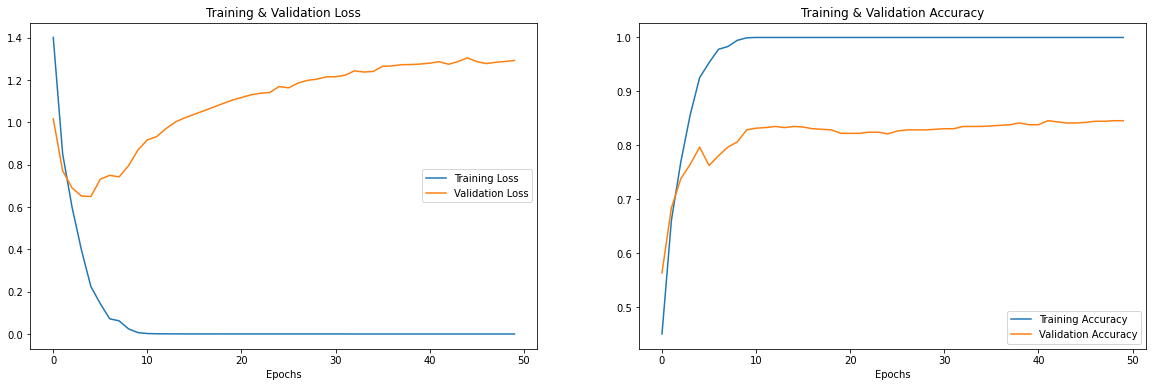

In [ ]:
epochs = [i for i in range(50)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
test_acc = history.history['val_accuracy']
test_loss = history.history['val_loss']

fig.set_size_inches(20,6)
ax[0].plot(epochs , train_loss , label = 'Training Loss')
ax[0].plot(epochs , test_loss , label = 'Validation Loss')
ax[0].set_title('Training & Validation Loss')
ax[0].legend()
ax[0].set_xlabel("Epochs")

ax[1].plot(epochs , train_acc , label = 'Training Accuracy')
ax[1].plot(epochs , test_acc , label = 'Validation Accuracy')
ax[1].set_title('Training & Validation Accuracy')
ax[1].legend()
ax[1].set_xlabel("Epochs")
plt.show()

8/8 [==============================] - 1s 36ms/step


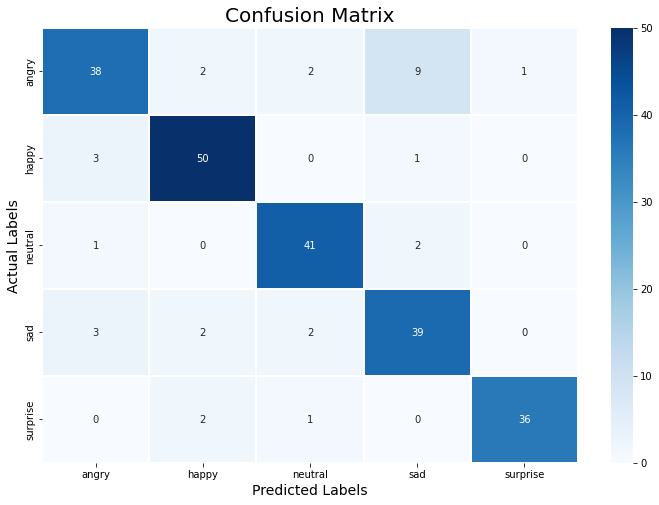

              precision    recall  f1-score   support

       angry       0.84      0.73      0.78        52
       happy       0.89      0.93      0.91        54
     neutral       0.89      0.93      0.91        44
         sad       0.76      0.85      0.80        46
    surprise       0.97      0.92      0.95        39

    accuracy                           0.87       235
   macro avg       0.87      0.87      0.87       235
weighted avg       0.87      0.87      0.87       235



In [ ]:
# predicting on test data.
pred_test = model.predict(X_test)
#pred_test = pred_test.astype(int).flatten()
y_pred = encoder.inverse_transform(pred_test)

#y_test = y_test.astype(int).flatten()
y_test = encoder.inverse_transform(y_test)
df = pd.DataFrame(columns=['Predicted Labels', 'Actual Labels'])
df['Predicted Labels'] = y_pred.flatten()
df['Actual Labels'] = y_test.flatten()

df.head(10)
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize = (12, 8))
cm = pd.DataFrame(cm , index = [i for i in encoder.categories_] , columns = [i for i in encoder.categories_])
sns.heatmap(cm, linecolor='white', cmap='Blues', linewidth=1, annot=True, fmt='')
plt.title('Confusion Matrix', size=20)
plt.xlabel('Predicted Labels', size=14)
plt.ylabel('Actual Labels', size=14)
plt.show()
print(classification_report(y_test, y_pred))